In [ ]:
keep 
atr_14  , OBV

drop

'ema_cross_up', 'macd_cross_up', 'oversold_reversal', 'overbought_reversal', 'trending_market'

In [ ]:
drop_lstm_cnn = [
    'open', 'high', 'low', 'typical_price', 'EMA_21', 'SMA_20',
    'vwap_24h', 'close_4h', 'bollinger_upper', 'bollinger_lower',
    'resistance_level', 'support_level', 'high_low', 'high_close', 'low_close',
    'true_range', 'volume_mean_20', 'MACD_line', 'MACD_signal',
    'volatility_regime', 'trending_market', 'above_sma50', 'ema7_above_ema21',
    'rsi_overbought', 'stoch_oversold', 'cci_oversold',
    'vol_spike_1_5x', 'near_upper_band', 'near_lower_band',
    'break_upper_band', 'break_lower_band', 'rsi_oversold',
    'above_sma20', 'macd_positive', 'volume_breakout', 'volume_breakdown',
    'bullish_scenario_1', 'bullish_scenario_2', 'bullish_scenario_3',
    'bullish_scenario_4', 'bullish_scenario_5', 'bullish_scenario_6',
    'bearish_scenario_1', 'bearish_scenario_2', 'bearish_scenario_3',
    'bearish_scenario_4', 'bearish_scenario_6','ema_cross_up', 'macd_cross_up', 'oversold_reversal', 'overbought_reversal'
]

In [18]:
# =============================================================
#  CNN–LSTM Optuna Trainer  (GPU, XLA, big batches)
# =============================================================
import os, json, gc, warnings, optuna
from datetime import datetime
from pathlib import Path
from typing import Dict, Tuple

import numpy as np
import pandas as pd
import joblib
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (precision_score, recall_score,
                             f1_score, accuracy_score)

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from optuna_integration.tfkeras import TFKerasPruningCallback

# ───── Runtime setup ─────
warnings.filterwarnings("ignore")
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
tf.config.optimizer.set_jit(True)            # XLA on

SEED, VAL_FRAC, ALPHA = 42, 0.20, 2.0
N_TRIALS, TIMEOUT      = 100, 3 * 60 * 60    # 2h wall limit

CSV_PATH = Path(r"C:\Users\ADMIN\Desktop\Coding_projects\stock_market_prediction"
                r"\Stock-Market-Prediction\data\processed\gemini_btc_with_features_4h.csv")
SCALER_PKL = "cnn_lstm_scaler.pkl"

DROP_COLS = [  # duplicates removed
    "open","high","low","typical_price","EMA_21","SMA_20","close_4h",
    "bollinger_upper","bollinger_lower","resistance_level","support_level",
    "high_low","high_close","low_close","true_range","volume_mean_20",
    "MACD_line","MACD_signal","volatility_regime","trending_market",
    "above_sma50","ema7_above_ema21","rsi_overbought","stoch_oversold",
    "cci_oversold","near_upper_band","near_lower_band","break_upper_band",
    "break_lower_band","rsi_oversold","above_sma20","macd_positive",
    "volume_breakout","volume_breakdown","bullish_scenario_1","bullish_scenario_2",
    "bullish_scenario_3","bullish_scenario_4","bullish_scenario_5","bullish_scenario_6",
    "bearish_scenario_1","bearish_scenario_2","bearish_scenario_3","bearish_scenario_4",
    "bearish_scenario_6","ema_cross_up","macd_cross_up",
    "oversold_reversal","overbought_reversal","close"
]

np.random.seed(SEED)
tf.random.set_seed(SEED)
for g in tf.config.experimental.list_physical_devices("GPU"):
    tf.config.experimental.set_memory_growth(g, True)

# ───── Data ─────
df = (pd.read_csv(CSV_PATH, index_col=0, parse_dates=True)
        .loc["2018-01-01":]
        .drop(columns=[c for c in DROP_COLS if c in df.columns])
        .dropna(subset=["target"]).dropna())

X_raw = df.drop(columns="target").values.astype(np.float32)
y_raw = df["target"].astype(int).values
n_feat = X_raw.shape[1]

split = int(len(df) * (1 - VAL_FRAC))
scaler = StandardScaler().fit(X_raw[:split])
joblib.dump(scaler, SCALER_PKL)

X_tr_raw = scaler.transform(X_raw[:split]);  y_tr_raw = y_raw[:split]
X_va_raw = scaler.transform(X_raw[split:]);   y_va_raw = y_raw[split:]

pos   = y_tr_raw.mean()
W0, W1 = 1.0, np.float32((1 - pos) / pos) if pos else np.float32(1.0)

# ───── Window cache ─────
_CACHE: Dict[Tuple[int,int,int], Tuple[np.ndarray,np.ndarray]] = {}
def make_windows(arr, lab, win):
    k = (len(arr), win, arr.shape[1])
    if k in _CACHE: return _CACHE[k]
    xs, ys = [], []
    for i in range(win, len(arr)):
        xs.append(arr[i-win:i]); ys.append(lab[i])
    Xw, yw = np.asarray(xs,np.float32), np.asarray(ys,np.int8)
    if Xw.nbytes + yw.nbytes < 1e9:
        _CACHE[k] = (Xw, yw)
    return Xw, yw

def wf1(y, p, alpha=ALPHA):
    hat = (p >= .5).astype(int)
    pr  = precision_score(y, hat, zero_division=0)
    rc  = recall_score   (y, hat, zero_division=0)
    return 0 if pr+rc == 0 else (1+alpha)*pr*rc/(alpha*pr+rc)

# ───── Model ─────
def build(cfg):
    l2 = regularizers.l2(cfg["l2"])
    inp = layers.Input(shape=(cfg["window"], n_feat))

    if cfg["arch"] == "conv_lstm":
        x = inp
        for _ in range(cfg["conv_blocks"]):
            x = layers.Conv1D(cfg["filters"], cfg["kernel"], padding="causal",
                              activation=cfg["act"], kernel_regularizer=l2)(x)
            x = layers.Dropout(cfg["conv_drop"])(x)
        x = layers.LSTM(cfg["units"], dropout=0.0)(x)             # cuDNN fast
    else:  # lstm_conv
        x = layers.LSTM(cfg["units"], dropout=0.0,
                        return_sequences=True)(inp)
        x = layers.Conv1D(cfg["filters"], cfg["kernel"], padding="same",
                          activation=cfg["act"], kernel_regularizer=l2)(x)
        x = (layers.GlobalMaxPooling1D() if cfg["pool"]=="gmp"
             else layers.GlobalAveragePooling1D())(x)

    x = layers.Dense(cfg["dense"], activation=cfg["act"], kernel_regularizer=l2)(x)
    x = layers.Dropout(cfg["dropout"])(x)
    out = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inp, out)

    w0 = tf.constant(W0, dtype=tf.float32)
    w1 = tf.constant(W1, dtype=tf.float32)
    def loss(y_t, y_p):
        y_t = tf.cast(y_t, tf.float32)
        weights = tf.where(tf.equal(y_t, 1), w1, w0)
        return tf.reduce_mean(weights * keras.losses.binary_crossentropy(y_t, y_p))

    opt = (keras.optimizers.AdamW(cfg["lr"], weight_decay=cfg["l2"])
           if cfg["optim"] == "adamw"
           else keras.optimizers.Nadam(cfg["lr"]) if cfg["optim"] == "nadam"
           else keras.optimizers.Adam(cfg["lr"]))
    model.compile(opt, loss=loss)
    return model

# ───── Optuna objective ─────
def objective(trial: optuna.trial.Trial):
    cfg = dict(
        arch        = trial.suggest_categorical("arch", ["conv_lstm","lstm_conv"]),
        window      = trial.suggest_int("window", 12, 72, step=6),
        filters     = trial.suggest_categorical("filters",[32,48,64,96,128]),
        kernel      = trial.suggest_int("kernel", 2, 7),
        units       = trial.suggest_categorical("units",[32,64,96,128,192]),
        conv_drop   = trial.suggest_float("conv_drop", 0, .3),
        dense       = trial.suggest_categorical("dense",[32,64,128]),
        dropout     = trial.suggest_float("dropout", 0, .4),
        l2          = trial.suggest_float("l2", 1e-6, 1e-3, log=True),
        lr          = trial.suggest_float("lr", 5e-5, 3e-3, log=True),
        batch       = trial.suggest_categorical("batch",[64,128,256]),
        act         = trial.suggest_categorical("act", ["relu","elu"]),
        pool        = trial.suggest_categorical("pool",["gmp","gap"]),
        conv_blocks = trial.suggest_int("conv_blocks", 1, 2),
        optim       = trial.suggest_categorical("optim", ["adam","adamw","nadam"]),
        units_dummy = 0  # placeholder so cfg dict has same keys in both branches
    )
    Xtr, ytr = make_windows(X_tr_raw, y_tr_raw, cfg["window"])
    Xva, yva = make_windows(X_va_raw, y_va_raw, cfg["window"])
    if len(Xtr) < cfg["batch"] * 4:
        return float("inf")

    ds_tr = (tf.data.Dataset.from_tensor_slices((Xtr, ytr))
             .shuffle(10_000).batch(cfg["batch"]).prefetch(tf.data.AUTOTUNE))
    ds_va = (tf.data.Dataset.from_tensor_slices((Xva, yva))
             .batch(cfg["batch"]).prefetch(tf.data.AUTOTUNE))  # not shuffled – label order preserved

    tf.keras.backend.clear_session(); gc.collect()
    model = build(cfg)

    cb = [keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True, verbose=0),
          keras.callbacks.ReduceLROnPlateau(patience=5, factor=.5, min_lr=1e-6, verbose=0),
          TFKerasPruningCallback(trial, "val_loss")]
    model.fit(ds_tr, validation_data=ds_va, epochs=100, callbacks=cb, verbose=0)

    prob  = model.predict(ds_va, verbose=0).ravel()
    y_hat = (prob >= .5).astype(int)
    score = wf1(yva, prob)

    pr = precision_score(yva, y_hat, zero_division=0)
    rc = recall_score   (yva, y_hat, zero_division=0)
    trial.set_user_attr("precision", pr); trial.set_user_attr("recall", rc)

    print(f"T{trial.number:02d} | Fα2={score:.3f} P={pr:.3f} R={rc:.3f} "
          f"{cfg['arch']} win={cfg['window']}")

    del model; tf.keras.backend.clear_session(); gc.collect()
    return -score

# ───── Search ─────
study = optuna.create_study(
    direction="minimize",
    sampler=optuna.samplers.TPESampler(seed=SEED, multivariate=True),
    pruner =optuna.pruners.MedianPruner(n_startup_trials=5))
print(f"🚀  Starting {N_TRIALS}-trial search (big batches, cuDNN, XLA)…")
study.optimize(objective, n_trials=N_TRIALS,
               timeout=TIMEOUT, show_progress_bar=True, gc_after_trial=True)

best, ts = study.best_trial, datetime.utcnow().strftime("%Y%m%d_%H%M%S")
print(json.dumps({**best.params, "Fα2": -best.value,
                  "P": best.user_attrs["precision"],
                  "R": best.user_attrs["recall"]}, indent=2))

json.dump(best.params, open(f"best_params_cnn_lstm_{ts}.json","w"), indent=2)
study.trials_dataframe().to_csv(f"trials_cnn_lstm_{ts}.csv", index=False)
print(f"📜 Done – scaler saved → {SCALER_PKL}")


[I 2025-06-11 14:26:29,625] A new study created in memory with name: no-name-7c072783-b210-43ed-a4cc-e469a26c0a4b


🚀  Starting 100-trial search (big batches, cuDNN, XLA)…


  0%|          | 0/100 [00:00<?, ?it/s]

T00 | Fα2=0.595 P=0.521 R=0.640 lstm_conv win=60


  0%|          | 0/100 [02:29<?, ?it/s]

[I 2025-06-11 14:28:59,301] Trial 0 finished with value: -0.5948424068767908 and parameters: {'arch': 'lstm_conv', 'window': 60, 'filters': 128, 'kernel': 5, 'units': 96, 'conv_drop': 0.05454749016213018, 'dense': 128, 'dropout': 0.17277800745684632, 'l2': 7.4763120622522945e-06, 'lr': 0.000612261560602803, 'batch': 256, 'act': 'elu', 'pool': 'gap', 'conv_blocks': 2, 'optim': 'adamw'}. Best is trial 0 with value: -0.5948424068767908.


Best trial: 0. Best value: -0.594842:   1%|          | 1/100 [02:31<4:09:18, 151.10s/it, 151.10/10800 seconds]

T01 | Fα2=0.391 P=0.522 R=0.348 lstm_conv win=72


Best trial: 0. Best value: -0.594842:   1%|          | 1/100 [06:24<4:09:18, 151.10s/it, 151.10/10800 seconds]

[I 2025-06-11 14:32:53,658] Trial 1 finished with value: -0.3912740775121838 and parameters: {'arch': 'lstm_conv', 'window': 72, 'filters': 32, 'kernel': 2, 'units': 96, 'conv_drop': 0.09351332282682329, 'dense': 64, 'dropout': 0.38783385110582347, 'l2': 0.00021154290797261214, 'lr': 0.0023417537373087377, 'batch': 256, 'act': 'elu', 'pool': 'gap', 'conv_blocks': 1, 'optim': 'adamw'}. Best is trial 0 with value: -0.5948424068767908.


Best trial: 0. Best value: -0.594842:   2%|▏         | 2/100 [06:25<5:26:48, 200.09s/it, 385.48/10800 seconds]

T02 | Fα2=0.547 P=0.518 R=0.563 lstm_conv win=18


Best trial: 0. Best value: -0.594842:   2%|▏         | 2/100 [06:50<5:26:48, 200.09s/it, 385.48/10800 seconds]

[I 2025-06-11 14:33:20,153] Trial 2 finished with value: -0.5472773736976606 and parameters: {'arch': 'lstm_conv', 'window': 18, 'filters': 64, 'kernel': 2, 'units': 32, 'conv_drop': 0.10753971856328177, 'dense': 64, 'dropout': 0.13235920994105968, 'l2': 1.5512259126484753e-06, 'lr': 0.00017862556214123332, 'batch': 128, 'act': 'relu', 'pool': 'gap', 'conv_blocks': 2, 'optim': 'adamw'}. Best is trial 0 with value: -0.5948424068767908.


Best trial: 0. Best value: -0.594842:   3%|▎         | 3/100 [06:51<3:15:20, 120.83s/it, 411.99/10800 seconds]

T03 | Fα2=0.527 P=0.533 R=0.524 conv_lstm win=12


Best trial: 0. Best value: -0.594842:   3%|▎         | 3/100 [07:34<3:15:20, 120.83s/it, 411.99/10800 seconds]

[I 2025-06-11 14:34:03,842] Trial 3 finished with value: -0.5269035532994923 and parameters: {'arch': 'conv_lstm', 'window': 12, 'filters': 64, 'kernel': 7, 'units': 96, 'conv_drop': 0.0869254358741304, 'dense': 64, 'dropout': 0.2533615026041694, 'l2': 0.00041151130495610907, 'lr': 0.001342828384653336, 'batch': 128, 'act': 'elu', 'pool': 'gmp', 'conv_blocks': 1, 'optim': 'nadam'}. Best is trial 0 with value: -0.5948424068767908.


Best trial: 0. Best value: -0.594842:   4%|▍         | 4/100 [07:35<2:24:36, 90.38s/it, 455.69/10800 seconds] 

T04 | Fα2=0.677 P=0.518 R=0.800 lstm_conv win=36


Best trial: 0. Best value: -0.594842:   4%|▍         | 4/100 [09:37<2:24:36, 90.38s/it, 455.69/10800 seconds]

[I 2025-06-11 14:36:07,021] Trial 4 finished with value: -0.677185721676151 and parameters: {'arch': 'lstm_conv', 'window': 36, 'filters': 96, 'kernel': 5, 'units': 96, 'conv_drop': 0.14917455176771563, 'dense': 32, 'dropout': 0.24382573359195875, 'l2': 3.2213437409123405e-05, 'lr': 6.173152563090738e-05, 'batch': 128, 'act': 'elu', 'pool': 'gmp', 'conv_blocks': 2, 'optim': 'adam'}. Best is trial 4 with value: -0.677185721676151.


Best trial: 4. Best value: -0.677186:   5%|▌         | 5/100 [11:40<2:41:49, 102.21s/it, 578.87/10800 seconds]

[I 2025-06-11 14:38:10,590] Trial 5 pruned. Trial was pruned at epoch 16.


Best trial: 4. Best value: -0.677186:   6%|▌         | 6/100 [11:55<2:51:31, 109.48s/it, 702.47/10800 seconds]

[I 2025-06-11 14:38:25,192] Trial 6 pruned. Trial was pruned at epoch 0.


Best trial: 4. Best value: -0.677186:   7%|▋         | 7/100 [11:57<2:01:36, 78.46s/it, 717.05/10800 seconds] 

T07 | Fα2=0.691 P=0.519 R=0.828 conv_lstm win=72


Best trial: 4. Best value: -0.677186:   7%|▋         | 7/100 [14:14<2:01:36, 78.46s/it, 717.05/10800 seconds]

[I 2025-06-11 14:40:44,050] Trial 7 finished with value: -0.6909967292132897 and parameters: {'arch': 'conv_lstm', 'window': 72, 'filters': 48, 'kernel': 5, 'units': 96, 'conv_drop': 0.19364168877215035, 'dense': 128, 'dropout': 0.3659457560881794, 'l2': 1.2896625857891445e-05, 'lr': 5.326650551390532e-05, 'batch': 256, 'act': 'relu', 'pool': 'gap', 'conv_blocks': 2, 'optim': 'nadam'}. Best is trial 7 with value: -0.6909967292132897.


Best trial: 7. Best value: -0.690997:   8%|▊         | 8/100 [14:39<2:29:51, 97.73s/it, 856.05/10800 seconds]

[I 2025-06-11 14:41:09,220] Trial 8 pruned. Trial was pruned at epoch 4.


Best trial: 7. Best value: -0.690997:   9%|▉         | 9/100 [14:52<1:53:49, 75.05s/it, 881.23/10800 seconds]

[I 2025-06-11 14:41:22,606] Trial 9 pruned. Trial was pruned at epoch 4.


Best trial: 7. Best value: -0.690997:  10%|█         | 10/100 [14:54<1:24:01, 56.01s/it, 894.61/10800 seconds]

T10 | Fα2=0.685 P=0.532 R=0.801 conv_lstm win=72


Best trial: 7. Best value: -0.690997:  10%|█         | 10/100 [16:22<1:24:01, 56.01s/it, 894.61/10800 seconds]

[I 2025-06-11 14:42:51,866] Trial 10 finished with value: -0.6853813559322035 and parameters: {'arch': 'conv_lstm', 'window': 72, 'filters': 48, 'kernel': 3, 'units': 32, 'conv_drop': 0.14914175826424267, 'dense': 128, 'dropout': 0.36311711503988925, 'l2': 2.4631096227367697e-05, 'lr': 9.919404853103473e-05, 'batch': 64, 'act': 'relu', 'pool': 'gap', 'conv_blocks': 2, 'optim': 'nadam'}. Best is trial 7 with value: -0.6909967292132897.


Best trial: 7. Best value: -0.690997:  11%|█         | 11/100 [16:35<1:38:11, 66.19s/it, 983.89/10800 seconds]

[I 2025-06-11 14:43:04,653] Trial 11 pruned. Trial was pruned at epoch 0.


Best trial: 7. Best value: -0.690997:  12%|█▏        | 12/100 [16:36<1:13:17, 49.97s/it, 996.75/10800 seconds]

T12 | Fα2=0.588 P=0.527 R=0.625 conv_lstm win=66


Best trial: 7. Best value: -0.690997:  12%|█▏        | 12/100 [18:20<1:13:17, 49.97s/it, 996.75/10800 seconds]

[I 2025-06-11 14:44:50,201] Trial 12 finished with value: -0.5884861407249468 and parameters: {'arch': 'conv_lstm', 'window': 66, 'filters': 48, 'kernel': 6, 'units': 96, 'conv_drop': 0.22606400599215065, 'dense': 128, 'dropout': 0.22176648138502159, 'l2': 4.5679942859048045e-06, 'lr': 5.5459545060680684e-05, 'batch': 128, 'act': 'relu', 'pool': 'gap', 'conv_blocks': 1, 'optim': 'nadam'}. Best is trial 7 with value: -0.6909967292132897.


Best trial: 7. Best value: -0.690997:  13%|█▎        | 13/100 [18:31<1:36:52, 66.82s/it, 1102.33/10800 seconds]

[I 2025-06-11 14:45:01,423] Trial 13 pruned. Trial was pruned at epoch 0.


Best trial: 7. Best value: -0.690997:  14%|█▍        | 14/100 [18:33<1:11:41, 50.01s/it, 1113.51/10800 seconds]

T14 | Fα2=0.659 P=0.530 R=0.750 conv_lstm win=60


Best trial: 7. Best value: -0.690997:  14%|█▍        | 14/100 [20:00<1:11:41, 50.01s/it, 1113.51/10800 seconds]

[I 2025-06-11 14:46:29,946] Trial 14 finished with value: -0.6591442498645965 and parameters: {'arch': 'conv_lstm', 'window': 60, 'filters': 48, 'kernel': 7, 'units': 96, 'conv_drop': 0.16854365802480042, 'dense': 128, 'dropout': 0.34212635055038104, 'l2': 5.34107900020877e-06, 'lr': 8.139951880089569e-05, 'batch': 256, 'act': 'relu', 'pool': 'gap', 'conv_blocks': 2, 'optim': 'adam'}. Best is trial 7 with value: -0.6909967292132897.


Best trial: 7. Best value: -0.690997:  15%|█▌        | 15/100 [20:10<1:27:16, 61.60s/it, 1201.98/10800 seconds]

[I 2025-06-11 14:46:40,476] Trial 15 pruned. Trial was pruned at epoch 0.


Best trial: 7. Best value: -0.690997:  16%|█▌        | 16/100 [20:26<1:04:43, 46.24s/it, 1212.53/10800 seconds]

[I 2025-06-11 14:46:56,098] Trial 16 pruned. Trial was pruned at epoch 0.


Best trial: 7. Best value: -0.690997:  17%|█▋        | 17/100 [20:28<51:14, 37.04s/it, 1228.20/10800 seconds]  

T17 | Fα2=0.709 P=0.519 R=0.868 conv_lstm win=72


Best trial: 7. Best value: -0.690997:  17%|█▋        | 17/100 [21:57<51:14, 37.04s/it, 1228.20/10800 seconds]

[I 2025-06-11 14:48:26,804] Trial 17 finished with value: -0.7087967644084935 and parameters: {'arch': 'conv_lstm', 'window': 72, 'filters': 48, 'kernel': 2, 'units': 32, 'conv_drop': 0.2020859487428539, 'dense': 128, 'dropout': 0.3311343605595314, 'l2': 5.446410711918106e-06, 'lr': 0.0002933566355803551, 'batch': 64, 'act': 'relu', 'pool': 'gmp', 'conv_blocks': 2, 'optim': 'nadam'}. Best is trial 17 with value: -0.7087967644084935.


Best trial: 17. Best value: -0.708797:  18%|█▊        | 18/100 [21:58<1:12:35, 53.11s/it, 1318.71/10800 seconds]

T18 | Fα2=0.729 P=0.529 R=0.898 conv_lstm win=66


Best trial: 17. Best value: -0.708797:  18%|█▊        | 18/100 [26:04<1:12:35, 53.11s/it, 1318.71/10800 seconds]

[I 2025-06-11 14:52:34,085] Trial 18 finished with value: -0.7285785869383664 and parameters: {'arch': 'conv_lstm', 'window': 66, 'filters': 48, 'kernel': 2, 'units': 128, 'conv_drop': 0.1829073485357999, 'dense': 64, 'dropout': 0.3367267654373487, 'l2': 1.9949353471421903e-06, 'lr': 0.0010969018481585208, 'batch': 64, 'act': 'relu', 'pool': 'gmp', 'conv_blocks': 2, 'optim': 'nadam'}. Best is trial 18 with value: -0.7285785869383664.


Best trial: 18. Best value: -0.728579:  19%|█▉        | 19/100 [26:19<2:30:26, 111.43s/it, 1566.01/10800 seconds]

[I 2025-06-11 14:52:48,629] Trial 19 pruned. Trial was pruned at epoch 0.


Best trial: 18. Best value: -0.728579:  20%|██        | 20/100 [26:20<1:49:48, 82.35s/it, 1580.59/10800 seconds] 

T20 | Fα2=0.732 P=0.524 R=0.914 conv_lstm win=60


Best trial: 18. Best value: -0.728579:  20%|██        | 20/100 [30:17<1:49:48, 82.35s/it, 1580.59/10800 seconds]

[I 2025-06-11 14:56:46,797] Trial 20 finished with value: -0.7319723411261113 and parameters: {'arch': 'conv_lstm', 'window': 60, 'filters': 96, 'kernel': 2, 'units': 128, 'conv_drop': 0.23169116379282378, 'dense': 128, 'dropout': 0.22993558336668984, 'l2': 1.1980316309987873e-06, 'lr': 0.0010514052377099624, 'batch': 64, 'act': 'relu', 'pool': 'gap', 'conv_blocks': 2, 'optim': 'nadam'}. Best is trial 20 with value: -0.7319723411261113.


Best trial: 20. Best value: -0.731972:  21%|██        | 21/100 [30:18<2:50:00, 129.12s/it, 1818.73/10800 seconds]

T21 | Fα2=0.597 P=0.533 R=0.636 conv_lstm win=48


Best trial: 20. Best value: -0.731972:  21%|██        | 21/100 [33:25<2:50:00, 129.12s/it, 1818.73/10800 seconds]

[I 2025-06-11 14:59:54,707] Trial 21 finished with value: -0.5973476840284452 and parameters: {'arch': 'conv_lstm', 'window': 48, 'filters': 96, 'kernel': 3, 'units': 128, 'conv_drop': 0.13417079120549671, 'dense': 128, 'dropout': 0.20486313559166633, 'l2': 1.3625466836519646e-06, 'lr': 0.0009418760303623328, 'batch': 64, 'act': 'relu', 'pool': 'gmp', 'conv_blocks': 2, 'optim': 'nadam'}. Best is trial 20 with value: -0.7319723411261113.


Best trial: 20. Best value: -0.731972:  22%|██▏       | 22/100 [33:26<3:10:46, 146.75s/it, 2006.62/10800 seconds]

T22 | Fα2=0.672 P=0.528 R=0.778 conv_lstm win=66


Best trial: 20. Best value: -0.731972:  22%|██▏       | 22/100 [37:25<3:10:46, 146.75s/it, 2006.62/10800 seconds]

[I 2025-06-11 15:03:55,538] Trial 22 finished with value: -0.6717611515905456 and parameters: {'arch': 'conv_lstm', 'window': 66, 'filters': 64, 'kernel': 2, 'units': 128, 'conv_drop': 0.20725498441456727, 'dense': 64, 'dropout': 0.1514327494157322, 'l2': 3.4372389137912706e-06, 'lr': 0.0011623426402264853, 'batch': 64, 'act': 'relu', 'pool': 'gap', 'conv_blocks': 2, 'optim': 'nadam'}. Best is trial 20 with value: -0.7319723411261113.


Best trial: 20. Best value: -0.731972:  23%|██▎       | 23/100 [37:58<3:44:35, 175.01s/it, 2247.53/10800 seconds]

[I 2025-06-11 15:04:28,071] Trial 23 pruned. Trial was pruned at epoch 0.


Best trial: 20. Best value: -0.731972:  24%|██▍       | 24/100 [38:00<2:47:31, 132.26s/it, 2280.06/10800 seconds]

T24 | Fα2=0.717 P=0.523 R=0.880 lstm_conv win=60


Best trial: 20. Best value: -0.731972:  24%|██▍       | 24/100 [40:47<2:47:31, 132.26s/it, 2280.06/10800 seconds]

[I 2025-06-11 15:07:16,928] Trial 24 finished with value: -0.7172275238573581 and parameters: {'arch': 'lstm_conv', 'window': 60, 'filters': 48, 'kernel': 3, 'units': 128, 'conv_drop': 0.22458452100672904, 'dense': 64, 'dropout': 0.27475311523806734, 'l2': 1.162732997626243e-06, 'lr': 0.0012399873702159075, 'batch': 256, 'act': 'relu', 'pool': 'gmp', 'conv_blocks': 2, 'optim': 'adamw'}. Best is trial 20 with value: -0.7319723411261113.


Best trial: 20. Best value: -0.731972:  25%|██▌       | 25/100 [41:06<2:59:02, 143.23s/it, 2448.89/10800 seconds]

[I 2025-06-11 15:07:35,721] Trial 25 pruned. Trial was pruned at epoch 0.


Best trial: 20. Best value: -0.731972:  26%|██▌       | 26/100 [41:07<2:10:37, 105.91s/it, 2467.72/10800 seconds]

T26 | Fα2=0.708 P=0.524 R=0.859 lstm_conv win=66


Best trial: 20. Best value: -0.731972:  26%|██▌       | 26/100 [43:12<2:10:37, 105.91s/it, 2467.72/10800 seconds]

[I 2025-06-11 15:09:42,598] Trial 26 finished with value: -0.7082767978290366 and parameters: {'arch': 'lstm_conv', 'window': 66, 'filters': 48, 'kernel': 3, 'units': 64, 'conv_drop': 0.18808609956374508, 'dense': 128, 'dropout': 0.3124217042135821, 'l2': 1.701627483058166e-06, 'lr': 0.0020810000414228608, 'batch': 256, 'act': 'relu', 'pool': 'gmp', 'conv_blocks': 2, 'optim': 'adamw'}. Best is trial 20 with value: -0.7319723411261113.


Best trial: 20. Best value: -0.731972:  27%|██▋       | 27/100 [43:28<2:16:33, 112.24s/it, 2594.73/10800 seconds]

[I 2025-06-11 15:09:58,292] Trial 27 pruned. Trial was pruned at epoch 0.


Best trial: 20. Best value: -0.731972:  28%|██▊       | 28/100 [43:30<1:39:55, 83.27s/it, 2610.43/10800 seconds] 

T28 | Fα2=0.703 P=0.526 R=0.845 lstm_conv win=72


Best trial: 20. Best value: -0.731972:  28%|██▊       | 28/100 [47:08<1:39:55, 83.27s/it, 2610.43/10800 seconds]

[I 2025-06-11 15:13:38,257] Trial 28 finished with value: -0.703036541430777 and parameters: {'arch': 'lstm_conv', 'window': 72, 'filters': 128, 'kernel': 5, 'units': 128, 'conv_drop': 0.17053482179312465, 'dense': 64, 'dropout': 0.33831466588119824, 'l2': 1.6450611097511145e-06, 'lr': 0.0010824559227546788, 'batch': 64, 'act': 'relu', 'pool': 'gmp', 'conv_blocks': 2, 'optim': 'adamw'}. Best is trial 20 with value: -0.7319723411261113.


Best trial: 20. Best value: -0.731972:  29%|██▉       | 29/100 [47:10<2:27:05, 124.30s/it, 2830.44/10800 seconds]

T29 | Fα2=0.692 P=0.521 R=0.829 conv_lstm win=60


Best trial: 20. Best value: -0.731972:  29%|██▉       | 29/100 [49:44<2:27:05, 124.30s/it, 2830.44/10800 seconds]

[I 2025-06-11 15:16:14,025] Trial 29 finished with value: -0.6923076923076923 and parameters: {'arch': 'conv_lstm', 'window': 60, 'filters': 32, 'kernel': 2, 'units': 128, 'conv_drop': 0.17655258017029987, 'dense': 64, 'dropout': 0.3750434027374682, 'l2': 1.5304402108416722e-06, 'lr': 0.0018149865587916117, 'batch': 64, 'act': 'relu', 'pool': 'gmp', 'conv_blocks': 1, 'optim': 'nadam'}. Best is trial 20 with value: -0.7319723411261113.


Best trial: 20. Best value: -0.731972:  30%|███       | 30/100 [49:58<2:36:01, 133.73s/it, 2986.19/10800 seconds]

[I 2025-06-11 15:16:28,624] Trial 30 pruned. Trial was pruned at epoch 0.


Best trial: 20. Best value: -0.731972:  31%|███       | 31/100 [50:11<1:52:41, 97.99s/it, 3000.77/10800 seconds] 

[I 2025-06-11 15:16:40,861] Trial 31 pruned. Trial was pruned at epoch 0.


Best trial: 20. Best value: -0.731972:  32%|███▏      | 32/100 [50:32<1:21:55, 72.29s/it, 3013.09/10800 seconds]

[I 2025-06-11 15:17:02,199] Trial 32 pruned. Trial was pruned at epoch 0.


Best trial: 20. Best value: -0.731972:  33%|███▎      | 33/100 [50:34<1:03:38, 57.00s/it, 3034.42/10800 seconds]

T33 | Fα2=0.628 P=0.531 R=0.691 conv_lstm win=66


Best trial: 20. Best value: -0.731972:  33%|███▎      | 33/100 [51:37<1:03:38, 57.00s/it, 3034.42/10800 seconds]

[I 2025-06-11 15:18:07,065] Trial 33 finished with value: -0.628154795288839 and parameters: {'arch': 'conv_lstm', 'window': 66, 'filters': 64, 'kernel': 4, 'units': 32, 'conv_drop': 0.25301886959374464, 'dense': 128, 'dropout': 0.3266113420716731, 'l2': 2.565111517777266e-06, 'lr': 0.0004553361197772574, 'batch': 128, 'act': 'relu', 'pool': 'gmp', 'conv_blocks': 2, 'optim': 'nadam'}. Best is trial 20 with value: -0.7319723411261113.


Best trial: 20. Best value: -0.731972:  34%|███▍      | 34/100 [51:58<1:05:16, 59.34s/it, 3099.23/10800 seconds]

[I 2025-06-11 15:18:28,032] Trial 34 pruned. Trial was pruned at epoch 0.


Best trial: 20. Best value: -0.731972:  35%|███▌      | 35/100 [52:00<51:50, 47.85s/it, 3120.26/10800 seconds]  

T35 | Fα2=0.602 P=0.539 R=0.639 conv_lstm win=66


Best trial: 20. Best value: -0.731972:  35%|███▌      | 35/100 [57:05<51:50, 47.85s/it, 3120.26/10800 seconds]

[I 2025-06-11 15:23:34,952] Trial 35 finished with value: -0.6018608257414227 and parameters: {'arch': 'conv_lstm', 'window': 66, 'filters': 48, 'kernel': 2, 'units': 128, 'conv_drop': 0.2290901400745524, 'dense': 128, 'dropout': 0.35586673619835707, 'l2': 3.4370979194197407e-06, 'lr': 0.0002580404573248242, 'batch': 64, 'act': 'relu', 'pool': 'gmp', 'conv_blocks': 2, 'optim': 'nadam'}. Best is trial 20 with value: -0.7319723411261113.


Best trial: 20. Best value: -0.731972:  36%|███▌      | 36/100 [57:29<2:13:53, 125.52s/it, 3427.00/10800 seconds]

[I 2025-06-11 15:23:58,720] Trial 36 pruned. Trial was pruned at epoch 0.


Best trial: 20. Best value: -0.731972:  37%|███▋      | 37/100 [57:50<1:39:44, 95.00s/it, 3450.79/10800 seconds] 

[I 2025-06-11 15:24:20,498] Trial 37 pruned. Trial was pruned at epoch 0.


Best trial: 20. Best value: -0.731972:  38%|███▊      | 38/100 [58:02<1:15:28, 73.04s/it, 3472.58/10800 seconds]

[I 2025-06-11 15:24:32,309] Trial 38 pruned. Trial was pruned at epoch 0.


Best trial: 20. Best value: -0.731972:  39%|███▉      | 39/100 [58:16<55:34, 54.67s/it, 3484.39/10800 seconds]  

[I 2025-06-11 15:24:45,997] Trial 39 pruned. Trial was pruned at epoch 0.


Best trial: 20. Best value: -0.731972:  40%|████      | 40/100 [58:18<42:23, 42.39s/it, 3498.12/10800 seconds]

T40 | Fα2=0.636 P=0.530 R=0.706 conv_lstm win=72


Best trial: 20. Best value: -0.731972:  40%|████      | 40/100 [59:58<42:23, 42.39s/it, 3498.12/10800 seconds]

[I 2025-06-11 15:26:27,891] Trial 40 finished with value: -0.6355365763089491 and parameters: {'arch': 'conv_lstm', 'window': 72, 'filters': 48, 'kernel': 3, 'units': 32, 'conv_drop': 0.2991414066265154, 'dense': 128, 'dropout': 0.3298017348264688, 'l2': 7.605803562468741e-06, 'lr': 0.00012155054083183725, 'batch': 256, 'act': 'relu', 'pool': 'gmp', 'conv_blocks': 2, 'optim': 'adam'}. Best is trial 20 with value: -0.7319723411261113.


Best trial: 20. Best value: -0.731972:  41%|████      | 41/100 [1:00:09<59:17, 60.30s/it, 3600.21/10800 seconds]

[I 2025-06-11 15:26:39,012] Trial 41 pruned. Trial was pruned at epoch 0.


Best trial: 20. Best value: -0.731972:  42%|████▏     | 42/100 [1:00:26<44:00, 45.52s/it, 3611.26/10800 seconds]

[I 2025-06-11 15:26:56,197] Trial 42 pruned. Trial was pruned at epoch 0.


Best trial: 20. Best value: -0.731972:  43%|████▎     | 43/100 [1:00:28<35:09, 37.01s/it, 3628.42/10800 seconds]

T43 | Fα2=0.763 P=0.521 R=0.994 lstm_conv win=66


Best trial: 20. Best value: -0.731972:  43%|████▎     | 43/100 [1:02:17<35:09, 37.01s/it, 3628.42/10800 seconds]

[I 2025-06-11 15:28:47,316] Trial 43 finished with value: -0.7631537367672618 and parameters: {'arch': 'lstm_conv', 'window': 66, 'filters': 32, 'kernel': 4, 'units': 64, 'conv_drop': 0.09979414734158484, 'dense': 128, 'dropout': 0.3879128314126981, 'l2': 2.073472158914153e-06, 'lr': 0.0025838646128367514, 'batch': 256, 'act': 'relu', 'pool': 'gmp', 'conv_blocks': 2, 'optim': 'adamw'}. Best is trial 43 with value: -0.7631537367672618.


Best trial: 43. Best value: -0.763154:  44%|████▍     | 44/100 [1:02:32<55:15, 59.21s/it, 3739.41/10800 seconds]

[I 2025-06-11 15:29:02,165] Trial 44 pruned. Trial was pruned at epoch 0.


Best trial: 43. Best value: -0.763154:  45%|████▌     | 45/100 [1:02:56<42:06, 45.94s/it, 3754.40/10800 seconds]

[I 2025-06-11 15:29:26,136] Trial 45 pruned. Trial was pruned at epoch 0.


Best trial: 43. Best value: -0.763154:  46%|████▌     | 46/100 [1:03:08<35:26, 39.38s/it, 3778.46/10800 seconds]

[I 2025-06-11 15:29:37,875] Trial 46 pruned. Trial was pruned at epoch 0.


Best trial: 43. Best value: -0.763154:  47%|████▋     | 47/100 [1:03:18<27:27, 31.08s/it, 3790.18/10800 seconds]

[I 2025-06-11 15:29:47,671] Trial 47 pruned. Trial was pruned at epoch 0.


Best trial: 43. Best value: -0.763154:  48%|████▊     | 48/100 [1:03:19<21:24, 24.70s/it, 3799.98/10800 seconds]

T48 | Fα2=0.555 P=0.524 R=0.572 lstm_conv win=60


Best trial: 43. Best value: -0.763154:  48%|████▊     | 48/100 [1:04:38<21:24, 24.70s/it, 3799.98/10800 seconds]

[I 2025-06-11 15:31:08,037] Trial 48 finished with value: -0.555245313123255 and parameters: {'arch': 'lstm_conv', 'window': 60, 'filters': 96, 'kernel': 3, 'units': 32, 'conv_drop': 0.17899377038959471, 'dense': 128, 'dropout': 0.22152697641509517, 'l2': 1.3640561599870486e-06, 'lr': 0.00042314293757819894, 'batch': 64, 'act': 'relu', 'pool': 'gap', 'conv_blocks': 2, 'optim': 'nadam'}. Best is trial 43 with value: -0.7631537367672618.


Best trial: 43. Best value: -0.763154:  49%|████▉     | 49/100 [1:04:54<35:12, 41.41s/it, 3880.40/10800 seconds]

[I 2025-06-11 15:31:24,574] Trial 49 pruned. Trial was pruned at epoch 0.


Best trial: 43. Best value: -0.763154:  50%|█████     | 50/100 [1:05:27<28:14, 33.89s/it, 3896.73/10800 seconds]

[I 2025-06-11 15:31:57,236] Trial 50 pruned. Trial was pruned at epoch 0.


Best trial: 43. Best value: -0.763154:  51%|█████     | 51/100 [1:05:43<27:24, 33.56s/it, 3929.52/10800 seconds]

[I 2025-06-11 15:32:13,485] Trial 51 pruned. Trial was pruned at epoch 0.


Best trial: 43. Best value: -0.763154:  52%|█████▏    | 52/100 [1:06:03<22:41, 28.37s/it, 3945.78/10800 seconds]

[I 2025-06-11 15:32:33,364] Trial 52 pruned. Trial was pruned at epoch 0.


Best trial: 43. Best value: -0.763154:  53%|█████▎    | 53/100 [1:06:05<20:13, 25.82s/it, 3965.64/10800 seconds]

T53 | Fα2=0.753 P=0.524 R=0.963 conv_lstm win=42


Best trial: 43. Best value: -0.763154:  53%|█████▎    | 53/100 [1:07:20<20:13, 25.82s/it, 3965.64/10800 seconds]

[I 2025-06-11 15:33:49,953] Trial 53 finished with value: -0.7526332588573252 and parameters: {'arch': 'conv_lstm', 'window': 42, 'filters': 48, 'kernel': 4, 'units': 64, 'conv_drop': 0.1852717446722201, 'dense': 128, 'dropout': 0.38016448336315367, 'l2': 1.5211958873031164e-06, 'lr': 0.001880948993648861, 'batch': 256, 'act': 'relu', 'pool': 'gmp', 'conv_blocks': 2, 'optim': 'adamw'}. Best is trial 43 with value: -0.7631537367672618.


Best trial: 43. Best value: -0.763154:  54%|█████▍    | 54/100 [1:07:38<31:26, 41.02s/it, 4042.12/10800 seconds]

[I 2025-06-11 15:34:08,476] Trial 54 pruned. Trial was pruned at epoch 0.


Best trial: 43. Best value: -0.763154:  55%|█████▌    | 55/100 [1:07:52<25:42, 34.28s/it, 4060.69/10800 seconds]

[I 2025-06-11 15:34:21,987] Trial 55 pruned. Trial was pruned at epoch 0.


Best trial: 43. Best value: -0.763154:  56%|█████▌    | 56/100 [1:07:54<20:35, 28.08s/it, 4074.31/10800 seconds]

T56 | Fα2=0.754 P=0.523 R=0.968 conv_lstm win=72


Best trial: 43. Best value: -0.763154:  56%|█████▌    | 56/100 [1:11:23<20:35, 28.08s/it, 4074.31/10800 seconds]

[I 2025-06-11 15:37:53,323] Trial 56 finished with value: -0.7543408360128617 and parameters: {'arch': 'conv_lstm', 'window': 72, 'filters': 48, 'kernel': 4, 'units': 128, 'conv_drop': 0.13797735437663072, 'dense': 64, 'dropout': 0.23075557455386583, 'l2': 1.49581959499061e-06, 'lr': 0.001599498160491714, 'batch': 64, 'act': 'relu', 'pool': 'gmp', 'conv_blocks': 2, 'optim': 'nadam'}. Best is trial 43 with value: -0.7631537367672618.


Best trial: 43. Best value: -0.763154:  57%|█████▋    | 57/100 [1:11:49<59:32, 83.07s/it, 4285.70/10800 seconds]

[I 2025-06-11 15:38:19,342] Trial 57 pruned. Trial was pruned at epoch 0.


Best trial: 43. Best value: -0.763154:  58%|█████▊    | 58/100 [1:12:15<46:10, 65.96s/it, 4311.72/10800 seconds]

[I 2025-06-11 15:38:45,117] Trial 58 pruned. Trial was pruned at epoch 0.


Best trial: 43. Best value: -0.763154:  59%|█████▉    | 59/100 [1:12:27<36:49, 53.90s/it, 4337.47/10800 seconds]

[I 2025-06-11 15:38:57,152] Trial 59 pruned. Trial was pruned at epoch 0.


Best trial: 43. Best value: -0.763154:  60%|██████    | 60/100 [1:12:29<27:33, 41.34s/it, 4349.51/10800 seconds]

T60 | Fα2=0.756 P=0.521 R=0.978 lstm_conv win=60


Best trial: 43. Best value: -0.763154:  60%|██████    | 60/100 [1:16:00<27:33, 41.34s/it, 4349.51/10800 seconds]

[I 2025-06-11 15:42:29,909] Trial 60 finished with value: -0.7564387917329093 and parameters: {'arch': 'lstm_conv', 'window': 60, 'filters': 48, 'kernel': 2, 'units': 128, 'conv_drop': 0.1786845807647062, 'dense': 64, 'dropout': 0.359900026827392, 'l2': 3.3000499138330928e-06, 'lr': 0.00193590456968632, 'batch': 64, 'act': 'relu', 'pool': 'gap', 'conv_blocks': 2, 'optim': 'nadam'}. Best is trial 43 with value: -0.7631537367672618.


Best trial: 43. Best value: -0.763154:  61%|██████    | 61/100 [1:16:16<1:00:15, 92.71s/it, 4562.09/10800 seconds]

[I 2025-06-11 15:42:45,953] Trial 61 pruned. Trial was pruned at epoch 0.


Best trial: 43. Best value: -0.763154:  62%|██████▏   | 62/100 [1:16:29<44:11, 69.78s/it, 4578.37/10800 seconds]  

[I 2025-06-11 15:42:58,972] Trial 62 pruned. Trial was pruned at epoch 0.


Best trial: 43. Best value: -0.763154:  63%|██████▎   | 63/100 [1:16:40<32:31, 52.76s/it, 4591.40/10800 seconds]

[I 2025-06-11 15:43:10,621] Trial 63 pruned. Trial was pruned at epoch 0.


Best trial: 43. Best value: -0.763154:  64%|██████▍   | 64/100 [1:17:09<24:15, 40.43s/it, 4603.07/10800 seconds]

[I 2025-06-11 15:43:38,816] Trial 64 pruned. Trial was pruned at epoch 0.


Best trial: 43. Best value: -0.763154:  65%|██████▌   | 65/100 [1:17:11<21:26, 36.76s/it, 4631.27/10800 seconds]

T65 | Fα2=0.738 P=0.521 R=0.932 lstm_conv win=72


Best trial: 43. Best value: -0.763154:  65%|██████▌   | 65/100 [1:23:29<21:26, 36.76s/it, 4631.27/10800 seconds]

[I 2025-06-11 15:49:59,618] Trial 65 finished with value: -0.7381146871426237 and parameters: {'arch': 'lstm_conv', 'window': 72, 'filters': 48, 'kernel': 3, 'units': 128, 'conv_drop': 0.2616057646267626, 'dense': 64, 'dropout': 0.2801565061718615, 'l2': 2.814305011848096e-06, 'lr': 0.0009199291392622619, 'batch': 64, 'act': 'relu', 'pool': 'gap', 'conv_blocks': 2, 'optim': 'nadam'}. Best is trial 43 with value: -0.7631537367672618.


Best trial: 43. Best value: -0.763154:  66%|██████▌   | 66/100 [1:24:20<1:19:17, 139.92s/it, 5011.88/10800 seconds]

[I 2025-06-11 15:50:50,310] Trial 66 pruned. Trial was pruned at epoch 0.


Best trial: 43. Best value: -0.763154:  67%|██████▋   | 67/100 [1:25:02<1:02:14, 113.17s/it, 5062.66/10800 seconds]

[I 2025-06-11 15:51:32,298] Trial 67 pruned. Trial was pruned at epoch 0.


Best trial: 43. Best value: -0.763154:  68%|██████▊   | 68/100 [1:25:33<48:57, 91.79s/it, 5104.55/10800 seconds]   

[I 2025-06-11 15:52:03,261] Trial 68 pruned. Trial was pruned at epoch 0.


Best trial: 43. Best value: -0.763154:  69%|██████▉   | 69/100 [1:26:22<37:59, 73.54s/it, 5135.51/10800 seconds]

[I 2025-06-11 15:52:52,527] Trial 69 pruned. Trial was pruned at epoch 0.


Best trial: 43. Best value: -0.763154:  70%|███████   | 70/100 [1:26:24<33:07, 66.27s/it, 5184.80/10800 seconds]

T70 | Fα2=0.605 P=0.524 R=0.655 conv_lstm win=72


Best trial: 43. Best value: -0.763154:  70%|███████   | 70/100 [1:28:54<33:07, 66.27s/it, 5184.80/10800 seconds]

[I 2025-06-11 15:55:23,937] Trial 70 finished with value: -0.604912414318355 and parameters: {'arch': 'conv_lstm', 'window': 72, 'filters': 48, 'kernel': 4, 'units': 64, 'conv_drop': 0.2676245859513692, 'dense': 32, 'dropout': 0.23038576915445977, 'l2': 2.0192902389379724e-06, 'lr': 0.0004206138733297379, 'batch': 64, 'act': 'relu', 'pool': 'gap', 'conv_blocks': 2, 'optim': 'nadam'}. Best is trial 43 with value: -0.7631537367672618.


Best trial: 43. Best value: -0.763154:  71%|███████   | 71/100 [1:29:22<44:22, 91.80s/it, 5336.19/10800 seconds]

[I 2025-06-11 15:55:52,158] Trial 71 pruned. Trial was pruned at epoch 0.


Best trial: 43. Best value: -0.763154:  72%|███████▏  | 72/100 [1:29:38<33:56, 72.74s/it, 5364.43/10800 seconds]

[I 2025-06-11 15:56:08,311] Trial 72 pruned. Trial was pruned at epoch 0.


Best trial: 43. Best value: -0.763154:  73%|███████▎  | 73/100 [1:29:55<25:05, 55.76s/it, 5380.60/10800 seconds]

[I 2025-06-11 15:56:24,930] Trial 73 pruned. Trial was pruned at epoch 0.


Best trial: 43. Best value: -0.763154:  74%|███████▍  | 74/100 [1:30:32<19:04, 44.02s/it, 5397.23/10800 seconds]

[I 2025-06-11 15:57:02,346] Trial 74 pruned. Trial was pruned at epoch 0.


Best trial: 43. Best value: -0.763154:  75%|███████▌  | 75/100 [1:31:14<17:31, 42.04s/it, 5434.65/10800 seconds]

[I 2025-06-11 15:57:43,718] Trial 75 pruned. Trial was pruned at epoch 0.


Best trial: 43. Best value: -0.763154:  76%|███████▌  | 76/100 [1:31:49<16:44, 41.84s/it, 5476.03/10800 seconds]

[I 2025-06-11 15:58:18,996] Trial 76 pruned. Trial was pruned at epoch 0.


Best trial: 43. Best value: -0.763154:  77%|███████▋  | 77/100 [1:32:13<15:17, 39.87s/it, 5511.31/10800 seconds]

[I 2025-06-11 15:58:42,773] Trial 77 pruned. Trial was pruned at epoch 0.


Best trial: 43. Best value: -0.763154:  78%|███████▊  | 78/100 [1:32:49<12:51, 35.05s/it, 5535.09/10800 seconds]

[I 2025-06-11 15:59:19,229] Trial 78 pruned. Trial was pruned at epoch 0.


Best trial: 43. Best value: -0.763154:  79%|███████▉  | 79/100 [1:33:26<12:24, 35.47s/it, 5571.56/10800 seconds]

[I 2025-06-11 15:59:56,466] Trial 79 pruned. Trial was pruned at epoch 0.


Best trial: 43. Best value: -0.763154:  80%|████████  | 80/100 [1:33:28<12:00, 36.00s/it, 5608.80/10800 seconds]

T80 | Fα2=0.766 P=0.522 R=1.000 conv_lstm win=48


Best trial: 43. Best value: -0.763154:  80%|████████  | 80/100 [1:38:31<12:00, 36.00s/it, 5608.80/10800 seconds]

[I 2025-06-11 16:05:01,249] Trial 80 finished with value: -0.765867418899859 and parameters: {'arch': 'conv_lstm', 'window': 48, 'filters': 96, 'kernel': 4, 'units': 128, 'conv_drop': 0.25353715468406557, 'dense': 128, 'dropout': 0.2400109393045205, 'l2': 1.2330234316739454e-06, 'lr': 0.0027549451673990243, 'batch': 64, 'act': 'relu', 'pool': 'gap', 'conv_blocks': 2, 'optim': 'nadam'}. Best is trial 80 with value: -0.765867418899859.


Best trial: 80. Best value: -0.765867:  81%|████████  | 81/100 [1:38:33<36:56, 116.64s/it, 5913.58/10800 seconds]

T81 | Fα2=0.754 P=0.522 R=0.970 conv_lstm win=54


Best trial: 80. Best value: -0.765867:  81%|████████  | 81/100 [1:40:18<36:56, 116.64s/it, 5913.58/10800 seconds]

[I 2025-06-11 16:06:48,279] Trial 81 finished with value: -0.7538265306122449 and parameters: {'arch': 'conv_lstm', 'window': 54, 'filters': 32, 'kernel': 6, 'units': 32, 'conv_drop': 0.24780265564248816, 'dense': 128, 'dropout': 0.15203249635957786, 'l2': 1.4605959616680251e-06, 'lr': 0.0014485959437495195, 'batch': 64, 'act': 'relu', 'pool': 'gap', 'conv_blocks': 2, 'optim': 'nadam'}. Best is trial 80 with value: -0.765867418899859.


Best trial: 80. Best value: -0.765867:  82%|████████▏ | 82/100 [1:40:20<34:07, 113.75s/it, 6020.61/10800 seconds]

T82 | Fα2=0.745 P=0.525 R=0.943 conv_lstm win=60


Best trial: 80. Best value: -0.765867:  82%|████████▏ | 82/100 [1:48:08<34:07, 113.75s/it, 6020.61/10800 seconds]

[I 2025-06-11 16:14:37,891] Trial 82 finished with value: -0.7454929348708786 and parameters: {'arch': 'conv_lstm', 'window': 60, 'filters': 32, 'kernel': 5, 'units': 192, 'conv_drop': 0.28405085280328335, 'dense': 128, 'dropout': 0.07610006940561165, 'l2': 2.0952605078380426e-06, 'lr': 0.002044950575846103, 'batch': 64, 'act': 'relu', 'pool': 'gap', 'conv_blocks': 2, 'optim': 'nadam'}. Best is trial 80 with value: -0.765867418899859.


Best trial: 80. Best value: -0.765867:  83%|████████▎ | 83/100 [1:48:10<1:02:28, 220.52s/it, 6490.24/10800 seconds]

T83 | Fα2=0.758 P=0.522 R=0.978 conv_lstm win=48


Best trial: 80. Best value: -0.765867:  83%|████████▎ | 83/100 [1:49:33<1:02:28, 220.52s/it, 6490.24/10800 seconds]

[I 2025-06-11 16:16:03,581] Trial 83 finished with value: -0.7576093849080532 and parameters: {'arch': 'conv_lstm', 'window': 48, 'filters': 32, 'kernel': 5, 'units': 32, 'conv_drop': 0.2021224153022909, 'dense': 128, 'dropout': 0.13554867341584192, 'l2': 3.0130866982184018e-06, 'lr': 0.0008022301262628734, 'batch': 64, 'act': 'relu', 'pool': 'gap', 'conv_blocks': 2, 'optim': 'nadam'}. Best is trial 80 with value: -0.765867418899859.


Best trial: 80. Best value: -0.765867:  84%|████████▍ | 84/100 [1:49:35<48:01, 180.07s/it, 6575.93/10800 seconds]  

T84 | Fα2=0.686 P=0.525 R=0.811 conv_lstm win=48


Best trial: 80. Best value: -0.765867:  84%|████████▍ | 84/100 [1:51:35<48:01, 180.07s/it, 6575.93/10800 seconds]

[I 2025-06-11 16:18:04,923] Trial 84 finished with value: -0.686471505283215 and parameters: {'arch': 'conv_lstm', 'window': 48, 'filters': 32, 'kernel': 6, 'units': 64, 'conv_drop': 0.16140691771117316, 'dense': 128, 'dropout': 0.12281630692639198, 'l2': 2.706615571231907e-06, 'lr': 0.0011431980447298225, 'batch': 64, 'act': 'relu', 'pool': 'gap', 'conv_blocks': 2, 'optim': 'nadam'}. Best is trial 80 with value: -0.765867418899859.


Best trial: 80. Best value: -0.765867:  85%|████████▌ | 85/100 [1:52:25<40:36, 162.45s/it, 6697.28/10800 seconds]

[I 2025-06-11 16:18:55,338] Trial 85 pruned. Trial was pruned at epoch 0.


Best trial: 80. Best value: -0.765867:  86%|████████▌ | 86/100 [1:52:36<30:05, 128.94s/it, 6748.03/10800 seconds]

[I 2025-06-11 16:19:06,526] Trial 86 pruned. Trial was pruned at epoch 0.


Best trial: 80. Best value: -0.765867:  87%|████████▋ | 87/100 [1:52:50<20:16, 93.60s/it, 6759.16/10800 seconds] 

[I 2025-06-11 16:19:19,794] Trial 87 pruned. Trial was pruned at epoch 0.


Best trial: 80. Best value: -0.765867:  88%|████████▊ | 88/100 [1:53:04<13:53, 69.49s/it, 6772.39/10800 seconds]

[I 2025-06-11 16:19:34,223] Trial 88 pruned. Trial was pruned at epoch 0.


Best trial: 80. Best value: -0.765867:  89%|████████▉ | 89/100 [1:53:28<09:42, 52.97s/it, 6786.82/10800 seconds]

[I 2025-06-11 16:19:58,066] Trial 89 pruned. Trial was pruned at epoch 0.


Best trial: 80. Best value: -0.765867:  90%|█████████ | 90/100 [1:53:40<07:22, 44.24s/it, 6810.68/10800 seconds]

[I 2025-06-11 16:20:09,873] Trial 90 pruned. Trial was pruned at epoch 0.


Best trial: 80. Best value: -0.765867:  91%|█████████ | 91/100 [1:54:04<05:10, 34.51s/it, 6822.49/10800 seconds]

[I 2025-06-11 16:20:33,917] Trial 91 pruned. Trial was pruned at epoch 0.


Best trial: 80. Best value: -0.765867:  92%|█████████▏| 92/100 [1:54:16<04:11, 31.38s/it, 6846.55/10800 seconds]

[I 2025-06-11 16:20:46,310] Trial 92 pruned. Trial was pruned at epoch 0.


Best trial: 80. Best value: -0.765867:  93%|█████████▎| 93/100 [1:54:38<02:59, 25.69s/it, 6858.96/10800 seconds]

[I 2025-06-11 16:21:08,391] Trial 93 pruned. Trial was pruned at epoch 0.


Best trial: 80. Best value: -0.765867:  94%|█████████▍| 94/100 [1:54:41<02:27, 24.60s/it, 6881.04/10800 seconds]

T94 | Fα2=0.766 P=0.522 R=1.000 lstm_conv win=66


Best trial: 80. Best value: -0.765867:  94%|█████████▍| 94/100 [2:00:14<02:27, 24.60s/it, 6881.04/10800 seconds]

[I 2025-06-11 16:26:44,439] Trial 94 finished with value: -0.7659574468085105 and parameters: {'arch': 'lstm_conv', 'window': 66, 'filters': 32, 'kernel': 4, 'units': 128, 'conv_drop': 0.17402498680568057, 'dense': 64, 'dropout': 0.38389775614113647, 'l2': 2.3729148086507226e-06, 'lr': 0.0028800779177212033, 'batch': 64, 'act': 'relu', 'pool': 'gap', 'conv_blocks': 2, 'optim': 'nadam'}. Best is trial 94 with value: -0.7659574468085105.


Best trial: 94. Best value: -0.765957:  95%|█████████▌| 95/100 [2:00:41<09:49, 117.98s/it, 7216.89/10800 seconds]

[I 2025-06-11 16:27:10,685] Trial 95 pruned. Trial was pruned at epoch 0.


Best trial: 94. Best value: -0.765957:  96%|█████████▌| 96/100 [2:01:13<06:01, 90.46s/it, 7243.16/10800 seconds] 

[I 2025-06-11 16:27:43,134] Trial 96 pruned. Trial was pruned at epoch 0.


Best trial: 94. Best value: -0.765957:  97%|█████████▋| 97/100 [2:01:53<03:39, 73.06s/it, 7275.62/10800 seconds]

[I 2025-06-11 16:28:23,150] Trial 97 pruned. Trial was pruned at epoch 0.


Best trial: 94. Best value: -0.765957:  98%|█████████▊| 98/100 [2:02:09<02:06, 63.15s/it, 7315.63/10800 seconds]

[I 2025-06-11 16:28:39,182] Trial 98 pruned. Trial was pruned at epoch 0.


Best trial: 94. Best value: -0.765957:  99%|█████████▉| 99/100 [2:02:42<00:49, 49.01s/it, 7331.66/10800 seconds]

[I 2025-06-11 16:29:11,961] Trial 99 pruned. Trial was pruned at epoch 0.


Best trial: 94. Best value: -0.765957: 100%|██████████| 100/100 [2:02:44<00:00, 73.64s/it, 7364.45/10800 seconds]

{
  "arch": "lstm_conv",
  "window": 66,
  "filters": 32,
  "kernel": 4,
  "units": 128,
  "conv_drop": 0.17402498680568057,
  "dense": 64,
  "dropout": 0.38389775614113647,
  "l2": 2.3729148086507226e-06,
  "lr": 0.0028800779177212033,
  "batch": 64,
  "act": "relu",
  "pool": "gap",
  "conv_blocks": 2,
  "optim": "nadam",
  "F\u03b12": 0.7659574468085105,
  "P": 0.5217391304347826,
  "R": 1.0
}
📜 Done – scaler saved → cnn_lstm_scaler.pkl


In [ ]:
[I 2025-06-11 14:26:29,625] A new study created in memory with name: no-name-7c072783-b210-43ed-a4cc-e469a26c0a4b
🚀  Starting 100-trial search (big batches, cuDNN, XLA)…
  0%|          | 0/100 [00:00<?, ?it/s]T00 | Fα2=0.595 P=0.521 R=0.640 lstm_conv win=60
  0%|          | 0/100 [02:29<?, ?it/s][I 2025-06-11 14:28:59,301] Trial 0 finished with value: -0.5948424068767908 and parameters: {'arch': 'lstm_conv', 'window': 60, 'filters': 128, 'kernel': 5, 'units': 96, 'conv_drop': 0.05454749016213018, 'dense': 128, 'dropout': 0.17277800745684632, 'l2': 7.4763120622522945e-06, 'lr': 0.000612261560602803, 'batch': 256, 'act': 'elu', 'pool': 'gap', 'conv_blocks': 2, 'optim': 'adamw'}. Best is trial 0 with value: -0.5948424068767908.
Best trial: 0. Best value: -0.594842:   1%|          | 1/100 [02:31<4:09:18, 151.10s/it, 151.10/10800 seconds]T01 | Fα2=0.391 P=0.522 R=0.348 lstm_conv win=72
Best trial: 0. Best value: -0.594842:   1%|          | 1/100 [06:24<4:09:18, 151.10s/it, 151.10/10800 seconds][I 2025-06-11 14:32:53,658] Trial 1 finished with value: -0.3912740775121838 and parameters: {'arch': 'lstm_conv', 'window': 72, 'filters': 32, 'kernel': 2, 'units': 96, 'conv_drop': 0.09351332282682329, 'dense': 64, 'dropout': 0.38783385110582347, 'l2': 0.00021154290797261214, 'lr': 0.0023417537373087377, 'batch': 256, 'act': 'elu', 'pool': 'gap', 'conv_blocks': 1, 'optim': 'adamw'}. Best is trial 0 with value: -0.5948424068767908.
Best trial: 0. Best value: -0.594842:   2%|▏         | 2/100 [06:25<5:26:48, 200.09s/it, 385.48/10800 seconds]T02 | Fα2=0.547 P=0.518 R=0.563 lstm_conv win=18
Best trial: 0. Best value: -0.594842:   2%|▏         | 2/100 [06:50<5:26:48, 200.09s/it, 385.48/10800 seconds][I 2025-06-11 14:33:20,153] Trial 2 finished with value: -0.5472773736976606 and parameters: {'arch': 'lstm_conv', 'window': 18, 'filters': 64, 'kernel': 2, 'units': 32, 'conv_drop': 0.10753971856328177, 'dense': 64, 'dropout': 0.13235920994105968, 'l2': 1.5512259126484753e-06, 'lr': 0.00017862556214123332, 'batch': 128, 'act': 'relu', 'pool': 'gap', 'conv_blocks': 2, 'optim': 'adamw'}. Best is trial 0 with value: -0.5948424068767908.
Best trial: 0. Best value: -0.594842:   3%|▎         | 3/100 [06:51<3:15:20, 120.83s/it, 411.99/10800 seconds]T03 | Fα2=0.527 P=0.533 R=0.524 conv_lstm win=12
Best trial: 0. Best value: -0.594842:   3%|▎         | 3/100 [07:34<3:15:20, 120.83s/it, 411.99/10800 seconds][I 2025-06-11 14:34:03,842] Trial 3 finished with value: -0.5269035532994923 and parameters: {'arch': 'conv_lstm', 'window': 12, 'filters': 64, 'kernel': 7, 'units': 96, 'conv_drop': 0.0869254358741304, 'dense': 64, 'dropout': 0.2533615026041694, 'l2': 0.00041151130495610907, 'lr': 0.001342828384653336, 'batch': 128, 'act': 'elu', 'pool': 'gmp', 'conv_blocks': 1, 'optim': 'nadam'}. Best is trial 0 with value: -0.5948424068767908.
Best trial: 0. Best value: -0.594842:   4%|▍         | 4/100 [07:35<2:24:36, 90.38s/it, 455.69/10800 seconds] T04 | Fα2=0.677 P=0.518 R=0.800 lstm_conv win=36
Best trial: 0. Best value: -0.594842:   4%|▍         | 4/100 [09:37<2:24:36, 90.38s/it, 455.69/10800 seconds][I 2025-06-11 14:36:07,021] Trial 4 finished with value: -0.677185721676151 and parameters: {'arch': 'lstm_conv', 'window': 36, 'filters': 96, 'kernel': 5, 'units': 96, 'conv_drop': 0.14917455176771563, 'dense': 32, 'dropout': 0.24382573359195875, 'l2': 3.2213437409123405e-05, 'lr': 6.173152563090738e-05, 'batch': 128, 'act': 'elu', 'pool': 'gmp', 'conv_blocks': 2, 'optim': 'adam'}. Best is trial 4 with value: -0.677185721676151.
Best trial: 4. Best value: -0.677186:   5%|▌         | 5/100 [11:40<2:41:49, 102.21s/it, 578.87/10800 seconds][I 2025-06-11 14:38:10,590] Trial 5 pruned. Trial was pruned at epoch 16.
Best trial: 4. Best value: -0.677186:   6%|▌         | 6/100 [11:55<2:51:31, 109.48s/it, 702.47/10800 seconds][I 2025-06-11 14:38:25,192] Trial 6 pruned. Trial was pruned at epoch 0.
Best trial: 4. Best value: -0.677186:   7%|▋         | 7/100 [11:57<2:01:36, 78.46s/it, 717.05/10800 seconds] T07 | Fα2=0.691 P=0.519 R=0.828 conv_lstm win=72
Best trial: 4. Best value: -0.677186:   7%|▋         | 7/100 [14:14<2:01:36, 78.46s/it, 717.05/10800 seconds][I 2025-06-11 14:40:44,050] Trial 7 finished with value: -0.6909967292132897 and parameters: {'arch': 'conv_lstm', 'window': 72, 'filters': 48, 'kernel': 5, 'units': 96, 'conv_drop': 0.19364168877215035, 'dense': 128, 'dropout': 0.3659457560881794, 'l2': 1.2896625857891445e-05, 'lr': 5.326650551390532e-05, 'batch': 256, 'act': 'relu', 'pool': 'gap', 'conv_blocks': 2, 'optim': 'nadam'}. Best is trial 7 with value: -0.6909967292132897.
Best trial: 7. Best value: -0.690997:   8%|▊         | 8/100 [14:39<2:29:51, 97.73s/it, 856.05/10800 seconds][I 2025-06-11 14:41:09,220] Trial 8 pruned. Trial was pruned at epoch 4.
Best trial: 7. Best value: -0.690997:   9%|▉         | 9/100 [14:52<1:53:49, 75.05s/it, 881.23/10800 seconds][I 2025-06-11 14:41:22,606] Trial 9 pruned. Trial was pruned at epoch 4.
Best trial: 7. Best value: -0.690997:  10%|█         | 10/100 [14:54<1:24:01, 56.01s/it, 894.61/10800 seconds]T10 | Fα2=0.685 P=0.532 R=0.801 conv_lstm win=72
Best trial: 7. Best value: -0.690997:  10%|█         | 10/100 [16:22<1:24:01, 56.01s/it, 894.61/10800 seconds][I 2025-06-11 14:42:51,866] Trial 10 finished with value: -0.6853813559322035 and parameters: {'arch': 'conv_lstm', 'window': 72, 'filters': 48, 'kernel': 3, 'units': 32, 'conv_drop': 0.14914175826424267, 'dense': 128, 'dropout': 0.36311711503988925, 'l2': 2.4631096227367697e-05, 'lr': 9.919404853103473e-05, 'batch': 64, 'act': 'relu', 'pool': 'gap', 'conv_blocks': 2, 'optim': 'nadam'}. Best is trial 7 with value: -0.6909967292132897.
Best trial: 7. Best value: -0.690997:  11%|█         | 11/100 [16:35<1:38:11, 66.19s/it, 983.89/10800 seconds][I 2025-06-11 14:43:04,653] Trial 11 pruned. Trial was pruned at epoch 0.
Best trial: 7. Best value: -0.690997:  12%|█▏        | 12/100 [16:36<1:13:17, 49.97s/it, 996.75/10800 seconds]T12 | Fα2=0.588 P=0.527 R=0.625 conv_lstm win=66
Best trial: 7. Best value: -0.690997:  12%|█▏        | 12/100 [18:20<1:13:17, 49.97s/it, 996.75/10800 seconds][I 2025-06-11 14:44:50,201] Trial 12 finished with value: -0.5884861407249468 and parameters: {'arch': 'conv_lstm', 'window': 66, 'filters': 48, 'kernel': 6, 'units': 96, 'conv_drop': 0.22606400599215065, 'dense': 128, 'dropout': 0.22176648138502159, 'l2': 4.5679942859048045e-06, 'lr': 5.5459545060680684e-05, 'batch': 128, 'act': 'relu', 'pool': 'gap', 'conv_blocks': 1, 'optim': 'nadam'}. Best is trial 7 with value: -0.6909967292132897.
Best trial: 7. Best value: -0.690997:  13%|█▎        | 13/100 [18:31<1:36:52, 66.82s/it, 1102.33/10800 seconds][I 2025-06-11 14:45:01,423] Trial 13 pruned. Trial was pruned at epoch 0.
Best trial: 7. Best value: -0.690997:  14%|█▍        | 14/100 [18:33<1:11:41, 50.01s/it, 1113.51/10800 seconds]T14 | Fα2=0.659 P=0.530 R=0.750 conv_lstm win=60
Best trial: 7. Best value: -0.690997:  14%|█▍        | 14/100 [20:00<1:11:41, 50.01s/it, 1113.51/10800 seconds][I 2025-06-11 14:46:29,946] Trial 14 finished with value: -0.6591442498645965 and parameters: {'arch': 'conv_lstm', 'window': 60, 'filters': 48, 'kernel': 7, 'units': 96, 'conv_drop': 0.16854365802480042, 'dense': 128, 'dropout': 0.34212635055038104, 'l2': 5.34107900020877e-06, 'lr': 8.139951880089569e-05, 'batch': 256, 'act': 'relu', 'pool': 'gap', 'conv_blocks': 2, 'optim': 'adam'}. Best is trial 7 with value: -0.6909967292132897.
Best trial: 7. Best value: -0.690997:  15%|█▌        | 15/100 [20:10<1:27:16, 61.60s/it, 1201.98/10800 seconds][I 2025-06-11 14:46:40,476] Trial 15 pruned. Trial was pruned at epoch 0.
Best trial: 7. Best value: -0.690997:  16%|█▌        | 16/100 [20:26<1:04:43, 46.24s/it, 1212.53/10800 seconds][I 2025-06-11 14:46:56,098] Trial 16 pruned. Trial was pruned at epoch 0.
Best trial: 7. Best value: -0.690997:  17%|█▋        | 17/100 [20:28<51:14, 37.04s/it, 1228.20/10800 seconds]  T17 | Fα2=0.709 P=0.519 R=0.868 conv_lstm win=72
Best trial: 7. Best value: -0.690997:  17%|█▋        | 17/100 [21:57<51:14, 37.04s/it, 1228.20/10800 seconds][I 2025-06-11 14:48:26,804] Trial 17 finished with value: -0.7087967644084935 and parameters: {'arch': 'conv_lstm', 'window': 72, 'filters': 48, 'kernel': 2, 'units': 32, 'conv_drop': 0.2020859487428539, 'dense': 128, 'dropout': 0.3311343605595314, 'l2': 5.446410711918106e-06, 'lr': 0.0002933566355803551, 'batch': 64, 'act': 'relu', 'pool': 'gmp', 'conv_blocks': 2, 'optim': 'nadam'}. Best is trial 17 with value: -0.7087967644084935.
Best trial: 17. Best value: -0.708797:  18%|█▊        | 18/100 [21:58<1:12:35, 53.11s/it, 1318.71/10800 seconds]T18 | Fα2=0.729 P=0.529 R=0.898 conv_lstm win=66
Best trial: 17. Best value: -0.708797:  18%|█▊        | 18/100 [26:04<1:12:35, 53.11s/it, 1318.71/10800 seconds][I 2025-06-11 14:52:34,085] Trial 18 finished with value: -0.7285785869383664 and parameters: {'arch': 'conv_lstm', 'window': 66, 'filters': 48, 'kernel': 2, 'units': 128, 'conv_drop': 0.1829073485357999, 'dense': 64, 'dropout': 0.3367267654373487, 'l2': 1.9949353471421903e-06, 'lr': 0.0010969018481585208, 'batch': 64, 'act': 'relu', 'pool': 'gmp', 'conv_blocks': 2, 'optim': 'nadam'}. Best is trial 18 with value: -0.7285785869383664.
Best trial: 18. Best value: -0.728579:  19%|█▉        | 19/100 [26:19<2:30:26, 111.43s/it, 1566.01/10800 seconds][I 2025-06-11 14:52:48,629] Trial 19 pruned. Trial was pruned at epoch 0.
Best trial: 18. Best value: -0.728579:  20%|██        | 20/100 [26:20<1:49:48, 82.35s/it, 1580.59/10800 seconds] T20 | Fα2=0.732 P=0.524 R=0.914 conv_lstm win=60
Best trial: 18. Best value: -0.728579:  20%|██        | 20/100 [30:17<1:49:48, 82.35s/it, 1580.59/10800 seconds][I 2025-06-11 14:56:46,797] Trial 20 finished with value: -0.7319723411261113 and parameters: {'arch': 'conv_lstm', 'window': 60, 'filters': 96, 'kernel': 2, 'units': 128, 'conv_drop': 0.23169116379282378, 'dense': 128, 'dropout': 0.22993558336668984, 'l2': 1.1980316309987873e-06, 'lr': 0.0010514052377099624, 'batch': 64, 'act': 'relu', 'pool': 'gap', 'conv_blocks': 2, 'optim': 'nadam'}. Best is trial 20 with value: -0.7319723411261113.
Best trial: 20. Best value: -0.731972:  21%|██        | 21/100 [30:18<2:50:00, 129.12s/it, 1818.73/10800 seconds]T21 | Fα2=0.597 P=0.533 R=0.636 conv_lstm win=48
Best trial: 20. Best value: -0.731972:  21%|██        | 21/100 [33:25<2:50:00, 129.12s/it, 1818.73/10800 seconds][I 2025-06-11 14:59:54,707] Trial 21 finished with value: -0.5973476840284452 and parameters: {'arch': 'conv_lstm', 'window': 48, 'filters': 96, 'kernel': 3, 'units': 128, 'conv_drop': 0.13417079120549671, 'dense': 128, 'dropout': 0.20486313559166633, 'l2': 1.3625466836519646e-06, 'lr': 0.0009418760303623328, 'batch': 64, 'act': 'relu', 'pool': 'gmp', 'conv_blocks': 2, 'optim': 'nadam'}. Best is trial 20 with value: -0.7319723411261113.
Best trial: 20. Best value: -0.731972:  22%|██▏       | 22/100 [33:26<3:10:46, 146.75s/it, 2006.62/10800 seconds]T22 | Fα2=0.672 P=0.528 R=0.778 conv_lstm win=66
Best trial: 20. Best value: -0.731972:  22%|██▏       | 22/100 [37:25<3:10:46, 146.75s/it, 2006.62/10800 seconds][I 2025-06-11 15:03:55,538] Trial 22 finished with value: -0.6717611515905456 and parameters: {'arch': 'conv_lstm', 'window': 66, 'filters': 64, 'kernel': 2, 'units': 128, 'conv_drop': 0.20725498441456727, 'dense': 64, 'dropout': 0.1514327494157322, 'l2': 3.4372389137912706e-06, 'lr': 0.0011623426402264853, 'batch': 64, 'act': 'relu', 'pool': 'gap', 'conv_blocks': 2, 'optim': 'nadam'}. Best is trial 20 with value: -0.7319723411261113.
Best trial: 20. Best value: -0.731972:  23%|██▎       | 23/100 [37:58<3:44:35, 175.01s/it, 2247.53/10800 seconds][I 2025-06-11 15:04:28,071] Trial 23 pruned. Trial was pruned at epoch 0.
Best trial: 20. Best value: -0.731972:  24%|██▍       | 24/100 [38:00<2:47:31, 132.26s/it, 2280.06/10800 seconds]T24 | Fα2=0.717 P=0.523 R=0.880 lstm_conv win=60
Best trial: 20. Best value: -0.731972:  24%|██▍       | 24/100 [40:47<2:47:31, 132.26s/it, 2280.06/10800 seconds][I 2025-06-11 15:07:16,928] Trial 24 finished with value: -0.7172275238573581 and parameters: {'arch': 'lstm_conv', 'window': 60, 'filters': 48, 'kernel': 3, 'units': 128, 'conv_drop': 0.22458452100672904, 'dense': 64, 'dropout': 0.27475311523806734, 'l2': 1.162732997626243e-06, 'lr': 0.0012399873702159075, 'batch': 256, 'act': 'relu', 'pool': 'gmp', 'conv_blocks': 2, 'optim': 'adamw'}. Best is trial 20 with value: -0.7319723411261113.
Best trial: 20. Best value: -0.731972:  25%|██▌       | 25/100 [41:06<2:59:02, 143.23s/it, 2448.89/10800 seconds][I 2025-06-11 15:07:35,721] Trial 25 pruned. Trial was pruned at epoch 0.
Best trial: 20. Best value: -0.731972:  26%|██▌       | 26/100 [41:07<2:10:37, 105.91s/it, 2467.72/10800 seconds]T26 | Fα2=0.708 P=0.524 R=0.859 lstm_conv win=66
Best trial: 20. Best value: -0.731972:  26%|██▌       | 26/100 [43:12<2:10:37, 105.91s/it, 2467.72/10800 seconds][I 2025-06-11 15:09:42,598] Trial 26 finished with value: -0.7082767978290366 and parameters: {'arch': 'lstm_conv', 'window': 66, 'filters': 48, 'kernel': 3, 'units': 64, 'conv_drop': 0.18808609956374508, 'dense': 128, 'dropout': 0.3124217042135821, 'l2': 1.701627483058166e-06, 'lr': 0.0020810000414228608, 'batch': 256, 'act': 'relu', 'pool': 'gmp', 'conv_blocks': 2, 'optim': 'adamw'}. Best is trial 20 with value: -0.7319723411261113.
Best trial: 20. Best value: -0.731972:  27%|██▋       | 27/100 [43:28<2:16:33, 112.24s/it, 2594.73/10800 seconds][I 2025-06-11 15:09:58,292] Trial 27 pruned. Trial was pruned at epoch 0.
Best trial: 20. Best value: -0.731972:  28%|██▊       | 28/100 [43:30<1:39:55, 83.27s/it, 2610.43/10800 seconds] T28 | Fα2=0.703 P=0.526 R=0.845 lstm_conv win=72
Best trial: 20. Best value: -0.731972:  28%|██▊       | 28/100 [47:08<1:39:55, 83.27s/it, 2610.43/10800 seconds][I 2025-06-11 15:13:38,257] Trial 28 finished with value: -0.703036541430777 and parameters: {'arch': 'lstm_conv', 'window': 72, 'filters': 128, 'kernel': 5, 'units': 128, 'conv_drop': 0.17053482179312465, 'dense': 64, 'dropout': 0.33831466588119824, 'l2': 1.6450611097511145e-06, 'lr': 0.0010824559227546788, 'batch': 64, 'act': 'relu', 'pool': 'gmp', 'conv_blocks': 2, 'optim': 'adamw'}. Best is trial 20 with value: -0.7319723411261113.
Best trial: 20. Best value: -0.731972:  29%|██▉       | 29/100 [47:10<2:27:05, 124.30s/it, 2830.44/10800 seconds]T29 | Fα2=0.692 P=0.521 R=0.829 conv_lstm win=60
Best trial: 20. Best value: -0.731972:  29%|██▉       | 29/100 [49:44<2:27:05, 124.30s/it, 2830.44/10800 seconds][I 2025-06-11 15:16:14,025] Trial 29 finished with value: -0.6923076923076923 and parameters: {'arch': 'conv_lstm', 'window': 60, 'filters': 32, 'kernel': 2, 'units': 128, 'conv_drop': 0.17655258017029987, 'dense': 64, 'dropout': 0.3750434027374682, 'l2': 1.5304402108416722e-06, 'lr': 0.0018149865587916117, 'batch': 64, 'act': 'relu', 'pool': 'gmp', 'conv_blocks': 1, 'optim': 'nadam'}. Best is trial 20 with value: -0.7319723411261113.
Best trial: 20. Best value: -0.731972:  30%|███       | 30/100 [49:58<2:36:01, 133.73s/it, 2986.19/10800 seconds][I 2025-06-11 15:16:28,624] Trial 30 pruned. Trial was pruned at epoch 0.
Best trial: 20. Best value: -0.731972:  31%|███       | 31/100 [50:11<1:52:41, 97.99s/it, 3000.77/10800 seconds] [I 2025-06-11 15:16:40,861] Trial 31 pruned. Trial was pruned at epoch 0.
Best trial: 20. Best value: -0.731972:  32%|███▏      | 32/100 [50:32<1:21:55, 72.29s/it, 3013.09/10800 seconds][I 2025-06-11 15:17:02,199] Trial 32 pruned. Trial was pruned at epoch 0.
Best trial: 20. Best value: -0.731972:  33%|███▎      | 33/100 [50:34<1:03:38, 57.00s/it, 3034.42/10800 seconds]T33 | Fα2=0.628 P=0.531 R=0.691 conv_lstm win=66
Best trial: 20. Best value: -0.731972:  33%|███▎      | 33/100 [51:37<1:03:38, 57.00s/it, 3034.42/10800 seconds][I 2025-06-11 15:18:07,065] Trial 33 finished with value: -0.628154795288839 and parameters: {'arch': 'conv_lstm', 'window': 66, 'filters': 64, 'kernel': 4, 'units': 32, 'conv_drop': 0.25301886959374464, 'dense': 128, 'dropout': 0.3266113420716731, 'l2': 2.565111517777266e-06, 'lr': 0.0004553361197772574, 'batch': 128, 'act': 'relu', 'pool': 'gmp', 'conv_blocks': 2, 'optim': 'nadam'}. Best is trial 20 with value: -0.7319723411261113.
Best trial: 20. Best value: -0.731972:  34%|███▍      | 34/100 [51:58<1:05:16, 59.34s/it, 3099.23/10800 seconds][I 2025-06-11 15:18:28,032] Trial 34 pruned. Trial was pruned at epoch 0.
Best trial: 20. Best value: -0.731972:  35%|███▌      | 35/100 [52:00<51:50, 47.85s/it, 3120.26/10800 seconds]  T35 | Fα2=0.602 P=0.539 R=0.639 conv_lstm win=66
Best trial: 20. Best value: -0.731972:  35%|███▌      | 35/100 [57:05<51:50, 47.85s/it, 3120.26/10800 seconds][I 2025-06-11 15:23:34,952] Trial 35 finished with value: -0.6018608257414227 and parameters: {'arch': 'conv_lstm', 'window': 66, 'filters': 48, 'kernel': 2, 'units': 128, 'conv_drop': 0.2290901400745524, 'dense': 128, 'dropout': 0.35586673619835707, 'l2': 3.4370979194197407e-06, 'lr': 0.0002580404573248242, 'batch': 64, 'act': 'relu', 'pool': 'gmp', 'conv_blocks': 2, 'optim': 'nadam'}. Best is trial 20 with value: -0.7319723411261113.
Best trial: 20. Best value: -0.731972:  36%|███▌      | 36/100 [57:29<2:13:53, 125.52s/it, 3427.00/10800 seconds][I 2025-06-11 15:23:58,720] Trial 36 pruned. Trial was pruned at epoch 0.
Best trial: 20. Best value: -0.731972:  37%|███▋      | 37/100 [57:50<1:39:44, 95.00s/it, 3450.79/10800 seconds] [I 2025-06-11 15:24:20,498] Trial 37 pruned. Trial was pruned at epoch 0.
Best trial: 20. Best value: -0.731972:  38%|███▊      | 38/100 [58:02<1:15:28, 73.04s/it, 3472.58/10800 seconds][I 2025-06-11 15:24:32,309] Trial 38 pruned. Trial was pruned at epoch 0.
Best trial: 20. Best value: -0.731972:  39%|███▉      | 39/100 [58:16<55:34, 54.67s/it, 3484.39/10800 seconds]  [I 2025-06-11 15:24:45,997] Trial 39 pruned. Trial was pruned at epoch 0.
Best trial: 20. Best value: -0.731972:  40%|████      | 40/100 [58:18<42:23, 42.39s/it, 3498.12/10800 seconds]T40 | Fα2=0.636 P=0.530 R=0.706 conv_lstm win=72
Best trial: 20. Best value: -0.731972:  40%|████      | 40/100 [59:58<42:23, 42.39s/it, 3498.12/10800 seconds][I 2025-06-11 15:26:27,891] Trial 40 finished with value: -0.6355365763089491 and parameters: {'arch': 'conv_lstm', 'window': 72, 'filters': 48, 'kernel': 3, 'units': 32, 'conv_drop': 0.2991414066265154, 'dense': 128, 'dropout': 0.3298017348264688, 'l2': 7.605803562468741e-06, 'lr': 0.00012155054083183725, 'batch': 256, 'act': 'relu', 'pool': 'gmp', 'conv_blocks': 2, 'optim': 'adam'}. Best is trial 20 with value: -0.7319723411261113.
Best trial: 20. Best value: -0.731972:  41%|████      | 41/100 [1:00:09<59:17, 60.30s/it, 3600.21/10800 seconds][I 2025-06-11 15:26:39,012] Trial 41 pruned. Trial was pruned at epoch 0.
Best trial: 20. Best value: -0.731972:  42%|████▏     | 42/100 [1:00:26<44:00, 45.52s/it, 3611.26/10800 seconds][I 2025-06-11 15:26:56,197] Trial 42 pruned. Trial was pruned at epoch 0.
Best trial: 20. Best value: -0.731972:  43%|████▎     | 43/100 [1:00:28<35:09, 37.01s/it, 3628.42/10800 seconds]T43 | Fα2=0.763 P=0.521 R=0.994 lstm_conv win=66
Best trial: 20. Best value: -0.731972:  43%|████▎     | 43/100 [1:02:17<35:09, 37.01s/it, 3628.42/10800 seconds][I 2025-06-11 15:28:47,316] Trial 43 finished with value: -0.7631537367672618 and parameters: {'arch': 'lstm_conv', 'window': 66, 'filters': 32, 'kernel': 4, 'units': 64, 'conv_drop': 0.09979414734158484, 'dense': 128, 'dropout': 0.3879128314126981, 'l2': 2.073472158914153e-06, 'lr': 0.0025838646128367514, 'batch': 256, 'act': 'relu', 'pool': 'gmp', 'conv_blocks': 2, 'optim': 'adamw'}. Best is trial 43 with value: -0.7631537367672618.
Best trial: 43. Best value: -0.763154:  44%|████▍     | 44/100 [1:02:32<55:15, 59.21s/it, 3739.41/10800 seconds][I 2025-06-11 15:29:02,165] Trial 44 pruned. Trial was pruned at epoch 0.
Best trial: 43. Best value: -0.763154:  45%|████▌     | 45/100 [1:02:56<42:06, 45.94s/it, 3754.40/10800 seconds][I 2025-06-11 15:29:26,136] Trial 45 pruned. Trial was pruned at epoch 0.
Best trial: 43. Best value: -0.763154:  46%|████▌     | 46/100 [1:03:08<35:26, 39.38s/it, 3778.46/10800 seconds][I 2025-06-11 15:29:37,875] Trial 46 pruned. Trial was pruned at epoch 0.
Best trial: 43. Best value: -0.763154:  47%|████▋     | 47/100 [1:03:18<27:27, 31.08s/it, 3790.18/10800 seconds][I 2025-06-11 15:29:47,671] Trial 47 pruned. Trial was pruned at epoch 0.
Best trial: 43. Best value: -0.763154:  48%|████▊     | 48/100 [1:03:19<21:24, 24.70s/it, 3799.98/10800 seconds]T48 | Fα2=0.555 P=0.524 R=0.572 lstm_conv win=60
Best trial: 43. Best value: -0.763154:  48%|████▊     | 48/100 [1:04:38<21:24, 24.70s/it, 3799.98/10800 seconds][I 2025-06-11 15:31:08,037] Trial 48 finished with value: -0.555245313123255 and parameters: {'arch': 'lstm_conv', 'window': 60, 'filters': 96, 'kernel': 3, 'units': 32, 'conv_drop': 0.17899377038959471, 'dense': 128, 'dropout': 0.22152697641509517, 'l2': 1.3640561599870486e-06, 'lr': 0.00042314293757819894, 'batch': 64, 'act': 'relu', 'pool': 'gap', 'conv_blocks': 2, 'optim': 'nadam'}. Best is trial 43 with value: -0.7631537367672618.
Best trial: 43. Best value: -0.763154:  49%|████▉     | 49/100 [1:04:54<35:12, 41.41s/it, 3880.40/10800 seconds][I 2025-06-11 15:31:24,574] Trial 49 pruned. Trial was pruned at epoch 0.
Best trial: 43. Best value: -0.763154:  50%|█████     | 50/100 [1:05:27<28:14, 33.89s/it, 3896.73/10800 seconds][I 2025-06-11 15:31:57,236] Trial 50 pruned. Trial was pruned at epoch 0.
Best trial: 43. Best value: -0.763154:  51%|█████     | 51/100 [1:05:43<27:24, 33.56s/it, 3929.52/10800 seconds][I 2025-06-11 15:32:13,485] Trial 51 pruned. Trial was pruned at epoch 0.
Best trial: 43. Best value: -0.763154:  52%|█████▏    | 52/100 [1:06:03<22:41, 28.37s/it, 3945.78/10800 seconds][I 2025-06-11 15:32:33,364] Trial 52 pruned. Trial was pruned at epoch 0.
Best trial: 43. Best value: -0.763154:  53%|█████▎    | 53/100 [1:06:05<20:13, 25.82s/it, 3965.64/10800 seconds]T53 | Fα2=0.753 P=0.524 R=0.963 conv_lstm win=42
Best trial: 43. Best value: -0.763154:  53%|█████▎    | 53/100 [1:07:20<20:13, 25.82s/it, 3965.64/10800 seconds][I 2025-06-11 15:33:49,953] Trial 53 finished with value: -0.7526332588573252 and parameters: {'arch': 'conv_lstm', 'window': 42, 'filters': 48, 'kernel': 4, 'units': 64, 'conv_drop': 0.1852717446722201, 'dense': 128, 'dropout': 0.38016448336315367, 'l2': 1.5211958873031164e-06, 'lr': 0.001880948993648861, 'batch': 256, 'act': 'relu', 'pool': 'gmp', 'conv_blocks': 2, 'optim': 'adamw'}. Best is trial 43 with value: -0.7631537367672618.
Best trial: 43. Best value: -0.763154:  54%|█████▍    | 54/100 [1:07:38<31:26, 41.02s/it, 4042.12/10800 seconds][I 2025-06-11 15:34:08,476] Trial 54 pruned. Trial was pruned at epoch 0.
Best trial: 43. Best value: -0.763154:  55%|█████▌    | 55/100 [1:07:52<25:42, 34.28s/it, 4060.69/10800 seconds][I 2025-06-11 15:34:21,987] Trial 55 pruned. Trial was pruned at epoch 0.
Best trial: 43. Best value: -0.763154:  56%|█████▌    | 56/100 [1:07:54<20:35, 28.08s/it, 4074.31/10800 seconds]T56 | Fα2=0.754 P=0.523 R=0.968 conv_lstm win=72
Best trial: 43. Best value: -0.763154:  56%|█████▌    | 56/100 [1:11:23<20:35, 28.08s/it, 4074.31/10800 seconds][I 2025-06-11 15:37:53,323] Trial 56 finished with value: -0.7543408360128617 and parameters: {'arch': 'conv_lstm', 'window': 72, 'filters': 48, 'kernel': 4, 'units': 128, 'conv_drop': 0.13797735437663072, 'dense': 64, 'dropout': 0.23075557455386583, 'l2': 1.49581959499061e-06, 'lr': 0.001599498160491714, 'batch': 64, 'act': 'relu', 'pool': 'gmp', 'conv_blocks': 2, 'optim': 'nadam'}. Best is trial 43 with value: -0.7631537367672618.
Best trial: 43. Best value: -0.763154:  57%|█████▋    | 57/100 [1:11:49<59:32, 83.07s/it, 4285.70/10800 seconds][I 2025-06-11 15:38:19,342] Trial 57 pruned. Trial was pruned at epoch 0.
Best trial: 43. Best value: -0.763154:  58%|█████▊    | 58/100 [1:12:15<46:10, 65.96s/it, 4311.72/10800 seconds][I 2025-06-11 15:38:45,117] Trial 58 pruned. Trial was pruned at epoch 0.
Best trial: 43. Best value: -0.763154:  59%|█████▉    | 59/100 [1:12:27<36:49, 53.90s/it, 4337.47/10800 seconds][I 2025-06-11 15:38:57,152] Trial 59 pruned. Trial was pruned at epoch 0.
Best trial: 43. Best value: -0.763154:  60%|██████    | 60/100 [1:12:29<27:33, 41.34s/it, 4349.51/10800 seconds]T60 | Fα2=0.756 P=0.521 R=0.978 lstm_conv win=60
Best trial: 43. Best value: -0.763154:  60%|██████    | 60/100 [1:16:00<27:33, 41.34s/it, 4349.51/10800 seconds][I 2025-06-11 15:42:29,909] Trial 60 finished with value: -0.7564387917329093 and parameters: {'arch': 'lstm_conv', 'window': 60, 'filters': 48, 'kernel': 2, 'units': 128, 'conv_drop': 0.1786845807647062, 'dense': 64, 'dropout': 0.359900026827392, 'l2': 3.3000499138330928e-06, 'lr': 0.00193590456968632, 'batch': 64, 'act': 'relu', 'pool': 'gap', 'conv_blocks': 2, 'optim': 'nadam'}. Best is trial 43 with value: -0.7631537367672618.
Best trial: 43. Best value: -0.763154:  61%|██████    | 61/100 [1:16:16<1:00:15, 92.71s/it, 4562.09/10800 seconds][I 2025-06-11 15:42:45,953] Trial 61 pruned. Trial was pruned at epoch 0.
Best trial: 43. Best value: -0.763154:  62%|██████▏   | 62/100 [1:16:29<44:11, 69.78s/it, 4578.37/10800 seconds]  [I 2025-06-11 15:42:58,972] Trial 62 pruned. Trial was pruned at epoch 0.
Best trial: 43. Best value: -0.763154:  63%|██████▎   | 63/100 [1:16:40<32:31, 52.76s/it, 4591.40/10800 seconds][I 2025-06-11 15:43:10,621] Trial 63 pruned. Trial was pruned at epoch 0.
Best trial: 43. Best value: -0.763154:  64%|██████▍   | 64/100 [1:17:09<24:15, 40.43s/it, 4603.07/10800 seconds][I 2025-06-11 15:43:38,816] Trial 64 pruned. Trial was pruned at epoch 0.
Best trial: 43. Best value: -0.763154:  65%|██████▌   | 65/100 [1:17:11<21:26, 36.76s/it, 4631.27/10800 seconds]T65 | Fα2=0.738 P=0.521 R=0.932 lstm_conv win=72
Best trial: 43. Best value: -0.763154:  65%|██████▌   | 65/100 [1:23:29<21:26, 36.76s/it, 4631.27/10800 seconds][I 2025-06-11 15:49:59,618] Trial 65 finished with value: -0.7381146871426237 and parameters: {'arch': 'lstm_conv', 'window': 72, 'filters': 48, 'kernel': 3, 'units': 128, 'conv_drop': 0.2616057646267626, 'dense': 64, 'dropout': 0.2801565061718615, 'l2': 2.814305011848096e-06, 'lr': 0.0009199291392622619, 'batch': 64, 'act': 'relu', 'pool': 'gap', 'conv_blocks': 2, 'optim': 'nadam'}. Best is trial 43 with value: -0.7631537367672618.
Best trial: 43. Best value: -0.763154:  66%|██████▌   | 66/100 [1:24:20<1:19:17, 139.92s/it, 5011.88/10800 seconds][I 2025-06-11 15:50:50,310] Trial 66 pruned. Trial was pruned at epoch 0.
Best trial: 43. Best value: -0.763154:  67%|██████▋   | 67/100 [1:25:02<1:02:14, 113.17s/it, 5062.66/10800 seconds][I 2025-06-11 15:51:32,298] Trial 67 pruned. Trial was pruned at epoch 0.
Best trial: 43. Best value: -0.763154:  68%|██████▊   | 68/100 [1:25:33<48:57, 91.79s/it, 5104.55/10800 seconds]   [I 2025-06-11 15:52:03,261] Trial 68 pruned. Trial was pruned at epoch 0.
Best trial: 43. Best value: -0.763154:  69%|██████▉   | 69/100 [1:26:22<37:59, 73.54s/it, 5135.51/10800 seconds][I 2025-06-11 15:52:52,527] Trial 69 pruned. Trial was pruned at epoch 0.
Best trial: 43. Best value: -0.763154:  70%|███████   | 70/100 [1:26:24<33:07, 66.27s/it, 5184.80/10800 seconds]T70 | Fα2=0.605 P=0.524 R=0.655 conv_lstm win=72
Best trial: 43. Best value: -0.763154:  70%|███████   | 70/100 [1:28:54<33:07, 66.27s/it, 5184.80/10800 seconds][I 2025-06-11 15:55:23,937] Trial 70 finished with value: -0.604912414318355 and parameters: {'arch': 'conv_lstm', 'window': 72, 'filters': 48, 'kernel': 4, 'units': 64, 'conv_drop': 0.2676245859513692, 'dense': 32, 'dropout': 0.23038576915445977, 'l2': 2.0192902389379724e-06, 'lr': 0.0004206138733297379, 'batch': 64, 'act': 'relu', 'pool': 'gap', 'conv_blocks': 2, 'optim': 'nadam'}. Best is trial 43 with value: -0.7631537367672618.
Best trial: 43. Best value: -0.763154:  71%|███████   | 71/100 [1:29:22<44:22, 91.80s/it, 5336.19/10800 seconds][I 2025-06-11 15:55:52,158] Trial 71 pruned. Trial was pruned at epoch 0.
Best trial: 43. Best value: -0.763154:  72%|███████▏  | 72/100 [1:29:38<33:56, 72.74s/it, 5364.43/10800 seconds][I 2025-06-11 15:56:08,311] Trial 72 pruned. Trial was pruned at epoch 0.
Best trial: 43. Best value: -0.763154:  73%|███████▎  | 73/100 [1:29:55<25:05, 55.76s/it, 5380.60/10800 seconds][I 2025-06-11 15:56:24,930] Trial 73 pruned. Trial was pruned at epoch 0.
Best trial: 43. Best value: -0.763154:  74%|███████▍  | 74/100 [1:30:32<19:04, 44.02s/it, 5397.23/10800 seconds][I 2025-06-11 15:57:02,346] Trial 74 pruned. Trial was pruned at epoch 0.
Best trial: 43. Best value: -0.763154:  75%|███████▌  | 75/100 [1:31:14<17:31, 42.04s/it, 5434.65/10800 seconds][I 2025-06-11 15:57:43,718] Trial 75 pruned. Trial was pruned at epoch 0.
Best trial: 43. Best value: -0.763154:  76%|███████▌  | 76/100 [1:31:49<16:44, 41.84s/it, 5476.03/10800 seconds][I 2025-06-11 15:58:18,996] Trial 76 pruned. Trial was pruned at epoch 0.
Best trial: 43. Best value: -0.763154:  77%|███████▋  | 77/100 [1:32:13<15:17, 39.87s/it, 5511.31/10800 seconds][I 2025-06-11 15:58:42,773] Trial 77 pruned. Trial was pruned at epoch 0.
Best trial: 43. Best value: -0.763154:  78%|███████▊  | 78/100 [1:32:49<12:51, 35.05s/it, 5535.09/10800 seconds][I 2025-06-11 15:59:19,229] Trial 78 pruned. Trial was pruned at epoch 0.
Best trial: 43. Best value: -0.763154:  79%|███████▉  | 79/100 [1:33:26<12:24, 35.47s/it, 5571.56/10800 seconds][I 2025-06-11 15:59:56,466] Trial 79 pruned. Trial was pruned at epoch 0.
Best trial: 43. Best value: -0.763154:  80%|████████  | 80/100 [1:33:28<12:00, 36.00s/it, 5608.80/10800 seconds]T80 | Fα2=0.766 P=0.522 R=1.000 conv_lstm win=48
Best trial: 43. Best value: -0.763154:  80%|████████  | 80/100 [1:38:31<12:00, 36.00s/it, 5608.80/10800 seconds][I 2025-06-11 16:05:01,249] Trial 80 finished with value: -0.765867418899859 and parameters: {'arch': 'conv_lstm', 'window': 48, 'filters': 96, 'kernel': 4, 'units': 128, 'conv_drop': 0.25353715468406557, 'dense': 128, 'dropout': 0.2400109393045205, 'l2': 1.2330234316739454e-06, 'lr': 0.0027549451673990243, 'batch': 64, 'act': 'relu', 'pool': 'gap', 'conv_blocks': 2, 'optim': 'nadam'}. Best is trial 80 with value: -0.765867418899859.
Best trial: 80. Best value: -0.765867:  81%|████████  | 81/100 [1:38:33<36:56, 116.64s/it, 5913.58/10800 seconds]T81 | Fα2=0.754 P=0.522 R=0.970 conv_lstm win=54
Best trial: 80. Best value: -0.765867:  81%|████████  | 81/100 [1:40:18<36:56, 116.64s/it, 5913.58/10800 seconds][I 2025-06-11 16:06:48,279] Trial 81 finished with value: -0.7538265306122449 and parameters: {'arch': 'conv_lstm', 'window': 54, 'filters': 32, 'kernel': 6, 'units': 32, 'conv_drop': 0.24780265564248816, 'dense': 128, 'dropout': 0.15203249635957786, 'l2': 1.4605959616680251e-06, 'lr': 0.0014485959437495195, 'batch': 64, 'act': 'relu', 'pool': 'gap', 'conv_blocks': 2, 'optim': 'nadam'}. Best is trial 80 with value: -0.765867418899859.
Best trial: 80. Best value: -0.765867:  82%|████████▏ | 82/100 [1:40:20<34:07, 113.75s/it, 6020.61/10800 seconds]T82 | Fα2=0.745 P=0.525 R=0.943 conv_lstm win=60
Best trial: 80. Best value: -0.765867:  82%|████████▏ | 82/100 [1:48:08<34:07, 113.75s/it, 6020.61/10800 seconds][I 2025-06-11 16:14:37,891] Trial 82 finished with value: -0.7454929348708786 and parameters: {'arch': 'conv_lstm', 'window': 60, 'filters': 32, 'kernel': 5, 'units': 192, 'conv_drop': 0.28405085280328335, 'dense': 128, 'dropout': 0.07610006940561165, 'l2': 2.0952605078380426e-06, 'lr': 0.002044950575846103, 'batch': 64, 'act': 'relu', 'pool': 'gap', 'conv_blocks': 2, 'optim': 'nadam'}. Best is trial 80 with value: -0.765867418899859.
Best trial: 80. Best value: -0.765867:  83%|████████▎ | 83/100 [1:48:10<1:02:28, 220.52s/it, 6490.24/10800 seconds]T83 | Fα2=0.758 P=0.522 R=0.978 conv_lstm win=48
Best trial: 80. Best value: -0.765867:  83%|████████▎ | 83/100 [1:49:33<1:02:28, 220.52s/it, 6490.24/10800 seconds][I 2025-06-11 16:16:03,581] Trial 83 finished with value: -0.7576093849080532 and parameters: {'arch': 'conv_lstm', 'window': 48, 'filters': 32, 'kernel': 5, 'units': 32, 'conv_drop': 0.2021224153022909, 'dense': 128, 'dropout': 0.13554867341584192, 'l2': 3.0130866982184018e-06, 'lr': 0.0008022301262628734, 'batch': 64, 'act': 'relu', 'pool': 'gap', 'conv_blocks': 2, 'optim': 'nadam'}. Best is trial 80 with value: -0.765867418899859.
Best trial: 80. Best value: -0.765867:  84%|████████▍ | 84/100 [1:49:35<48:01, 180.07s/it, 6575.93/10800 seconds]  T84 | Fα2=0.686 P=0.525 R=0.811 conv_lstm win=48
Best trial: 80. Best value: -0.765867:  84%|████████▍ | 84/100 [1:51:35<48:01, 180.07s/it, 6575.93/10800 seconds][I 2025-06-11 16:18:04,923] Trial 84 finished with value: -0.686471505283215 and parameters: {'arch': 'conv_lstm', 'window': 48, 'filters': 32, 'kernel': 6, 'units': 64, 'conv_drop': 0.16140691771117316, 'dense': 128, 'dropout': 0.12281630692639198, 'l2': 2.706615571231907e-06, 'lr': 0.0011431980447298225, 'batch': 64, 'act': 'relu', 'pool': 'gap', 'conv_blocks': 2, 'optim': 'nadam'}. Best is trial 80 with value: -0.765867418899859.
Best trial: 80. Best value: -0.765867:  85%|████████▌ | 85/100 [1:52:25<40:36, 162.45s/it, 6697.28/10800 seconds][I 2025-06-11 16:18:55,338] Trial 85 pruned. Trial was pruned at epoch 0.
Best trial: 80. Best value: -0.765867:  86%|████████▌ | 86/100 [1:52:36<30:05, 128.94s/it, 6748.03/10800 seconds][I 2025-06-11 16:19:06,526] Trial 86 pruned. Trial was pruned at epoch 0.
Best trial: 80. Best value: -0.765867:  87%|████████▋ | 87/100 [1:52:50<20:16, 93.60s/it, 6759.16/10800 seconds] [I 2025-06-11 16:19:19,794] Trial 87 pruned. Trial was pruned at epoch 0.
Best trial: 80. Best value: -0.765867:  88%|████████▊ | 88/100 [1:53:04<13:53, 69.49s/it, 6772.39/10800 seconds][I 2025-06-11 16:19:34,223] Trial 88 pruned. Trial was pruned at epoch 0.
Best trial: 80. Best value: -0.765867:  89%|████████▉ | 89/100 [1:53:28<09:42, 52.97s/it, 6786.82/10800 seconds][I 2025-06-11 16:19:58,066] Trial 89 pruned. Trial was pruned at epoch 0.
Best trial: 80. Best value: -0.765867:  90%|█████████ | 90/100 [1:53:40<07:22, 44.24s/it, 6810.68/10800 seconds][I 2025-06-11 16:20:09,873] Trial 90 pruned. Trial was pruned at epoch 0.
Best trial: 80. Best value: -0.765867:  91%|█████████ | 91/100 [1:54:04<05:10, 34.51s/it, 6822.49/10800 seconds][I 2025-06-11 16:20:33,917] Trial 91 pruned. Trial was pruned at epoch 0.
Best trial: 80. Best value: -0.765867:  92%|█████████▏| 92/100 [1:54:16<04:11, 31.38s/it, 6846.55/10800 seconds][I 2025-06-11 16:20:46,310] Trial 92 pruned. Trial was pruned at epoch 0.
Best trial: 80. Best value: -0.765867:  93%|█████████▎| 93/100 [1:54:38<02:59, 25.69s/it, 6858.96/10800 seconds][I 2025-06-11 16:21:08,391] Trial 93 pruned. Trial was pruned at epoch 0.
Best trial: 80. Best value: -0.765867:  94%|█████████▍| 94/100 [1:54:41<02:27, 24.60s/it, 6881.04/10800 seconds]T94 | Fα2=0.766 P=0.522 R=1.000 lstm_conv win=66
Best trial: 80. Best value: -0.765867:  94%|█████████▍| 94/100 [2:00:14<02:27, 24.60s/it, 6881.04/10800 seconds][I 2025-06-11 16:26:44,439] Trial 94 finished with value: -0.7659574468085105 and parameters: {'arch': 'lstm_conv', 'window': 66, 'filters': 32, 'kernel': 4, 'units': 128, 'conv_drop': 0.17402498680568057, 'dense': 64, 'dropout': 0.38389775614113647, 'l2': 2.3729148086507226e-06, 'lr': 0.0028800779177212033, 'batch': 64, 'act': 'relu', 'pool': 'gap', 'conv_blocks': 2, 'optim': 'nadam'}. Best is trial 94 with value: -0.7659574468085105.
Best trial: 94. Best value: -0.765957:  95%|█████████▌| 95/100 [2:00:41<09:49, 117.98s/it, 7216.89/10800 seconds][I 2025-06-11 16:27:10,685] Trial 95 pruned. Trial was pruned at epoch 0.
Best trial: 94. Best value: -0.765957:  96%|█████████▌| 96/100 [2:01:13<06:01, 90.46s/it, 7243.16/10800 seconds] [I 2025-06-11 16:27:43,134] Trial 96 pruned. Trial was pruned at epoch 0.
Best trial: 94. Best value: -0.765957:  97%|█████████▋| 97/100 [2:01:53<03:39, 73.06s/it, 7275.62/10800 seconds][I 2025-06-11 16:28:23,150] Trial 97 pruned. Trial was pruned at epoch 0.
Best trial: 94. Best value: -0.765957:  98%|█████████▊| 98/100 [2:02:09<02:06, 63.15s/it, 7315.63/10800 seconds][I 2025-06-11 16:28:39,182] Trial 98 pruned. Trial was pruned at epoch 0.
Best trial: 94. Best value: -0.765957:  99%|█████████▉| 99/100 [2:02:42<00:49, 49.01s/it, 7331.66/10800 seconds][I 2025-06-11 16:29:11,961] Trial 99 pruned. Trial was pruned at epoch 0.
Best trial: 94. Best value: -0.765957: 100%|██████████| 100/100 [2:02:44<00:00, 73.64s/it, 7364.45/10800 seconds]{
  "arch": "lstm_conv",
  "window": 66,
  "filters": 32,
  "kernel": 4,
  "units": 128,
  "conv_drop": 0.17402498680568057,
  "dense": 64,
  "dropout": 0.38389775614113647,
  "l2": 2.3729148086507226e-06,
  "lr": 0.0028800779177212033,
  "batch": 64,
  "act": "relu",
  "pool": "gap",
  "conv_blocks": 2,
  "optim": "nadam",
  "F\u03b12": 0.7659574468085105,
  "P": 0.5217391304347826,
  "R": 1.0
}
📜 Done – scaler saved → cnn_lstm_scaler.pkl

In [2]:


# ─── imports ───────────────────────────────────────────────────
import os, json, gc, warnings, joblib, numpy as np, pandas as pd
from datetime import datetime
from pathlib import Path
from typing import Dict, Tuple

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (classification_report, confusion_matrix,
                             precision_score, recall_score, f1_score,
                             accuracy_score, roc_curve, auc,
                             precision_recall_curve)

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.callbacks import (ModelCheckpoint, EarlyStopping,
                                        ReduceLROnPlateau)

import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings("ignore")
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

# ─── fixed params from Optuna ───────────────────────────────────────────
BEST_PARAMS = dict(
    arch="lstm_conv", window=24, filters=64, kernel=5, units=32,
    conv_drop=0.220, lstm_drop=0.285, dense=32, dropout=0.378,
    l2=1.449e-6, lr=0.00135, batch=32, act="relu", pool="gmp"
)

# ─── paths & config ────────────────────────────────────────────
CSV_PATH = Path(r"C:\Users\ADMIN\Desktop\Coding_projects\stock_market_prediction"
                r"\Stock-Market-Prediction\data\processed\gemini_btc_with_features_4h.csv")
DROP_COLS = [
    'open', 'high', 'low', 'typical_price', 'EMA_21', 'SMA_20',
    'vwap_24h', 'close_4h', 'bollinger_upper', 'bollinger_lower',
    'resistance_level', 'support_level', 'high_low', 'high_close', 'low_close',
    'true_range', 'volume_mean_20', 'MACD_line', 'MACD_signal',
    'volatility_regime', 'trending_market', 'above_sma50', 'ema7_above_ema21',
    'rsi_overbought', 'stoch_oversold', 'cci_oversold',
    'vol_spike_1_5x', 'near_upper_band', 'near_lower_band',
    'break_upper_band', 'break_lower_band', 'rsi_oversold',
    'above_sma20', 'macd_positive', 'volume_breakout', 'volume_breakdown',
    'bullish_scenario_1', 'bullish_scenario_2', 'bullish_scenario_3',
    'bullish_scenario_4', 'bullish_scenario_5', 'bullish_scenario_6',
    'bearish_scenario_1', 'bearish_scenario_2', 'bearish_scenario_3',
    'bearish_scenario_4', 'bearish_scenario_6','ema_cross_up', 'macd_cross_up', 'oversold_reversal', 'overbought_reversal'
]]

SEED, VAL_FRAC, TEST_FRAC, ALPHA = 42, .15, .15, 2.0
EPOCHS, PATIENCE = 200, 20

OUT_DIR = Path("model_outputs")
OUT_DIR.mkdir(exist_ok=True)
STAMP = datetime.now().strftime("%Y%m%d_%H%M%S")

np.random.seed(SEED)
tf.random.set_seed(SEED)

# GPU setup with feedback
gpus = tf.config.experimental.list_physical_devices("GPU")
if gpus:
    for g in gpus:
        tf.config.experimental.set_memory_growth(g, True)
    print(f"✅ Found {len(gpus)} GPU(s)")
else:
    print("⚠️ No GPU found, using CPU")

# ─── data load & split ─────────────────────────────────────────────────
print("📊 Loading data...")
df = pd.read_csv(CSV_PATH, index_col=0, parse_dates=True)
df = df.loc["2018-01-01":]
df = df.drop(columns=[c for c in DROP_COLS if c in df.columns], errors='ignore')
df = df.dropna(subset=["target"]).dropna()

# Store feature names before dropping target
feat_names = [col for col in df.columns if col != "target"]

X_raw = df.drop(columns="target").values.astype(np.float32)
y_raw = df["target"].astype(np.int8).values
n_feat = X_raw.shape[1]

n = len(df)
val_start = int(n * (1 - VAL_FRAC - TEST_FRAC))
test_start = int(n * (1 - TEST_FRAC))
train_idx = np.arange(0, val_start)
val_idx = np.arange(val_start, test_start)
test_idx = np.arange(test_start, n)

scaler = StandardScaler().fit(X_raw[train_idx])
X_train = scaler.transform(X_raw[train_idx])
y_train = y_raw[train_idx]
X_val = scaler.transform(X_raw[val_idx])
y_val = y_raw[val_idx]
X_test = scaler.transform(X_raw[test_idx])
y_test = y_raw[test_idx]

joblib.dump(scaler, OUT_DIR / f"scaler_{STAMP}.pkl")

pos = y_train.mean()
W0, W1 = 1.0, (1-pos)/pos if pos else 1.0

print(f"Data shape: {df.shape}")
print(f"Train: {len(train_idx)}, Val: {len(val_idx)}, Test: {len(test_idx)}")
print(f"Positive rate: {pos:.3f}, Weights: W0={W0:.2f}, W1={W1:.2f}")

# ─── window helper ─────────────────────────────────────────────────────
def windows(X, y, w):
    xs, ys = [], []
    for i in range(w, len(X)):
        xs.append(X[i-w:i])
        ys.append(y[i])
    return np.asarray(xs, np.float32), np.asarray(ys, np.int8)

win = BEST_PARAMS["window"]
X_tr_w, y_tr_w = windows(X_train, y_train, win)
X_va_w, y_va_w = windows(X_val, y_val, win)
X_te_w, y_te_w = windows(X_test, y_test, win)

print(f"Window size: {win}, Train windows: {len(X_tr_w)}")

# ─── weighted F1 score ─────────────────────────────────────────────────
def wf1(y, proba, alpha=ALPHA):
    preds = (proba >= 0.5).astype(int)
    pr = precision_score(y, preds, zero_division=0)
    rc = recall_score(y, preds, zero_division=0)
    return 0 if pr + rc == 0 else (1 + alpha) * pr * rc / (alpha * pr + rc)

# ─── model builder ─────────────────────────────────────────────
def build(cfg):
    l2 = regularizers.l2(cfg["l2"])
    inp = layers.Input(shape=(cfg["window"], n_feat))

    # LSTM → Conv1D branch
    x = layers.LSTM(cfg["units"], dropout=cfg["lstm_drop"],
                    return_sequences=True,
                    kernel_regularizer=l2)(inp)
    x = layers.Conv1D(cfg["filters"], cfg["kernel"], padding="same",
                      activation=cfg["act"], kernel_regularizer=l2)(x)
    x = (layers.GlobalMaxPooling1D()(x) if cfg["pool"]=="gmp"
         else layers.GlobalAveragePooling1D()(x))
    x = layers.Dropout(cfg["conv_drop"])(x)

    x = layers.Dense(cfg["dense"], activation=cfg["act"],
                     kernel_regularizer=l2)(x)
    x = layers.Dropout(cfg["dropout"])(x)
    out = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inp, out)

    w0 = tf.constant(W0, dtype=tf.float32)
    w1 = tf.constant(W1, dtype=tf.float32)
    
    def wbce(y_t, y_p):
        y_t = tf.cast(y_t, tf.float32)
        w = tf.where(tf.equal(y_t, 1), w1, w0)
        return tf.reduce_mean(w * keras.losses.binary_crossentropy(y_t, y_p))

    model.compile(keras.optimizers.Adam(cfg["lr"]), loss=wbce,
                  metrics=['accuracy',
                           keras.metrics.Precision(name='precision'),
                           keras.metrics.Recall(name='recall'),
                           keras.metrics.AUC(name='auc')])
    return model

print("\n🏗️ Building model...")
model = build(BEST_PARAMS)
model.summary()

# ─── callbacks & training ──────────────────────────────────────────────
print("\n🚀 Starting training...")
ckpt_path = OUT_DIR / f"best_model_{STAMP}.keras"

history = model.fit(
    X_tr_w, y_tr_w,
    validation_data=(X_va_w, y_va_w),
    epochs=EPOCHS, batch_size=BEST_PARAMS["batch"],
    class_weight={0: W0, 1: W1},
    callbacks=[
        ModelCheckpoint(str(ckpt_path), save_best_only=True, monitor='val_loss', verbose=1),
        EarlyStopping(patience=PATIENCE, restore_best_weights=True, verbose=1),
        ReduceLROnPlateau(patience=10, factor=.5, min_lr=1e-6, verbose=1)
    ],
    verbose=1
)

model.save(OUT_DIR / f"final_model_{STAMP}.keras")

# ─── evaluation helper ─────────────────────────────────────────────────
def evaluate(X, y, name):
    proba = model.predict(X, verbose=0).ravel()
    preds = (proba >= 0.5).astype(int)
    pr = precision_score(y, preds, zero_division=0)
    rc = recall_score(y, preds, zero_division=0)
    f1 = f1_score(y, preds, zero_division=0)
    fα = wf1(y, proba)
    acc = accuracy_score(y, preds)
    print(f"{name:<11} P={pr:.3f} R={rc:.3f} F1={f1:.3f} Fα2={fα:.3f} Acc={acc:.3f}")
    return dict(p=pr, r=rc, f1=f1, fα=fα, acc=acc, proba=proba, preds=preds, y=y)

print("\n📊 Metrics (0.5 threshold)")
train_res = evaluate(X_tr_w, y_tr_w, "Train")
val_res = evaluate(X_va_w, y_va_w, "Val")
test_res = evaluate(X_te_w, y_te_w, "Test")

# ─── visualizations ─────────────────────────────────────────────────
print("\n📈 Creating visualizations...")

# 1. Training history
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes[0,0].plot(history.history['loss'], label='Train')
axes[0,0].plot(history.history['val_loss'], label='Val')
axes[0,0].set_title('Loss'); axes[0,0].legend()

axes[0,1].plot(history.history['accuracy'], label='Train')
axes[0,1].plot(history.history['val_accuracy'], label='Val')
axes[0,1].set_title('Accuracy'); axes[0,1].legend()

axes[1,0].plot(history.history['precision'], label='Train')
axes[1,0].plot(history.history['val_precision'], label='Val')
axes[1,0].set_title('Precision'); axes[1,0].legend()

axes[1,1].plot(history.history['recall'], label='Train')
axes[1,1].plot(history.history['val_recall'], label='Val')
axes[1,1].set_title('Recall'); axes[1,1].legend()

plt.tight_layout()
plt.savefig(OUT_DIR / f"training_history_{STAMP}.png", dpi=150)
plt.close()

# 2. Confusion Matrix (Test Set)
cm = confusion_matrix(test_res['y'], test_res['preds'])
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Test Set')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig(OUT_DIR / f"confusion_matrix_{STAMP}.png", dpi=150)
plt.close()

# ─── save JSON summary ─────────────────────────────────────────────────
json.dump(
    {"params": BEST_PARAMS,
     "train": {k: v for k, v in train_res.items() if not isinstance(v, np.ndarray)},
     "val": {k: v for k, v in val_res.items() if not isinstance(v, np.ndarray)},
     "test": {k: v for k, v in test_res.items() if not isinstance(v, np.ndarray)}},
    open(OUT_DIR / f"results_{STAMP}.json", "w"), indent=2
)

print(f"\n✅ All artifacts saved in {OUT_DIR} ({STAMP})")
print(f"   - Model: final_model_{STAMP}.keras")
print(f"   - Scaler: scaler_{STAMP}.pkl")
print(f"   - Results: results_{STAMP}.json")
print(f"   - Plots: *_{STAMP}.png")


IndentationError: unindent does not match any outer indentation level (<tokenize>, line 141)

In [ ]:
{
  "arch": "conv_lstm",
  "window": 66,
  "filters": 32,
  "kernel": 5,
  "units": 32,
  "conv_drop": 0.1990,
  "lstm_drop": 0.0056,
  "dense": 32,
  "dropout": 0.3674,
  "l2": 1.73e-06,
  "lr": 5.455e-05,
  "batch": 32,
  "act": "relu",
  "pool": "gap",
  "conv_blocks": 2,
  "optim": "nadam",
  "precision": 0.554,
  "recall": 0.501,
  "f_alpha": 0.518
}

In [ ]:
{
  "arch": "conv_lstm",
  "window": 72,
  "filters": 96,
  "kernel": 4,
  "units": 32,
  "conv_drop": 0.2349,
  "lstm_drop": 0.0741,
  "dense": 128,
  "dropout": 0.3562,
  "l2": 1.93e-06,
  "lr": 8.557e-05,
  "batch": 128,
  "act": "relu",
  "pool": "gmp",
  "conv_blocks": 2,
  "optim": "nadam",
  "precision": 0.547,
  "recall": 0.371,
  "f_alpha": 0.415
}

In [ ]:
{
  "arch": "lstm_conv",
  "window": 66,
  "filters": 64,
  "kernel": 3,
  "units": 64,
  "conv_drop": 0.2411,
  "lstm_drop": 0.0560,
  "dense": 32,
  "dropout": 0.3584,
  "l2": 8.995e-06,
  "lr": 7.846e-05,
  "batch": 128,
  "act": "elu",
  "pool": "gmp",
  "conv_blocks": 1,
  "optim": "adamw",
  "precision": 0.533,
  "recall": 0.722,
  "f_alpha": 0.646
}

In [2]:
# =============================================================
#  CNN–LSTM Optuna Trainer - CORRECTED F0.5 Implementation
# =============================================================
import os, json, gc, warnings, optuna
from datetime import datetime
from pathlib import Path
from typing import Dict, Tuple

import numpy as np
import pandas as pd
import joblib
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (precision_score, recall_score,
                             f1_score, accuracy_score, fbeta_score)

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from optuna_integration.tfkeras import TFKerasPruningCallback

# ───── Runtime setup ─────
warnings.filterwarnings("ignore")
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
tf.config.optimizer.set_jit(True)            # XLA on

SEED, VAL_FRAC = 42, 0.20
BETA = 0.5           # F0.5 - gives 2x weight to PRECISION
THRESHOLD = 0.5      # Fixed threshold as requested
N_TRIALS, TIMEOUT = 100, 3 * 60 * 60    # 3h wall limit

CSV_PATH = Path(r"C:\Users\ADMIN\Desktop\Coding_projects\stock_market_prediction"
                r"\Stock-Market-Prediction\data\processed\gemini_btc_with_features_4h.csv")
SCALER_PKL = "cnn_lstm_scaler.pkl"

DROP_COLS = [  # Your existing drop columns
    "open","high","low","typical_price","EMA_21","SMA_20","close_4h",
    "bollinger_upper","bollinger_lower","resistance_level","support_level",
    "high_low","high_close","low_close","true_range","volume_mean_20",
    "MACD_line","MACD_signal","volatility_regime","trending_market",
    "above_sma50","ema7_above_ema21","rsi_overbought","stoch_oversold",
    "cci_oversold","near_upper_band","near_lower_band","break_upper_band",
    "break_lower_band","rsi_oversold","above_sma20","macd_positive",
    "volume_breakout","volume_breakdown","bullish_scenario_1","bullish_scenario_2",
    "bullish_scenario_3","bullish_scenario_4","bullish_scenario_5","bullish_scenario_6",
    "bearish_scenario_1","bearish_scenario_2","bearish_scenario_3","bearish_scenario_4",
    "bearish_scenario_6","ema_cross_up","macd_cross_up",
    "oversold_reversal","overbought_reversal","close"
]

np.random.seed(SEED)
tf.random.set_seed(SEED)
for g in tf.config.experimental.list_physical_devices("GPU"):
    tf.config.experimental.set_memory_growth(g, True)

df = pd.read_csv(CSV_PATH, index_col=0, parse_dates=True).loc["2018-01-01":]

# Drop columns after df is defined
df = df.drop(columns=[c for c in DROP_COLS if c in df.columns])
df = df.dropna(subset=["target"]).dropna()

X_raw = df.drop(columns="target").values.astype(np.float32)
y_raw = df["target"].astype(int).values
n_feat = X_raw.shape[1]

split = int(len(df) * (1 - VAL_FRAC))
scaler = StandardScaler().fit(X_raw[:split])
joblib.dump(scaler, SCALER_PKL)

X_tr_raw = scaler.transform(X_raw[:split]);  y_tr_raw = y_raw[:split]
X_va_raw = scaler.transform(X_raw[split:]);   y_va_raw = y_raw[split:]

pos = y_tr_raw.mean()
W0, W1 = 1.0, np.float32((1 - pos) / pos) if pos else np.float32(1.0)

# ───── Window cache (same as before) ─────
_CACHE: Dict[Tuple[int,int,int], Tuple[np.ndarray,np.ndarray]] = {}
def make_windows(arr, lab, win):
    k = (len(arr), win, arr.shape[1])
    if k in _CACHE: return _CACHE[k]
    xs, ys = [], []
    for i in range(win, len(arr)):
        xs.append(arr[i-win:i]); ys.append(lab[i])
    Xw, yw = np.asarray(xs,np.float32), np.asarray(ys,np.int8)
    if Xw.nbytes + yw.nbytes < 1e9:
        _CACHE[k] = (Xw, yw)
    return Xw, yw

# ───── CORRECTED F0.5 Score Function ─────
def f_beta_score(y_true, y_pred_proba, beta=BETA, threshold=THRESHOLD):
    """
    Compute F-beta score with fixed threshold.
    
    Args:
        y_true: True binary labels
        y_pred_proba: Predicted probabilities
        beta: F-beta parameter (0.5 for F0.5, 2.0 for F2)
        threshold: Classification threshold (fixed at 0.5)
    
    Returns:
        F-beta score
    """
    y_pred = (y_pred_proba >= threshold).astype(int)
    
    # Calculate precision and recall
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    
    # F-beta formula: (1 + beta²) * (precision * recall) / ((beta² * precision) + recall)
    if precision + recall == 0:
        return 0.0
    
    f_beta = (1 + beta**2) * (precision * recall) / ((beta**2 * precision) + recall)
    return f_beta

# Alternative using sklearn's fbeta_score (recommended)
def f05_score_sklearn(y_true, y_pred_proba, threshold=THRESHOLD):
    """Using sklearn's fbeta_score for verification"""
    y_pred = (y_pred_proba >= threshold).astype(int)
    return fbeta_score(y_true, y_pred, beta=0.5, zero_division=0)

# ───── Model building (enhanced version) ─────
def build(cfg):
    l2 = regularizers.l2(cfg["l2"])
    inp = layers.Input(shape=(cfg["window"], n_feat))

    if cfg["arch"] == "conv_lstm":
        x = inp
        for _ in range(cfg["conv_blocks"]):
            x = layers.Conv1D(cfg["filters"], cfg["kernel"], padding="causal",
                              activation=cfg["act"], kernel_regularizer=l2)(x)
            x = layers.Dropout(cfg["conv_drop"])(x)
        x = layers.LSTM(cfg["units"], dropout=0.0)(x)  # cuDNN fast
        
    elif cfg["arch"] == "bidirectional_lstm":
        x = inp
        for _ in range(cfg["conv_blocks"]):
            x = layers.Conv1D(cfg["filters"], cfg["kernel"], padding="causal",
                              activation=cfg["act"], kernel_regularizer=l2)(x)
            x = layers.Dropout(cfg["conv_drop"])(x)
        x = layers.Bidirectional(layers.LSTM(cfg["units"]//2, dropout=0.0))(x)
        
    else:  # lstm_conv
        x = layers.LSTM(cfg["units"], dropout=0.0, return_sequences=True)(inp)
        x = layers.Conv1D(cfg["filters"], cfg["kernel"], padding="same",
                          activation=cfg["act"], kernel_regularizer=l2)(x)
        x = (layers.GlobalMaxPooling1D() if cfg["pool"]=="gmp"
             else layers.GlobalAveragePooling1D())(x)

    x = layers.Dense(cfg["dense"], activation=cfg["act"], kernel_regularizer=l2)(x)
    x = layers.Dropout(cfg["dropout"])(x)
    out = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inp, out)

    # Weighted loss function
    w0 = tf.constant(W0, dtype=tf.float32)
    w1 = tf.constant(W1, dtype=tf.float32)
    def loss(y_t, y_p):
        y_t = tf.cast(y_t, tf.float32)
        weights = tf.where(tf.equal(y_t, 1), w1, w0)
        return tf.reduce_mean(weights * keras.losses.binary_crossentropy(y_t, y_p))

    opt = (keras.optimizers.AdamW(cfg["lr"], weight_decay=cfg["l2"])
           if cfg["optim"] == "adamw"
           else keras.optimizers.Nadam(cfg["lr"]) if cfg["optim"] == "nadam"
           else keras.optimizers.Adam(cfg["lr"]))
    model.compile(opt, loss=loss)
    return model

# ───── Enhanced Optuna objective ─────
def objective(trial: optuna.trial.Trial):
    cfg = dict(
        arch        = trial.suggest_categorical("arch", ["conv_lstm", "lstm_conv", "bidirectional_lstm"]),
        window      = trial.suggest_int("window", 12, 72, step=6),
        filters     = trial.suggest_categorical("filters", [32, 48, 64, 96, 128, 192]),
        kernel      = trial.suggest_int("kernel", 2, 7),
        units       = trial.suggest_categorical("units", [32, 64, 96, 128, 192, 256]),
        conv_drop   = trial.suggest_float("conv_drop", 0, .3),
        dense       = trial.suggest_categorical("dense", [32, 64, 128, 256]),
        dropout     = trial.suggest_float("dropout", 0, .4),
        l2          = trial.suggest_float("l2", 1e-6, 1e-3, log=True),
        lr          = trial.suggest_float("lr", 5e-5, 3e-3, log=True),
        batch       = trial.suggest_categorical("batch", [64, 128, 256, 512]),
        act         = trial.suggest_categorical("act", ["relu", "elu", "gelu"]),
        pool        = trial.suggest_categorical("pool", ["gmp", "gap"]),
        conv_blocks = trial.suggest_int("conv_blocks", 1, 2),
        optim       = trial.suggest_categorical("optim", ["adam", "adamw", "nadam"]),
    )
    
    Xtr, ytr = make_windows(X_tr_raw, y_tr_raw, cfg["window"])
    Xva, yva = make_windows(X_va_raw, y_va_raw, cfg["window"])
    if len(Xtr) < cfg["batch"] * 4:
        return float("inf")

    ds_tr = (tf.data.Dataset.from_tensor_slices((Xtr, ytr))
             .shuffle(10_000).batch(cfg["batch"]).prefetch(tf.data.AUTOTUNE))
    ds_va = (tf.data.Dataset.from_tensor_slices((Xva, yva))
             .batch(cfg["batch"]).prefetch(tf.data.AUTOTUNE))

    tf.keras.backend.clear_session(); gc.collect()
    model = build(cfg)

    cb = [keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True, verbose=0),
          keras.callbacks.ReduceLROnPlateau(patience=5, factor=.5, min_lr=1e-6, verbose=0),
          TFKerasPruningCallback(trial, "val_loss")]
    
    model.fit(ds_tr, validation_data=ds_va, epochs=100, callbacks=cb, verbose=0)

    # Get predictions
    prob = model.predict(ds_va, verbose=0).ravel()
    y_hat = (prob >= THRESHOLD).astype(int)
    
    # Calculate F0.5 score (emphasizes precision)
    f05_score = f_beta_score(yva, prob, beta=0.5, threshold=THRESHOLD)
    
    # Also calculate individual metrics for logging
    precision = precision_score(yva, y_hat, zero_division=0)
    recall = recall_score(yva, y_hat, zero_division=0)
    f1 = f1_score(yva, y_hat, zero_division=0)
    accuracy = accuracy_score(yva, y_hat)
    
    # Store metrics as user attributes
    trial.set_user_attr("f05_score", f05_score)
    trial.set_user_attr("precision", precision)
    trial.set_user_attr("recall", recall)
    trial.set_user_attr("f1_score", f1)
    trial.set_user_attr("accuracy", accuracy)

    print(f"T{trial.number:02d} | F0.5={f05_score:.3f} P={precision:.3f} R={recall:.3f} "
          f"F1={f1:.3f} | {cfg['arch']} win={cfg['window']}")

    del model; tf.keras.backend.clear_session(); gc.collect()
    
    # Return negative F0.5 score (since Optuna minimizes)
    return -f05_score

# ───── Search execution ─────
study = optuna.create_study(
    direction="minimize",
    sampler=optuna.samplers.TPESampler(seed=SEED, multivariate=True),
    pruner=optuna.pruners.MedianPruner(n_startup_trials=5))

print(f"🚀 Starting {N_TRIALS}-trial search optimizing F0.5 (precision-focused) with threshold={THRESHOLD}")
print(f"   F0.5 gives 2x weight to precision vs recall")
study.optimize(objective, n_trials=N_TRIALS,
               timeout=TIMEOUT, show_progress_bar=True, gc_after_trial=True)

# ───── Results ─────
best = study.best_trial
ts = datetime.utcnow().strftime("%Y%m%d_%H%M%S")

results = {
    **best.params,
    "threshold": THRESHOLD,
    "beta": BETA,
    "f05_score": best.user_attrs["f05_score"],
    "precision": best.user_attrs["precision"],
    "recall": best.user_attrs["recall"],
    "f1_score": best.user_attrs["f1_score"],
    "accuracy": best.user_attrs["accuracy"]
}

print("\n" + "="*60)
print("🎯 BEST RESULTS (F0.5 - Precision Focused)")
print("="*60)
print(json.dumps(results, indent=2))

# Save results
json.dump(results, open(f"best_params_f05_cnn_lstm_{ts}.json", "w"), indent=2)
study.trials_dataframe().to_csv(f"trials_f05_cnn_lstm_{ts}.csv", index=False)

print(f"\n📊 Summary:")
print(f"   Best F0.5 Score: {best.user_attrs['f05_score']:.4f}")
print(f"   Precision: {best.user_attrs['precision']:.4f}")
print(f"   Recall: {best.user_attrs['recall']:.4f}")
print(f"   F1 Score: {best.user_attrs['f1_score']:.4f}")
print(f"   Fixed threshold: {THRESHOLD}")
print(f"📜 Scaler saved → {SCALER_PKL}")

# ───── Verification function ─────
def verify_f05_calculation():
    """Verify our F0.5 calculation is correct"""
    # Test with known values
    y_true = np.array([1, 1, 0, 1, 0, 1, 0, 0, 1, 1])
    y_prob = np.array([0.8, 0.6, 0.3, 0.7, 0.2, 0.9, 0.1, 0.4, 0.65, 0.85])
    
    # Our implementation
    f05_ours = f_beta_score(y_true, y_prob, beta=0.5, threshold=0.5)
    
    # Sklearn implementation
    f05_sklearn = f05_score_sklearn(y_true, y_prob, threshold=0.5)
    
    print(f"\nVerification:")
    print(f"Our F0.5: {f05_ours:.4f}")
    print(f"Sklearn F0.5: {f05_sklearn:.4f}")
    print(f"Match: {abs(f05_ours - f05_sklearn) < 1e-6}")

# Run verification
verify_f05_calculation()

[I 2025-06-13 22:56:49,064] A new study created in memory with name: no-name-fe98c006-a9b0-4cfd-b9cf-8be936417ff4


🚀 Starting 100-trial search optimizing F0.5 (precision-focused) with threshold=0.5
   F0.5 gives 2x weight to precision vs recall


  0%|          | 0/100 [00:00<?, ?it/s]


T00 | F0.5=0.469 P=0.512 R=0.351 F1=0.416 | lstm_conv win=48


Best trial: 0. Best value: -0.468878:   1%|          | 1/100 [00:20<33:02, 20.03s/it, 20.03/10800 seconds]

[I 2025-06-13 22:57:09,005] Trial 0 finished with value: -0.4688783051404172 and parameters: {'arch': 'lstm_conv', 'window': 48, 'filters': 96, 'kernel': 2, 'units': 32, 'conv_drop': 0.15742692948967135, 'dense': 128, 'dropout': 0.11685785941408727, 'l2': 1.2562773503807034e-05, 'lr': 0.00032354255966394373, 'batch': 64, 'act': 'elu', 'pool': 'gap', 'conv_blocks': 2, 'optim': 'adam'}. Best is trial 0 with value: -0.4688783051404172.
T01 | F0.5=0.237 P=0.536 R=0.073 F1=0.129 | conv_lstm win=42


Best trial: 0. Best value: -0.468878:   2%|▏         | 2/100 [00:36<29:40, 18.17s/it, 36.90/10800 seconds]

[I 2025-06-13 22:57:25,866] Trial 1 finished with value: -0.2372479240806643 and parameters: {'arch': 'conv_lstm', 'window': 42, 'filters': 48, 'kernel': 5, 'units': 64, 'conv_drop': 0.27656227050693505, 'dense': 256, 'dropout': 0.15547091587579281, 'l2': 6.516990611177181e-06, 'lr': 0.0014879578963571908, 'batch': 256, 'act': 'gelu', 'pool': 'gmp', 'conv_blocks': 1, 'optim': 'adam'}. Best is trial 0 with value: -0.4688783051404172.
T02 | F0.5=0.541 P=0.523 R=0.626 F1=0.570 | conv_lstm win=18


Best trial: 2. Best value: -0.54064:   3%|▎         | 3/100 [00:45<22:13, 13.75s/it, 45.39/10800 seconds] 

[I 2025-06-13 22:57:34,340] Trial 2 finished with value: -0.5406397482957525 and parameters: {'arch': 'conv_lstm', 'window': 18, 'filters': 32, 'kernel': 6, 'units': 64, 'conv_drop': 0.16838315927084888, 'dense': 32, 'dropout': 0.010167650697638076, 'l2': 2.107047280657824e-06, 'lr': 5.6866415006646447e-05, 'batch': 512, 'act': 'gelu', 'pool': 'gmp', 'conv_blocks': 1, 'optim': 'adamw'}. Best is trial 2 with value: -0.5406397482957525.
T03 | F0.5=0.528 P=0.527 R=0.530 F1=0.529 | lstm_conv win=24


Best trial: 2. Best value: -0.54064:   4%|▍         | 4/100 [01:17<33:23, 20.87s/it, 77.17/10800 seconds]

[I 2025-06-13 22:58:06,116] Trial 3 finished with value: -0.527750848279205 and parameters: {'arch': 'lstm_conv', 'window': 24, 'filters': 96, 'kernel': 3, 'units': 96, 'conv_drop': 0.06663234314121907, 'dense': 128, 'dropout': 0.20751624869734644, 'l2': 0.00012854549964879015, 'lr': 0.00022159422423074867, 'batch': 64, 'act': 'relu', 'pool': 'gmp', 'conv_blocks': 1, 'optim': 'adamw'}. Best is trial 2 with value: -0.5406397482957525.
T04 | F0.5=0.541 P=0.525 R=0.614 F1=0.566 | bidirectional_lstm win=24


Best trial: 2. Best value: -0.54064:   5%|▌         | 5/100 [01:32<29:51, 18.85s/it, 92.45/10800 seconds]

[I 2025-06-13 22:58:21,386] Trial 4 finished with value: -0.5406129447063867 and parameters: {'arch': 'bidirectional_lstm', 'window': 24, 'filters': 48, 'kernel': 5, 'units': 96, 'conv_drop': 0.17726788295647253, 'dense': 32, 'dropout': 0.25806911616378, 'l2': 3.3350264835699586e-06, 'lr': 0.0008463730130999536, 'batch': 128, 'act': 'elu', 'pool': 'gap', 'conv_blocks': 2, 'optim': 'adam'}. Best is trial 2 with value: -0.5406397482957525.


Best trial: 2. Best value: -0.54064:   6%|▌         | 6/100 [01:36<21:39, 13.82s/it, 96.50/10800 seconds]

[I 2025-06-13 22:58:25,413] Trial 5 pruned. Trial was pruned at epoch 0.


Best trial: 2. Best value: -0.54064:   7%|▋         | 7/100 [01:40<16:18, 10.53s/it, 100.24/10800 seconds]

[I 2025-06-13 22:58:29,147] Trial 6 pruned. Trial was pruned at epoch 0.


Best trial: 2. Best value: -0.54064:   8%|▊         | 8/100 [01:44<13:03,  8.52s/it, 104.47/10800 seconds]

[I 2025-06-13 22:58:33,369] Trial 7 pruned. Trial was pruned at epoch 0.


Best trial: 2. Best value: -0.54064:   9%|▉         | 9/100 [01:46<09:58,  6.58s/it, 106.79/10800 seconds]

[I 2025-06-13 22:58:35,685] Trial 8 pruned. Trial was pruned at epoch 0.


Best trial: 2. Best value: -0.54064:   9%|▉         | 9/100 [01:56<09:58,  6.58s/it, 106.79/10800 seconds]

[I 2025-06-13 22:58:45,342] Trial 9 pruned. Trial was pruned at epoch 0.


Best trial: 2. Best value: -0.54064:  10%|█         | 10/100 [01:56<11:18,  7.53s/it, 116.46/10800 seconds]

T10 | F0.5=0.501 P=0.527 R=0.420 F1=0.467 | bidirectional_lstm win=12


Best trial: 2. Best value: -0.54064:  10%|█         | 10/100 [02:03<11:18,  7.53s/it, 116.46/10800 seconds]

[I 2025-06-13 22:58:52,530] Trial 10 finished with value: -0.5012277914199046 and parameters: {'arch': 'bidirectional_lstm', 'window': 12, 'filters': 32, 'kernel': 7, 'units': 96, 'conv_drop': 0.27501186580524273, 'dense': 32, 'dropout': 0.2412445803523247, 'l2': 1.863384361699765e-06, 'lr': 0.00021910547420266003, 'batch': 512, 'act': 'gelu', 'pool': 'gmp', 'conv_blocks': 1, 'optim': 'adamw'}. Best is trial 2 with value: -0.5406397482957525.


Best trial: 2. Best value: -0.54064:  11%|█         | 11/100 [02:09<11:01,  7.43s/it, 123.65/10800 seconds]

[I 2025-06-13 22:58:58,264] Trial 11 pruned. Trial was pruned at epoch 1.


Best trial: 2. Best value: -0.54064:  12%|█▏        | 12/100 [02:09<10:08,  6.92s/it, 129.40/10800 seconds]

T12 | F0.5=0.524 P=0.544 R=0.458 F1=0.497 | conv_lstm win=30


Best trial: 2. Best value: -0.54064:  12%|█▏        | 12/100 [02:25<10:08,  6.92s/it, 129.40/10800 seconds]

[I 2025-06-13 22:59:14,224] Trial 12 finished with value: -0.5241090146750524 and parameters: {'arch': 'conv_lstm', 'window': 30, 'filters': 32, 'kernel': 6, 'units': 64, 'conv_drop': 0.20708374390244955, 'dense': 32, 'dropout': 0.015972422580406324, 'l2': 1.936668127903784e-06, 'lr': 5.575388992764191e-05, 'batch': 128, 'act': 'relu', 'pool': 'gmp', 'conv_blocks': 1, 'optim': 'adamw'}. Best is trial 2 with value: -0.5406397482957525.


Best trial: 2. Best value: -0.54064:  13%|█▎        | 13/100 [02:25<14:00,  9.66s/it, 145.35/10800 seconds]

T13 | F0.5=0.537 P=0.524 R=0.597 F1=0.558 | conv_lstm win=36


Best trial: 2. Best value: -0.54064:  13%|█▎        | 13/100 [02:47<14:00,  9.66s/it, 145.35/10800 seconds]

[I 2025-06-13 22:59:36,739] Trial 13 finished with value: -0.5367542028348532 and parameters: {'arch': 'conv_lstm', 'window': 36, 'filters': 192, 'kernel': 6, 'units': 64, 'conv_drop': 0.04031411177790156, 'dense': 32, 'dropout': 0.02713039077779361, 'l2': 5.864951245185346e-06, 'lr': 0.00010289757628832589, 'batch': 512, 'act': 'gelu', 'pool': 'gap', 'conv_blocks': 1, 'optim': 'adamw'}. Best is trial 2 with value: -0.5406397482957525.


Best trial: 2. Best value: -0.54064:  14%|█▍        | 14/100 [02:51<19:24, 13.54s/it, 167.88/10800 seconds]

[I 2025-06-13 22:59:41,004] Trial 14 pruned. Trial was pruned at epoch 0.


Best trial: 2. Best value: -0.54064:  15%|█▌        | 15/100 [02:52<15:14, 10.76s/it, 172.18/10800 seconds]

T15 | F0.5=0.506 P=0.546 R=0.392 F1=0.456 | bidirectional_lstm win=30


Best trial: 2. Best value: -0.54064:  15%|█▌        | 15/100 [03:17<15:14, 10.76s/it, 172.18/10800 seconds]

[I 2025-06-13 23:00:06,860] Trial 15 finished with value: -0.5063890203502129 and parameters: {'arch': 'bidirectional_lstm', 'window': 30, 'filters': 48, 'kernel': 4, 'units': 96, 'conv_drop': 0.17554583981246016, 'dense': 32, 'dropout': 0.3903087926872786, 'l2': 2.1888684590758556e-06, 'lr': 0.0021516355196331003, 'batch': 64, 'act': 'elu', 'pool': 'gap', 'conv_blocks': 1, 'optim': 'adam'}. Best is trial 2 with value: -0.5406397482957525.


Best trial: 2. Best value: -0.54064:  16%|█▌        | 16/100 [03:18<21:25, 15.30s/it, 198.04/10800 seconds]

T16 | F0.5=0.514 P=0.522 R=0.481 F1=0.501 | conv_lstm win=18


Best trial: 2. Best value: -0.54064:  16%|█▌        | 16/100 [03:30<21:25, 15.30s/it, 198.04/10800 seconds]

[I 2025-06-13 23:00:19,088] Trial 16 finished with value: -0.5135520684736091 and parameters: {'arch': 'conv_lstm', 'window': 18, 'filters': 128, 'kernel': 5, 'units': 64, 'conv_drop': 0.1450459293759074, 'dense': 256, 'dropout': 0.06537685999469826, 'l2': 4.759397026593071e-06, 'lr': 5.949110925268813e-05, 'batch': 512, 'act': 'gelu', 'pool': 'gmp', 'conv_blocks': 1, 'optim': 'adam'}. Best is trial 2 with value: -0.5406397482957525.


Best trial: 2. Best value: -0.54064:  17%|█▋        | 17/100 [03:34<19:53, 14.38s/it, 210.29/10800 seconds]

[I 2025-06-13 23:00:23,207] Trial 17 pruned. Trial was pruned at epoch 0.


Best trial: 2. Best value: -0.54064:  18%|█▊        | 18/100 [03:39<15:26, 11.30s/it, 214.40/10800 seconds]

[I 2025-06-13 23:00:28,141] Trial 18 pruned. Trial was pruned at epoch 0.


Best trial: 2. Best value: -0.54064:  19%|█▉        | 19/100 [03:42<12:40,  9.39s/it, 219.35/10800 seconds]

[I 2025-06-13 23:00:32,009] Trial 19 pruned. Trial was pruned at epoch 1.


Best trial: 2. Best value: -0.54064:  20%|██        | 20/100 [03:46<10:18,  7.73s/it, 223.23/10800 seconds]

[I 2025-06-13 23:00:35,987] Trial 20 pruned. Trial was pruned at epoch 0.


Best trial: 2. Best value: -0.54064:  21%|██        | 21/100 [03:50<08:42,  6.61s/it, 227.23/10800 seconds]

[I 2025-06-13 23:00:39,591] Trial 21 pruned. Trial was pruned at epoch 0.


Best trial: 2. Best value: -0.54064:  22%|██▏       | 22/100 [03:54<07:25,  5.71s/it, 230.83/10800 seconds]

[I 2025-06-13 23:00:43,523] Trial 22 pruned. Trial was pruned at epoch 0.


Best trial: 2. Best value: -0.54064:  23%|██▎       | 23/100 [04:04<06:38,  5.18s/it, 234.78/10800 seconds]

[I 2025-06-13 23:00:53,641] Trial 23 pruned. Trial was pruned at epoch 1.


Best trial: 2. Best value: -0.54064:  24%|██▍       | 24/100 [04:08<08:26,  6.66s/it, 244.89/10800 seconds]

[I 2025-06-13 23:00:57,075] Trial 24 pruned. Trial was pruned at epoch 0.


Best trial: 2. Best value: -0.54064:  25%|██▌       | 25/100 [04:12<07:07,  5.70s/it, 248.33/10800 seconds]

[I 2025-06-13 23:01:01,576] Trial 25 pruned. Trial was pruned at epoch 0.


Best trial: 2. Best value: -0.54064:  26%|██▌       | 26/100 [04:15<06:35,  5.34s/it, 252.84/10800 seconds]

[I 2025-06-13 23:01:04,627] Trial 26 pruned. Trial was pruned at epoch 0.


Best trial: 2. Best value: -0.54064:  27%|██▋       | 27/100 [04:15<05:39,  4.66s/it, 255.91/10800 seconds]

T27 | F0.5=0.543 P=0.521 R=0.652 F1=0.579 | lstm_conv win=12


Best trial: 2. Best value: -0.54064:  27%|██▋       | 27/100 [04:26<05:39,  4.66s/it, 255.91/10800 seconds]

[I 2025-06-13 23:01:15,099] Trial 27 finished with value: -0.5431164901664144 and parameters: {'arch': 'lstm_conv', 'window': 12, 'filters': 32, 'kernel': 5, 'units': 64, 'conv_drop': 0.20823234640471214, 'dense': 32, 'dropout': 0.11405544999534918, 'l2': 1.3624691952835903e-05, 'lr': 7.233564075664256e-05, 'batch': 256, 'act': 'gelu', 'pool': 'gmp', 'conv_blocks': 1, 'optim': 'nadam'}. Best is trial 27 with value: -0.5431164901664144.


Best trial: 27. Best value: -0.543116:  28%|██▊       | 28/100 [04:28<07:40,  6.40s/it, 266.36/10800 seconds]

[I 2025-06-13 23:01:17,761] Trial 28 pruned. Trial was pruned at epoch 0.


Best trial: 27. Best value: -0.543116:  29%|██▉       | 29/100 [04:29<06:14,  5.28s/it, 269.03/10800 seconds]

T29 | F0.5=0.545 P=0.522 R=0.658 F1=0.582 | lstm_conv win=24


Best trial: 27. Best value: -0.543116:  29%|██▉       | 29/100 [04:40<06:14,  5.28s/it, 269.03/10800 seconds]

[I 2025-06-13 23:01:29,148] Trial 29 finished with value: -0.5448588709677419 and parameters: {'arch': 'lstm_conv', 'window': 24, 'filters': 32, 'kernel': 6, 'units': 32, 'conv_drop': 0.23448642255557725, 'dense': 64, 'dropout': 0.1509254459860942, 'l2': 9.988560787806539e-06, 'lr': 0.00014920551350652237, 'batch': 256, 'act': 'gelu', 'pool': 'gmp', 'conv_blocks': 1, 'optim': 'nadam'}. Best is trial 29 with value: -0.5448588709677419.


Best trial: 29. Best value: -0.544859:  30%|███       | 30/100 [04:44<08:18,  7.11s/it, 280.43/10800 seconds]

[I 2025-06-13 23:01:33,569] Trial 30 pruned. Trial was pruned at epoch 0.


Best trial: 29. Best value: -0.544859:  31%|███       | 31/100 [04:50<07:15,  6.31s/it, 284.87/10800 seconds]

[I 2025-06-13 23:01:39,306] Trial 31 pruned. Trial was pruned at epoch 1.


Best trial: 29. Best value: -0.544859:  32%|███▏      | 32/100 [04:54<06:57,  6.14s/it, 290.61/10800 seconds]

[I 2025-06-13 23:01:43,116] Trial 32 pruned. Trial was pruned at epoch 0.


Best trial: 29. Best value: -0.544859:  33%|███▎      | 33/100 [04:58<06:04,  5.44s/it, 294.42/10800 seconds]

[I 2025-06-13 23:01:47,693] Trial 33 pruned. Trial was pruned at epoch 0.


Best trial: 29. Best value: -0.544859:  34%|███▍      | 34/100 [05:06<05:42,  5.19s/it, 299.01/10800 seconds]

[I 2025-06-13 23:01:55,414] Trial 34 pruned. Trial was pruned at epoch 1.


Best trial: 29. Best value: -0.544859:  35%|███▌      | 35/100 [05:15<06:26,  5.95s/it, 306.74/10800 seconds]

[I 2025-06-13 23:02:04,544] Trial 35 pruned. Trial was pruned at epoch 0.


Best trial: 29. Best value: -0.544859:  36%|███▌      | 36/100 [05:20<07:22,  6.91s/it, 315.88/10800 seconds]

[I 2025-06-13 23:02:10,023] Trial 36 pruned. Trial was pruned at epoch 0.


Best trial: 29. Best value: -0.544859:  37%|███▋      | 37/100 [05:21<06:48,  6.48s/it, 321.37/10800 seconds]

T37 | F0.5=0.512 P=0.553 R=0.393 F1=0.460 | conv_lstm win=18


Best trial: 29. Best value: -0.544859:  37%|███▋      | 37/100 [05:37<06:48,  6.48s/it, 321.37/10800 seconds]

[I 2025-06-13 23:02:26,257] Trial 37 finished with value: -0.511624229005219 and parameters: {'arch': 'conv_lstm', 'window': 18, 'filters': 32, 'kernel': 6, 'units': 32, 'conv_drop': 0.13178513909462597, 'dense': 64, 'dropout': 0.11432307897644911, 'l2': 6.771470860271624e-06, 'lr': 9.438629992235078e-05, 'batch': 256, 'act': 'gelu', 'pool': 'gap', 'conv_blocks': 1, 'optim': 'nadam'}. Best is trial 29 with value: -0.5448588709677419.


Best trial: 29. Best value: -0.544859:  38%|███▊      | 38/100 [05:43<09:43,  9.41s/it, 337.60/10800 seconds]

[I 2025-06-13 23:02:32,921] Trial 38 pruned. Trial was pruned at epoch 0.


Best trial: 29. Best value: -0.544859:  39%|███▉      | 39/100 [05:52<08:44,  8.60s/it, 344.32/10800 seconds]

[I 2025-06-13 23:02:41,765] Trial 39 pruned. Trial was pruned at epoch 0.


Best trial: 29. Best value: -0.544859:  40%|████      | 40/100 [06:00<08:39,  8.67s/it, 353.14/10800 seconds]

[I 2025-06-13 23:02:49,141] Trial 40 pruned. Trial was pruned at epoch 0.


Best trial: 29. Best value: -0.544859:  41%|████      | 41/100 [06:00<08:08,  8.28s/it, 360.53/10800 seconds]

T41 | F0.5=0.544 P=0.528 R=0.617 F1=0.569 | lstm_conv win=24


Best trial: 29. Best value: -0.544859:  41%|████      | 41/100 [06:14<08:08,  8.28s/it, 360.53/10800 seconds]

[I 2025-06-13 23:03:03,531] Trial 41 finished with value: -0.5438276896699529 and parameters: {'arch': 'lstm_conv', 'window': 24, 'filters': 32, 'kernel': 7, 'units': 32, 'conv_drop': 0.24146282971335578, 'dense': 256, 'dropout': 0.17332105839007236, 'l2': 7.206562744166613e-06, 'lr': 6.6292540136249e-05, 'batch': 512, 'act': 'gelu', 'pool': 'gmp', 'conv_blocks': 1, 'optim': 'nadam'}. Best is trial 29 with value: -0.5448588709677419.


Best trial: 29. Best value: -0.544859:  42%|████▏     | 42/100 [06:19<09:46, 10.11s/it, 374.91/10800 seconds]

[I 2025-06-13 23:03:08,464] Trial 42 pruned. Trial was pruned at epoch 1.


Best trial: 29. Best value: -0.544859:  43%|████▎     | 43/100 [06:19<08:08,  8.57s/it, 379.87/10800 seconds]

T43 | F0.5=0.534 P=0.518 R=0.606 F1=0.559 | lstm_conv win=30


Best trial: 29. Best value: -0.544859:  43%|████▎     | 43/100 [06:47<08:08,  8.57s/it, 379.87/10800 seconds]

[I 2025-06-13 23:03:36,643] Trial 43 finished with value: -0.5336988068365043 and parameters: {'arch': 'lstm_conv', 'window': 30, 'filters': 32, 'kernel': 7, 'units': 32, 'conv_drop': 0.15061818437801633, 'dense': 64, 'dropout': 0.1771118701958524, 'l2': 3.1914081716375907e-06, 'lr': 7.344815489854465e-05, 'batch': 64, 'act': 'gelu', 'pool': 'gmp', 'conv_blocks': 2, 'optim': 'nadam'}. Best is trial 29 with value: -0.5448588709677419.


Best trial: 29. Best value: -0.544859:  44%|████▍     | 44/100 [06:56<13:28, 14.45s/it, 408.03/10800 seconds]

[I 2025-06-13 23:03:45,528] Trial 44 pruned. Trial was pruned at epoch 2.


Best trial: 29. Best value: -0.544859:  45%|████▌     | 45/100 [07:02<11:43, 12.79s/it, 416.95/10800 seconds]

[I 2025-06-13 23:03:51,175] Trial 45 pruned. Trial was pruned at epoch 0.


Best trial: 29. Best value: -0.544859:  46%|████▌     | 46/100 [07:02<09:34, 10.64s/it, 422.59/10800 seconds]

T46 | F0.5=0.529 P=0.518 R=0.578 F1=0.546 | lstm_conv win=30


Best trial: 29. Best value: -0.544859:  46%|████▌     | 46/100 [07:41<09:34, 10.64s/it, 422.59/10800 seconds]

[I 2025-06-13 23:04:30,397] Trial 46 finished with value: -0.5292276740806974 and parameters: {'arch': 'lstm_conv', 'window': 30, 'filters': 96, 'kernel': 7, 'units': 64, 'conv_drop': 0.06904478591006713, 'dense': 32, 'dropout': 0.13179667738739392, 'l2': 1.7034920750070704e-06, 'lr': 6.539886422089319e-05, 'batch': 512, 'act': 'gelu', 'pool': 'gmp', 'conv_blocks': 1, 'optim': 'adamw'}. Best is trial 29 with value: -0.5448588709677419.


Best trial: 29. Best value: -0.544859:  47%|████▋     | 47/100 [07:49<16:58, 19.22s/it, 461.81/10800 seconds]

[I 2025-06-13 23:04:38,113] Trial 47 pruned. Trial was pruned at epoch 0.


Best trial: 29. Best value: -0.544859:  48%|████▊     | 48/100 [07:49<13:40, 15.77s/it, 469.56/10800 seconds]

T48 | F0.5=0.390 P=0.543 R=0.183 F1=0.274 | lstm_conv win=18


Best trial: 29. Best value: -0.544859:  48%|████▊     | 48/100 [08:05<13:40, 15.77s/it, 469.56/10800 seconds]

[I 2025-06-13 23:04:54,143] Trial 48 finished with value: -0.3895935801190784 and parameters: {'arch': 'lstm_conv', 'window': 18, 'filters': 32, 'kernel': 7, 'units': 32, 'conv_drop': 0.2524780518069582, 'dense': 256, 'dropout': 0.29844535583217446, 'l2': 2.991362917063724e-06, 'lr': 0.00023818924215108342, 'batch': 128, 'act': 'gelu', 'pool': 'gmp', 'conv_blocks': 1, 'optim': 'adamw'}. Best is trial 29 with value: -0.5448588709677419.


Best trial: 29. Best value: -0.544859:  49%|████▉     | 49/100 [08:44<13:28, 15.85s/it, 485.58/10800 seconds]

[I 2025-06-13 23:05:33,580] Trial 49 pruned. Trial was pruned at epoch 2.


Best trial: 29. Best value: -0.544859:  50%|█████     | 50/100 [08:54<19:06, 22.93s/it, 525.03/10800 seconds]

[I 2025-06-13 23:05:43,783] Trial 50 pruned. Trial was pruned at epoch 2.


Best trial: 29. Best value: -0.544859:  51%|█████     | 51/100 [08:55<15:36, 19.11s/it, 535.24/10800 seconds]

T51 | F0.5=0.540 P=0.528 R=0.596 F1=0.560 | conv_lstm win=42


Best trial: 29. Best value: -0.544859:  51%|█████     | 51/100 [09:58<15:36, 19.11s/it, 535.24/10800 seconds]

[I 2025-06-13 23:06:47,352] Trial 51 finished with value: -0.5400909393368082 and parameters: {'arch': 'conv_lstm', 'window': 42, 'filters': 128, 'kernel': 7, 'units': 64, 'conv_drop': 0.056601638709444305, 'dense': 32, 'dropout': 0.04411841913701223, 'l2': 1.0025762757824672e-06, 'lr': 0.00012136238969338824, 'batch': 128, 'act': 'gelu', 'pool': 'gap', 'conv_blocks': 1, 'optim': 'adamw'}. Best is trial 29 with value: -0.5448588709677419.


Best trial: 29. Best value: -0.544859:  52%|█████▏    | 52/100 [10:05<25:57, 32.45s/it, 598.83/10800 seconds]

[I 2025-06-13 23:06:54,668] Trial 52 pruned. Trial was pruned at epoch 0.


Best trial: 29. Best value: -0.544859:  53%|█████▎    | 53/100 [10:06<19:31, 24.92s/it, 606.16/10800 seconds]

T53 | F0.5=0.531 P=0.526 R=0.551 F1=0.538 | conv_lstm win=36


Best trial: 29. Best value: -0.544859:  53%|█████▎    | 53/100 [11:09<19:31, 24.92s/it, 606.16/10800 seconds]

[I 2025-06-13 23:07:58,713] Trial 53 finished with value: -0.5310255504533146 and parameters: {'arch': 'conv_lstm', 'window': 36, 'filters': 128, 'kernel': 7, 'units': 96, 'conv_drop': 0.04921406795362219, 'dense': 128, 'dropout': 0.042012053560857715, 'l2': 2.4289940250238154e-06, 'lr': 6.169877883697654e-05, 'batch': 128, 'act': 'gelu', 'pool': 'gap', 'conv_blocks': 1, 'optim': 'adamw'}. Best is trial 29 with value: -0.5448588709677419.


Best trial: 29. Best value: -0.544859:  54%|█████▍    | 54/100 [11:15<28:06, 36.65s/it, 670.20/10800 seconds]

[I 2025-06-13 23:08:04,513] Trial 54 pruned. Trial was pruned at epoch 0.


Best trial: 29. Best value: -0.544859:  55%|█████▌    | 55/100 [11:23<20:33, 27.41s/it, 676.04/10800 seconds]

[I 2025-06-13 23:08:12,670] Trial 55 pruned. Trial was pruned at epoch 0.


Best trial: 29. Best value: -0.544859:  56%|█████▌    | 56/100 [11:31<15:51, 21.63s/it, 684.19/10800 seconds]

[I 2025-06-13 23:08:21,064] Trial 56 pruned. Trial was pruned at epoch 0.


Best trial: 29. Best value: -0.544859:  57%|█████▋    | 57/100 [11:32<12:39, 17.66s/it, 692.58/10800 seconds]

T57 | F0.5=0.455 P=0.532 R=0.287 F1=0.373 | conv_lstm win=60


Best trial: 29. Best value: -0.544859:  57%|█████▋    | 57/100 [14:59<12:39, 17.66s/it, 692.58/10800 seconds]

[I 2025-06-13 23:11:48,561] Trial 57 finished with value: -0.45454545454545464 and parameters: {'arch': 'conv_lstm', 'window': 60, 'filters': 48, 'kernel': 5, 'units': 192, 'conv_drop': 0.05149825568985398, 'dense': 32, 'dropout': 0.021832785725483795, 'l2': 1.8124813906409173e-06, 'lr': 0.00011260587736901104, 'batch': 128, 'act': 'gelu', 'pool': 'gap', 'conv_blocks': 2, 'optim': 'adamw'}. Best is trial 29 with value: -0.5448588709677419.


Best trial: 29. Best value: -0.544859:  58%|█████▊    | 58/100 [15:00<52:13, 74.60s/it, 900.06/10800 seconds]

T58 | F0.5=0.501 P=0.536 R=0.396 F1=0.455 | bidirectional_lstm win=66


Best trial: 29. Best value: -0.544859:  58%|█████▊    | 58/100 [16:59<52:13, 74.60s/it, 900.06/10800 seconds]

[I 2025-06-13 23:13:48,337] Trial 58 finished with value: -0.50078125 and parameters: {'arch': 'bidirectional_lstm', 'window': 66, 'filters': 128, 'kernel': 7, 'units': 128, 'conv_drop': 0.06576562821307408, 'dense': 32, 'dropout': 0.07618164987811468, 'l2': 6.16871648250459e-06, 'lr': 0.00010226834124857485, 'batch': 128, 'act': 'gelu', 'pool': 'gap', 'conv_blocks': 1, 'optim': 'adamw'}. Best is trial 29 with value: -0.5448588709677419.


Best trial: 29. Best value: -0.544859:  59%|█████▉    | 59/100 [16:59<1:00:14, 88.16s/it, 1019.86/10800 seconds]

T59 | F0.5=0.539 P=0.525 R=0.604 F1=0.562 | lstm_conv win=42


Best trial: 29. Best value: -0.544859:  59%|█████▉    | 59/100 [17:35<1:00:14, 88.16s/it, 1019.86/10800 seconds]

[I 2025-06-13 23:14:24,648] Trial 59 finished with value: -0.5394032134659525 and parameters: {'arch': 'lstm_conv', 'window': 42, 'filters': 32, 'kernel': 7, 'units': 64, 'conv_drop': 0.22393613877379492, 'dense': 256, 'dropout': 0.26592686540367555, 'l2': 1.4779974800873645e-06, 'lr': 0.00015114778588915835, 'batch': 512, 'act': 'gelu', 'pool': 'gmp', 'conv_blocks': 1, 'optim': 'nadam'}. Best is trial 29 with value: -0.5448588709677419.


Best trial: 29. Best value: -0.544859:  60%|██████    | 60/100 [17:46<48:24, 72.61s/it, 1056.18/10800 seconds]  

[I 2025-06-13 23:14:35,182] Trial 60 pruned. Trial was pruned at epoch 0.


Best trial: 29. Best value: -0.544859:  61%|██████    | 61/100 [17:54<35:05, 53.99s/it, 1066.72/10800 seconds]

[I 2025-06-13 23:14:43,684] Trial 61 pruned. Trial was pruned at epoch 0.


Best trial: 29. Best value: -0.544859:  62%|██████▏   | 62/100 [18:04<25:33, 40.35s/it, 1075.25/10800 seconds]

[I 2025-06-13 23:14:53,520] Trial 62 pruned. Trial was pruned at epoch 0.


Best trial: 29. Best value: -0.544859:  63%|██████▎   | 63/100 [18:12<19:14, 31.19s/it, 1085.08/10800 seconds]

[I 2025-06-13 23:15:01,453] Trial 63 pruned. Trial was pruned at epoch 0.


Best trial: 29. Best value: -0.544859:  64%|██████▍   | 64/100 [18:13<14:32, 24.22s/it, 1093.03/10800 seconds]

T64 | F0.5=0.568 P=0.522 R=0.872 F1=0.653 | bidirectional_lstm win=24


Best trial: 29. Best value: -0.544859:  64%|██████▍   | 64/100 [19:02<14:32, 24.22s/it, 1093.03/10800 seconds]

[I 2025-06-13 23:15:51,892] Trial 64 finished with value: -0.5676060797973401 and parameters: {'arch': 'bidirectional_lstm', 'window': 24, 'filters': 48, 'kernel': 5, 'units': 192, 'conv_drop': 0.24262300642708146, 'dense': 32, 'dropout': 0.27627883899227457, 'l2': 4.930090508405868e-06, 'lr': 0.0006775279014836466, 'batch': 128, 'act': 'elu', 'pool': 'gap', 'conv_blocks': 2, 'optim': 'adam'}. Best is trial 64 with value: -0.5676060797973401.


Best trial: 64. Best value: -0.567606:  65%|██████▌   | 65/100 [19:11<18:42, 32.08s/it, 1143.45/10800 seconds]

[I 2025-06-13 23:16:00,195] Trial 65 pruned. Trial was pruned at epoch 0.


Best trial: 64. Best value: -0.567606:  66%|██████▌   | 66/100 [19:18<14:08, 24.96s/it, 1151.79/10800 seconds]

[I 2025-06-13 23:16:07,837] Trial 66 pruned. Trial was pruned at epoch 0.


Best trial: 64. Best value: -0.567606:  67%|██████▋   | 67/100 [19:19<10:52, 19.77s/it, 1159.45/10800 seconds]

T67 | F0.5=0.440 P=0.520 R=0.273 F1=0.358 | lstm_conv win=42


Best trial: 64. Best value: -0.567606:  67%|██████▋   | 67/100 [20:15<10:52, 19.77s/it, 1159.45/10800 seconds]

[I 2025-06-13 23:17:04,559] Trial 67 finished with value: -0.4399841803440775 and parameters: {'arch': 'lstm_conv', 'window': 42, 'filters': 128, 'kernel': 4, 'units': 64, 'conv_drop': 0.016670704068756495, 'dense': 32, 'dropout': 0.0005506049463467541, 'l2': 1.7596680605459591e-06, 'lr': 0.0001433831470240445, 'batch': 128, 'act': 'gelu', 'pool': 'gap', 'conv_blocks': 1, 'optim': 'adamw'}. Best is trial 64 with value: -0.5676060797973401.


Best trial: 64. Best value: -0.567606:  68%|██████▊   | 68/100 [20:25<16:27, 30.85s/it, 1216.15/10800 seconds]

[I 2025-06-13 23:17:14,944] Trial 68 pruned. Trial was pruned at epoch 0.


Best trial: 64. Best value: -0.567606:  69%|██████▉   | 69/100 [20:35<12:46, 24.72s/it, 1226.57/10800 seconds]

[I 2025-06-13 23:17:25,024] Trial 69 pruned. Trial was pruned at epoch 0.


Best trial: 64. Best value: -0.567606:  70%|███████   | 70/100 [20:41<10:10, 20.34s/it, 1236.68/10800 seconds]

[I 2025-06-13 23:17:30,721] Trial 70 pruned. Trial was pruned at epoch 0.


Best trial: 64. Best value: -0.567606:  71%|███████   | 71/100 [21:03<07:42, 15.94s/it, 1242.35/10800 seconds]

[I 2025-06-13 23:17:52,154] Trial 71 pruned. Trial was pruned at epoch 0.


Best trial: 64. Best value: -0.567606:  72%|███████▏  | 72/100 [21:10<08:13, 17.61s/it, 1263.88/10800 seconds]

[I 2025-06-13 23:17:59,154] Trial 72 pruned. Trial was pruned at epoch 0.


Best trial: 64. Best value: -0.567606:  73%|███████▎  | 73/100 [21:28<06:29, 14.42s/it, 1270.85/10800 seconds]

[I 2025-06-13 23:18:17,912] Trial 73 pruned. Trial was pruned at epoch 0.


Best trial: 64. Best value: -0.567606:  74%|███████▍  | 74/100 [21:38<06:48, 15.71s/it, 1289.58/10800 seconds]

[I 2025-06-13 23:18:27,436] Trial 74 pruned. Trial was pruned at epoch 0.


Best trial: 64. Best value: -0.567606:  75%|███████▌  | 75/100 [21:46<05:46, 13.86s/it, 1299.12/10800 seconds]

[I 2025-06-13 23:18:35,689] Trial 75 pruned. Trial was pruned at epoch 0.


Best trial: 64. Best value: -0.567606:  76%|███████▌  | 76/100 [21:52<04:52, 12.19s/it, 1307.39/10800 seconds]

[I 2025-06-13 23:18:41,630] Trial 76 pruned. Trial was pruned at epoch 0.


Best trial: 64. Best value: -0.567606:  77%|███████▋  | 77/100 [22:01<03:57, 10.31s/it, 1313.33/10800 seconds]

[I 2025-06-13 23:18:50,790] Trial 77 pruned. Trial was pruned at epoch 0.


Best trial: 64. Best value: -0.567606:  78%|███████▊  | 78/100 [22:06<03:39,  9.98s/it, 1322.53/10800 seconds]

[I 2025-06-13 23:18:55,369] Trial 78 pruned. Trial was pruned at epoch 0.


Best trial: 64. Best value: -0.567606:  79%|███████▉  | 79/100 [22:14<02:55,  8.36s/it, 1327.12/10800 seconds]

[I 2025-06-13 23:19:03,757] Trial 79 pruned. Trial was pruned at epoch 0.


Best trial: 64. Best value: -0.567606:  80%|████████  | 80/100 [22:21<02:47,  8.37s/it, 1335.49/10800 seconds]

[I 2025-06-13 23:19:10,196] Trial 80 pruned. Trial was pruned at epoch 0.


Best trial: 64. Best value: -0.567606:  81%|████████  | 81/100 [22:30<02:28,  7.81s/it, 1342.01/10800 seconds]

[I 2025-06-13 23:19:19,631] Trial 81 pruned. Trial was pruned at epoch 0.


Best trial: 64. Best value: -0.567606:  82%|████████▏ | 82/100 [22:42<02:28,  8.28s/it, 1351.37/10800 seconds]

[I 2025-06-13 23:19:31,822] Trial 82 pruned. Trial was pruned at epoch 0.


Best trial: 64. Best value: -0.567606:  83%|████████▎ | 83/100 [22:43<02:40,  9.45s/it, 1363.57/10800 seconds]

T83 | F0.5=0.512 P=0.527 R=0.461 F1=0.492 | conv_lstm win=18


Best trial: 64. Best value: -0.567606:  83%|████████▎ | 83/100 [23:05<02:40,  9.45s/it, 1363.57/10800 seconds]

[I 2025-06-13 23:19:54,743] Trial 83 finished with value: -0.5123531794248684 and parameters: {'arch': 'conv_lstm', 'window': 18, 'filters': 32, 'kernel': 5, 'units': 64, 'conv_drop': 0.20011091401589934, 'dense': 32, 'dropout': 0.05399864646673275, 'l2': 1.614662233481081e-06, 'lr': 7.505921442087517e-05, 'batch': 512, 'act': 'gelu', 'pool': 'gmp', 'conv_blocks': 1, 'optim': 'nadam'}. Best is trial 64 with value: -0.5676060797973401.


Best trial: 64. Best value: -0.567606:  84%|████████▍ | 84/100 [23:06<03:36, 13.52s/it, 1386.58/10800 seconds]

T84 | F0.5=0.506 P=0.537 R=0.412 F1=0.466 | conv_lstm win=42


Best trial: 64. Best value: -0.567606:  84%|████████▍ | 84/100 [24:17<03:36, 13.52s/it, 1386.58/10800 seconds]

[I 2025-06-13 23:21:06,492] Trial 84 finished with value: -0.5060911415250413 and parameters: {'arch': 'conv_lstm', 'window': 42, 'filters': 192, 'kernel': 6, 'units': 64, 'conv_drop': 0.06117997676799174, 'dense': 64, 'dropout': 0.10916595030556037, 'l2': 2.828958090051302e-06, 'lr': 5.890950356716916e-05, 'batch': 512, 'act': 'gelu', 'pool': 'gap', 'conv_blocks': 1, 'optim': 'adamw'}. Best is trial 64 with value: -0.5676060797973401.


Best trial: 64. Best value: -0.567606:  85%|████████▌ | 85/100 [24:22<07:44, 30.98s/it, 1458.29/10800 seconds]

[I 2025-06-13 23:21:11,401] Trial 85 pruned. Trial was pruned at epoch 0.


Best trial: 64. Best value: -0.567606:  86%|████████▌ | 86/100 [24:23<05:24, 23.16s/it, 1463.20/10800 seconds]

T86 | F0.5=0.534 P=0.528 R=0.561 F1=0.544 | conv_lstm win=48


Best trial: 64. Best value: -0.567606:  86%|████████▌ | 86/100 [25:19<05:24, 23.16s/it, 1463.20/10800 seconds]

[I 2025-06-13 23:22:08,935] Trial 86 finished with value: -0.534065677223326 and parameters: {'arch': 'conv_lstm', 'window': 48, 'filters': 96, 'kernel': 6, 'units': 64, 'conv_drop': 0.002788930584955225, 'dense': 32, 'dropout': 0.005418228418254296, 'l2': 8.361407567051372e-06, 'lr': 0.00011360815094424328, 'batch': 512, 'act': 'gelu', 'pool': 'gap', 'conv_blocks': 1, 'optim': 'adamw'}. Best is trial 64 with value: -0.5676060797973401.


Best trial: 64. Best value: -0.567606:  87%|████████▋ | 87/100 [25:31<07:15, 33.46s/it, 1520.71/10800 seconds]

[I 2025-06-13 23:22:20,545] Trial 87 pruned. Trial was pruned at epoch 0.


Best trial: 64. Best value: -0.567606:  88%|████████▊ | 88/100 [25:38<05:22, 26.91s/it, 1532.33/10800 seconds]

[I 2025-06-13 23:22:27,944] Trial 88 pruned. Trial was pruned at epoch 0.


Best trial: 64. Best value: -0.567606:  89%|████████▉ | 89/100 [25:46<03:51, 21.06s/it, 1539.75/10800 seconds]

[I 2025-06-13 23:22:35,870] Trial 89 pruned. Trial was pruned at epoch 0.


Best trial: 64. Best value: -0.567606:  90%|█████████ | 90/100 [25:47<02:51, 17.12s/it, 1547.68/10800 seconds]

T90 | F0.5=0.566 P=0.521 R=0.868 F1=0.651 | lstm_conv win=42


Best trial: 64. Best value: -0.567606:  90%|█████████ | 90/100 [26:28<02:51, 17.12s/it, 1547.68/10800 seconds]

[I 2025-06-13 23:23:17,635] Trial 90 finished with value: -0.5662111404139695 and parameters: {'arch': 'lstm_conv', 'window': 42, 'filters': 32, 'kernel': 6, 'units': 64, 'conv_drop': 0.15602720615053245, 'dense': 256, 'dropout': 0.3116265057523749, 'l2': 1.1199992631369125e-06, 'lr': 0.00012030451467114272, 'batch': 512, 'act': 'elu', 'pool': 'gmp', 'conv_blocks': 1, 'optim': 'adamw'}. Best is trial 64 with value: -0.5676060797973401.


Best trial: 64. Best value: -0.567606:  91%|█████████ | 91/100 [26:29<03:40, 24.51s/it, 1589.42/10800 seconds]

T91 | F0.5=0.533 P=0.527 R=0.561 F1=0.544 | conv_lstm win=36


Best trial: 64. Best value: -0.567606:  91%|█████████ | 91/100 [27:15<03:40, 24.51s/it, 1589.42/10800 seconds]

[I 2025-06-13 23:24:04,205] Trial 91 finished with value: -0.5334958783234645 and parameters: {'arch': 'conv_lstm', 'window': 36, 'filters': 96, 'kernel': 6, 'units': 64, 'conv_drop': 0.14631258988521773, 'dense': 256, 'dropout': 0.36006986474479524, 'l2': 4.166047209084094e-06, 'lr': 6.629224967054153e-05, 'batch': 512, 'act': 'gelu', 'pool': 'gmp', 'conv_blocks': 1, 'optim': 'adamw'}. Best is trial 64 with value: -0.5676060797973401.


Best trial: 64. Best value: -0.567606:  92%|█████████▏| 92/100 [27:19<04:09, 31.14s/it, 1636.04/10800 seconds]

[I 2025-06-13 23:24:09,042] Trial 92 pruned. Trial was pruned at epoch 0.


Best trial: 64. Best value: -0.567606:  93%|█████████▎| 93/100 [27:20<02:42, 23.25s/it, 1640.86/10800 seconds]

T93 | F0.5=0.554 P=0.524 R=0.720 F1=0.606 | bidirectional_lstm win=36


Best trial: 64. Best value: -0.567606:  93%|█████████▎| 93/100 [27:42<02:42, 23.25s/it, 1640.86/10800 seconds]

[I 2025-06-13 23:24:31,669] Trial 93 finished with value: -0.553727554761681 and parameters: {'arch': 'bidirectional_lstm', 'window': 36, 'filters': 32, 'kernel': 6, 'units': 32, 'conv_drop': 0.17637983863830226, 'dense': 32, 'dropout': 0.04433292899717302, 'l2': 1.6993327077996331e-06, 'lr': 6.120127325823707e-05, 'batch': 512, 'act': 'gelu', 'pool': 'gmp', 'conv_blocks': 2, 'optim': 'adamw'}. Best is trial 64 with value: -0.5676060797973401.


Best trial: 64. Best value: -0.567606:  94%|█████████▍| 94/100 [27:48<02:18, 23.07s/it, 1663.51/10800 seconds]

[I 2025-06-13 23:24:37,445] Trial 94 pruned. Trial was pruned at epoch 0.


Best trial: 64. Best value: -0.567606:  95%|█████████▌| 95/100 [27:53<01:29, 17.88s/it, 1669.30/10800 seconds]

[I 2025-06-13 23:24:42,646] Trial 95 pruned. Trial was pruned at epoch 0.


Best trial: 64. Best value: -0.567606:  96%|█████████▌| 96/100 [27:54<00:56, 14.08s/it, 1674.50/10800 seconds]

T96 | F0.5=0.535 P=0.526 R=0.571 F1=0.548 | conv_lstm win=30


Best trial: 64. Best value: -0.567606:  96%|█████████▌| 96/100 [28:12<00:56, 14.08s/it, 1674.50/10800 seconds]

[I 2025-06-13 23:25:01,591] Trial 96 finished with value: -0.5345516847515706 and parameters: {'arch': 'conv_lstm', 'window': 30, 'filters': 32, 'kernel': 5, 'units': 32, 'conv_drop': 0.18419612461224424, 'dense': 32, 'dropout': 0.09639709027776724, 'l2': 1.0699276944600666e-06, 'lr': 0.00015595963894025205, 'batch': 128, 'act': 'gelu', 'pool': 'gmp', 'conv_blocks': 2, 'optim': 'adamw'}. Best is trial 64 with value: -0.5676060797973401.


Best trial: 64. Best value: -0.567606:  97%|█████████▋| 97/100 [28:18<00:46, 15.54s/it, 1693.46/10800 seconds]

[I 2025-06-13 23:25:07,575] Trial 97 pruned. Trial was pruned at epoch 0.


Best trial: 64. Best value: -0.567606:  98%|█████████▊| 98/100 [28:25<00:25, 12.68s/it, 1699.46/10800 seconds]

[I 2025-06-13 23:25:14,552] Trial 98 pruned. Trial was pruned at epoch 0.


Best trial: 64. Best value: -0.567606:  99%|█████████▉| 99/100 [28:44<00:10, 10.98s/it, 1706.46/10800 seconds]

[I 2025-06-13 23:25:33,105] Trial 99 pruned. Trial was pruned at epoch 0.


Best trial: 64. Best value: -0.567606: 100%|██████████| 100/100 [28:45<00:00, 17.25s/it, 1725.01/10800 seconds]


🎯 BEST RESULTS (F0.5 - Precision Focused)
{
  "arch": "bidirectional_lstm",
  "window": 24,
  "filters": 48,
  "kernel": 5,
  "units": 192,
  "conv_drop": 0.24262300642708146,
  "dense": 32,
  "dropout": 0.27627883899227457,
  "l2": 4.930090508405868e-06,
  "lr": 0.0006775279014836466,
  "batch": 128,
  "act": "elu",
  "pool": "gap",
  "conv_blocks": 2,
  "optim": "adam",
  "threshold": 0.5,
  "beta": 0.5,
  "f05_score": 0.5676060797973401,
  "precision": 0.5220240262104113,
  "recall": 0.8722627737226277,
  "f1_score": 0.6531541790025052,
  "accuracy": 0.5160470289164284
}

📊 Summary:
   Best F0.5 Score: 0.5676
   Precision: 0.5220
   Recall: 0.8723
   F1 Score: 0.6532
   Fixed threshold: 0.5
📜 Scaler saved → cnn_lstm_scaler.pkl

Verification:
Our F0.5: 1.0000
Sklearn F0.5: 1.0000
Match: True


In [3]:
# ─── imports ───────────────────────────────────────────────────
import os, json, gc, warnings, joblib, numpy as np, pandas as pd
from datetime import datetime
from pathlib import Path
from typing import Dict, Tuple

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (classification_report, confusion_matrix,
                             precision_score, recall_score, f1_score,
                             accuracy_score, roc_curve, auc,
                             precision_recall_curve, fbeta_score)

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.callbacks import (ModelCheckpoint, EarlyStopping,
                                        ReduceLROnPlateau)

import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings("ignore")
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

# ─── BEST PARAMETERS FROM OPTUNA OPTIMIZATION ───────────────────────────────────
BEST_PARAMS = {
    "arch": "conv_lstm",
    "window": 66,
    "filters": 32,
    "kernel": 5,
    "units": 32,
    "conv_drop": 0.1990,
    "lstm_drop": 0.0056,
    "dense": 32,
    "dropout": 0.3674,
    "l2": 1.73e-06,
    "lr": 5.455e-05,
    "batch": 32,
    "act": "relu",
    "pool": "gap",
    "conv_blocks": 2,
    "optim": "nadam",
    "precision": 0.554,
    "recall": 0.501,
    "f_alpha": 0.518
}

# ─── paths & config ────────────────────────────────────────────
CSV_PATH = Path(r"C:\Users\ADMIN\Desktop\Coding_projects\stock_market_prediction"
                r"\Stock-Market-Prediction\data\processed\gemini_btc_with_features_4h.csv")

# FIXED: Removed extra bracket
DROP_COLS = [
    'open', 'high', 'low', 'typical_price', 'EMA_21', 'SMA_20',
    'vwap_24h', 'close_4h', 'bollinger_upper', 'bollinger_lower',
    'resistance_level', 'support_level', 'high_low', 'high_close', 'low_close',
    'true_range', 'volume_mean_20', 'MACD_line', 'MACD_signal',
    'volatility_regime', 'trending_market', 'above_sma50', 'ema7_above_ema21',
    'rsi_overbought', 'stoch_oversold', 'cci_oversold',
    'vol_spike_1_5x', 'near_upper_band', 'near_lower_band',
    'break_upper_band', 'break_lower_band', 'rsi_oversold',
    'above_sma20', 'macd_positive', 'volume_breakout', 'volume_breakdown',
    'bullish_scenario_1', 'bullish_scenario_2', 'bullish_scenario_3',
    'bullish_scenario_4', 'bullish_scenario_5', 'bullish_scenario_6',
    'bearish_scenario_1', 'bearish_scenario_2', 'bearish_scenario_3',
    'bearish_scenario_4', 'bearish_scenario_6', 'ema_cross_up', 'macd_cross_up', 
    'oversold_reversal', 'overbought_reversal', 'close'
]

SEED, VAL_FRAC, TEST_FRAC = 42, .15, .15
BETA = 0.5  # F0.5 score (precision-focused)
THRESHOLD = 0.5  # Fixed threshold
EPOCHS, PATIENCE = 200, 20

OUT_DIR = Path("model_outputs")
OUT_DIR.mkdir(exist_ok=True)
STAMP = datetime.now().strftime("%Y%m%d_%H%M%S")

np.random.seed(SEED)
tf.random.set_seed(SEED)

# GPU setup with feedback
gpus = tf.config.experimental.list_physical_devices("GPU")
if gpus:
    for g in gpus:
        tf.config.experimental.set_memory_growth(g, True)
    print(f"✅ Found {len(gpus)} GPU(s)")
else:
    print("⚠️ No GPU found, using CPU")

# ─── data load & split ─────────────────────────────────────────────────
print("📊 Loading data...")
df = pd.read_csv(CSV_PATH, index_col=0, parse_dates=True)
df = df.loc["2018-01-01":]
df = df.drop(columns=[c for c in DROP_COLS if c in df.columns], errors='ignore')
df = df.dropna(subset=["target"]).dropna()

# Store feature names before dropping target
feat_names = [col for col in df.columns if col != "target"]
print(f"📋 Using {len(feat_names)} features: {feat_names[:5]}... (+{len(feat_names)-5} more)")

X_raw = df.drop(columns="target").values.astype(np.float32)
y_raw = df["target"].astype(np.int8).values
n_feat = X_raw.shape[1]

n = len(df)
val_start = int(n * (1 - VAL_FRAC - TEST_FRAC))
test_start = int(n * (1 - TEST_FRAC))
train_idx = np.arange(0, val_start)
val_idx = np.arange(val_start, test_start)
test_idx = np.arange(test_start, n)

scaler = StandardScaler().fit(X_raw[train_idx])
X_train = scaler.transform(X_raw[train_idx])
y_train = y_raw[train_idx]
X_val = scaler.transform(X_raw[val_idx])
y_val = y_raw[val_idx]
X_test = scaler.transform(X_raw[test_idx])
y_test = y_raw[test_idx]

joblib.dump(scaler, OUT_DIR / f"scaler_{STAMP}.pkl")

pos = y_train.mean()
W0, W1 = 1.0, (1-pos)/pos if pos else 1.0

print(f"📊 Data shape: {df.shape}")
print(f"🔀 Train: {len(train_idx)}, Val: {len(val_idx)}, Test: {len(test_idx)}")
print(f"⚖️ Positive rate: {pos:.3f}, Weights: W0={W0:.2f}, W1={W1:.2f}")

# ─── window helper ─────────────────────────────────────────────────────
def windows(X, y, w):
    xs, ys = [], []
    for i in range(w, len(X)):
        xs.append(X[i-w:i])
        ys.append(y[i])
    return np.asarray(xs, np.float32), np.asarray(ys, np.int8)

win = BEST_PARAMS["window"]
X_tr_w, y_tr_w = windows(X_train, y_train, win)
X_va_w, y_va_w = windows(X_val, y_val, win)
X_te_w, y_te_w = windows(X_test, y_test, win)

print(f"🪟 Window size: {win}, Train windows: {len(X_tr_w)}")

# ─── F0.5 score calculation ─────────────────────────────────────────────────
def f05_score(y_true, y_pred_proba, threshold=THRESHOLD):
    """Calculate F0.5 score (precision-focused)"""
    y_pred = (y_pred_proba >= threshold).astype(int)
    return fbeta_score(y_true, y_pred, beta=0.5, zero_division=0)

def f_beta_score_custom(y_true, y_pred_proba, beta=BETA, threshold=THRESHOLD):
    """Custom F-beta score calculation"""
    y_pred = (y_pred_proba >= threshold).astype(int)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    
    if precision + recall == 0:
        return 0.0
    
    f_beta = (1 + beta**2) * (precision * recall) / ((beta**2 * precision) + recall)
    return f_beta

# ─── FIXED MODEL BUILDER - Supports all architectures ─────────────────────────
def build_model(cfg):
    """Build model based on architecture specified in config"""
    l2_reg = regularizers.l2(cfg["l2"])
    inp = layers.Input(shape=(cfg["window"], n_feat))
    
    if cfg["arch"] == "conv_lstm":
        # Conv1D layers first, then LSTM
        x = inp
        for _ in range(cfg["conv_blocks"]):
            x = layers.Conv1D(
                cfg["filters"], cfg["kernel"], 
                padding="causal", activation=cfg["act"],
                kernel_regularizer=l2_reg
            )(x)
            x = layers.Dropout(cfg["conv_drop"])(x)
        
        # LSTM layer (no return_sequences for final output)
        x = layers.LSTM(
            cfg["units"], 
            dropout=cfg["lstm_drop"],
            kernel_regularizer=l2_reg
        )(x)
        
    elif cfg["arch"] == "lstm_conv":
        # LSTM first, then Conv1D
        x = layers.LSTM(
            cfg["units"], 
            dropout=cfg["lstm_drop"],
            return_sequences=True,
            kernel_regularizer=l2_reg
        )(inp)
        
        x = layers.Conv1D(
            cfg["filters"], cfg["kernel"], 
            padding="same", activation=cfg["act"],
            kernel_regularizer=l2_reg
        )(x)
        
        # Pooling layer
        if cfg["pool"] == "gmp":
            x = layers.GlobalMaxPooling1D()(x)
        else:  # gap
            x = layers.GlobalAveragePooling1D()(x)
    
    elif cfg["arch"] == "bidirectional_lstm":
        # Conv1D layers first
        x = inp
        for _ in range(cfg["conv_blocks"]):
            x = layers.Conv1D(
                cfg["filters"], cfg["kernel"], 
                padding="causal", activation=cfg["act"],
                kernel_regularizer=l2_reg
            )(x)
            x = layers.Dropout(cfg["conv_drop"])(x)
        
        # Bidirectional LSTM
        x = layers.Bidirectional(
            layers.LSTM(
                cfg["units"]//2,  # Divide by 2 for bidirectional
                dropout=cfg["lstm_drop"],
                kernel_regularizer=l2_reg
            )
        )(x)
    
    else:
        raise ValueError(f"Unknown architecture: {cfg['arch']}")
    
    # Dense layers
    x = layers.Dense(
        cfg["dense"], 
        activation=cfg["act"],
        kernel_regularizer=l2_reg
    )(x)
    x = layers.Dropout(cfg["dropout"])(x)
    
    # Output layer
    out = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inp, out)
    
    # Weighted loss function
    w0 = tf.constant(W0, dtype=tf.float32)
    w1 = tf.constant(W1, dtype=tf.float32)
    
    def weighted_binary_crossentropy(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        weights = tf.where(tf.equal(y_true, 1), w1, w0)
        return tf.reduce_mean(weights * keras.losses.binary_crossentropy(y_true, y_pred))
    
    # FIXED: Optimizer selection based on config
    if cfg["optim"] == "adamw":
        optimizer = keras.optimizers.AdamW(cfg["lr"], weight_decay=cfg["l2"])
    elif cfg["optim"] == "nadam":
        optimizer = keras.optimizers.Nadam(cfg["lr"])
    elif cfg["optim"] == "rmsprop":
        optimizer = keras.optimizers.RMSprop(cfg["lr"])
    else:  # adam
        optimizer = keras.optimizers.Adam(cfg["lr"])
    
    model.compile(
        optimizer=optimizer,
        loss=weighted_binary_crossentropy,
        metrics=[
            'accuracy',
            keras.metrics.Precision(name='precision'),
            keras.metrics.Recall(name='recall'),
            keras.metrics.AUC(name='auc')
        ]
    )
    
    return model

print(f"\n🏗️ Building {BEST_PARAMS['arch']} model...")
print(f"🔧 Architecture: {BEST_PARAMS['arch']}")
print(f"🪟 Window: {BEST_PARAMS['window']}")
print(f"🔢 Filters: {BEST_PARAMS['filters']}, Units: {BEST_PARAMS['units']}")
print(f"🎛️ Optimizer: {BEST_PARAMS['optim']}, LR: {BEST_PARAMS['lr']:.2e}")

model = build_model(BEST_PARAMS)
model.summary()

# ─── callbacks & training ──────────────────────────────────────────────
print(f"\n🚀 Starting training with batch size {BEST_PARAMS['batch']}...")
ckpt_path = OUT_DIR / f"best_model_{STAMP}.keras"

# Create datasets for better performance
train_dataset = tf.data.Dataset.from_tensor_slices((X_tr_w, y_tr_w))
train_dataset = train_dataset.shuffle(10000).batch(BEST_PARAMS["batch"]).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((X_va_w, y_va_w))
val_dataset = val_dataset.batch(BEST_PARAMS["batch"]).prefetch(tf.data.AUTOTUNE)

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS,
    callbacks=[
        ModelCheckpoint(str(ckpt_path), save_best_only=True, monitor='val_loss', verbose=1),
        EarlyStopping(patience=PATIENCE, restore_best_weights=True, verbose=1),
        ReduceLROnPlateau(patience=10, factor=.5, min_lr=1e-7, verbose=1)
    ],
    verbose=1
)

model.save(OUT_DIR / f"final_model_{STAMP}.keras")

# ─── ENHANCED evaluation helper ─────────────────────────────────────────────────
def evaluate_comprehensive(X, y, name):
    """Comprehensive evaluation with multiple metrics"""
    proba = model.predict(X, verbose=0).ravel()
    preds = (proba >= THRESHOLD).astype(int)
    
    # Calculate all metrics
    precision = precision_score(y, preds, zero_division=0)
    recall = recall_score(y, preds, zero_division=0)
    f1 = f1_score(y, preds, zero_division=0)
    f05 = f05_score(y, proba, threshold=THRESHOLD)
    accuracy = accuracy_score(y, preds)
    
    # ROC AUC
    try:
        fpr, tpr, _ = roc_curve(y, proba)
        roc_auc = auc(fpr, tpr)
    except:
        roc_auc = 0.0
    
    print(f"{name:<11} P={precision:.3f} R={recall:.3f} F1={f1:.3f} F0.5={f05:.3f} ACC={accuracy:.3f} AUC={roc_auc:.3f}")
    
    return {
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'f05': f05,
        'accuracy': accuracy,
        'roc_auc': roc_auc,
        'proba': proba,
        'preds': preds,
        'y': y
    }

print(f"\n📊 Evaluation Results (threshold={THRESHOLD})")
print("="*80)
train_res = evaluate_comprehensive(X_tr_w, y_tr_w, "Train")
val_res = evaluate_comprehensive(X_va_w, y_va_w, "Validation")
test_res = evaluate_comprehensive(X_te_w, y_te_w, "Test")

# ─── ENHANCED visualizations ─────────────────────────────────────────────────
print("\n📈 Creating enhanced visualizations...")

# 1. Training history (2x3 grid for more metrics)
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

# Loss
axes[0,0].plot(history.history['loss'], label='Train', color='blue')
axes[0,0].plot(history.history['val_loss'], label='Validation', color='red')
axes[0,0].set_title('Loss')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# Accuracy
axes[0,1].plot(history.history['accuracy'], label='Train', color='blue')
axes[0,1].plot(history.history['val_accuracy'], label='Validation', color='red')
axes[0,1].set_title('Accuracy')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# Precision
axes[0,2].plot(history.history['precision'], label='Train', color='blue')
axes[0,2].plot(history.history['val_precision'], label='Validation', color='red')
axes[0,2].set_title('Precision')
axes[0,2].legend()
axes[0,2].grid(True, alpha=0.3)

# Recall
axes[1,0].plot(history.history['recall'], label='Train', color='blue')
axes[1,0].plot(history.history['val_recall'], label='Validation', color='red')
axes[1,0].set_title('Recall')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# AUC
axes[1,1].plot(history.history['auc'], label='Train', color='blue')
axes[1,1].plot(history.history['val_auc'], label='Validation', color='red')
axes[1,1].set_title('AUC')
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)

# Learning Rate (if available)
if 'lr' in history.history:
    axes[1,2].plot(history.history['lr'], color='green')
    axes[1,2].set_title('Learning Rate')
    axes[1,2].set_yscale('log')
else:
    axes[1,2].text(0.5, 0.5, 'Learning Rate\nNot Available', 
                   ha='center', va='center', transform=axes[1,2].transAxes)
    axes[1,2].set_title('Learning Rate')

axes[1,2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(OUT_DIR / f"training_history_{STAMP}.png", dpi=150, bbox_inches='tight')
plt.close()

# 2. Confusion Matrix for all sets
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for i, (res, name) in enumerate([(train_res, 'Train'), (val_res, 'Validation'), (test_res, 'Test')]):
    cm = confusion_matrix(res['y'], res['preds'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i])
    axes[i].set_title(f'{name} - Confusion Matrix')
    axes[i].set_ylabel('Actual')
    axes[i].set_xlabel('Predicted')

plt.tight_layout()
plt.savefig(OUT_DIR / f"confusion_matrices_{STAMP}.png", dpi=150, bbox_inches='tight')
plt.close()

# 3. ROC Curve
plt.figure(figsize=(8, 6))
for res, name, color in [(train_res, 'Train', 'blue'), (val_res, 'Val', 'red'), (test_res, 'Test', 'green')]:
    if len(np.unique(res['y'])) > 1:  # Check if we have both classes
        fpr, tpr, _ = roc_curve(res['y'], res['proba'])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, color=color, label=f'{name} (AUC = {roc_auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig(OUT_DIR / f"roc_curves_{STAMP}.png", dpi=150, bbox_inches='tight')
plt.close()

# ─── ENHANCED JSON summary with all metrics ─────────────────────────────────────────────────
results_summary = {
    "model_info": {
        "timestamp": STAMP,
        "architecture": BEST_PARAMS["arch"],
        "window_size": BEST_PARAMS["window"],
        "total_parameters": model.count_params(),
        "optimizer": BEST_PARAMS["optim"],
        "threshold": THRESHOLD,
        "beta": BETA
    },
    "best_params": BEST_PARAMS,
    "data_info": {
        "total_samples": len(df),
        "features": len(feat_names),
        "train_samples": len(X_tr_w),
        "val_samples": len(X_va_w),
        "test_samples": len(X_te_w),
        "positive_rate": float(pos),
        "class_weights": {"W0": float(W0), "W1": float(W1)}
    },
    "training_info": {
        "epochs_trained": len(history.history['loss']),
        "final_train_loss": float(history.history['loss'][-1]),
        "final_val_loss": float(history.history['val_loss'][-1]),
        "best_val_loss": float(min(history.history['val_loss']))
    },
    "performance": {
        "train": {k: float(v) for k, v in train_res.items() if not isinstance(v, np.ndarray)},
        "validation": {k: float(v) for k, v in val_res.items() if not isinstance(v, np.ndarray)},
        "test": {k: float(v) for k, v in test_res.items() if not isinstance(v, np.ndarray)}
    }
}

with open(OUT_DIR / f"results_{STAMP}.json", "w") as f:
    json.dump(results_summary, f, indent=2)

# ─── CLASSIFICATION REPORT ─────────────────────────────────────────────────
print(f"\n📋 Detailed Classification Report (Test Set)")
print("="*60)
print(classification_report(test_res['y'], test_res['preds'], 
                          target_names=['No Signal', 'Signal']))

# ─── PREDICTION CSV OUTPUT ─────────────────────────────────────────────────
print(f"\n📄 Creating prediction CSV outputs...")

def create_prediction_csv(X_windows, y_true, original_indices, dataset_name):
    """Create prediction CSV with required format"""
    
    # Get predictions
    probabilities = model.predict(X_windows, verbose=0).ravel()
    
    # Calculate prob_up (probability of class 1) and prob_down (probability of class 0)
    prob_up = probabilities
    prob_down = 1 - probabilities
    
    # Winning probability is the higher of the two
    winning_prob = np.maximum(prob_up, prob_down)
    
    # Predictions based on threshold
    predictions = (probabilities >= THRESHOLD).astype(int)
    
    # Get timestamps for the windows
    # We need to account for the window offset
    window_size = BEST_PARAMS["window"]
    timestamps = df.index[original_indices[window_size:window_size + len(y_true)]]
    
    # Create DataFrame
    pred_df = pd.DataFrame({
        'timestamp': timestamps,
        'prob_up': prob_up,
        'prob_down': prob_down,
        'winning_prob': winning_prob,
        'prediction': predictions,
        'actual': y_true
    })
    
    # Format probabilities to 6 decimal places
    for col in ['prob_up', 'prob_down', 'winning_prob']:
        pred_df[col] = pred_df[col].round(6)
    
    return pred_df

# Create prediction CSVs for all datasets
datasets_info = [
    (X_tr_w, y_tr_w, train_idx, "train"),
    (X_va_w, y_va_w, val_idx, "validation"), 
    (X_te_w, y_te_w, test_idx, "test")
]

all_predictions = []

for X_windows, y_true, original_indices, name in datasets_info:
    print(f"   📊 Processing {name} set...")
    pred_df = create_prediction_csv(X_windows, y_true, original_indices, name)
    
    # Save individual CSV
    csv_path = OUT_DIR / f"predictions_{name}_{STAMP}.csv"
    pred_df.to_csv(csv_path, index=False)
    print(f"   ✅ Saved {name} predictions: {csv_path}")
    
    # Add dataset identifier and collect for combined CSV
    pred_df['dataset'] = name
    all_predictions.append(pred_df)

# Create combined CSV with all predictions
combined_df = pd.concat(all_predictions, ignore_index=True)
combined_csv_path = OUT_DIR / f"predictions_combined_{STAMP}.csv"
combined_df.to_csv(combined_csv_path, index=False)

# Create summary statistics
print(f"\n📈 Prediction Summary Statistics:")
print("="*60)

for name in ['train', 'validation', 'test']:
    subset = combined_df[combined_df['dataset'] == name]
    accuracy = (subset['prediction'] == subset['actual']).mean()
    precision = ((subset['prediction'] == 1) & (subset['actual'] == 1)).sum() / (subset['prediction'] == 1).sum() if (subset['prediction'] == 1).sum() > 0 else 0
    recall = ((subset['prediction'] == 1) & (subset['actual'] == 1)).sum() / (subset['actual'] == 1).sum() if (subset['actual'] == 1).sum() > 0 else 0
    
    print(f"{name.capitalize():<12}: {len(subset):>6} samples | ACC={accuracy:.3f} | P={precision:.3f} | R={recall:.3f}")

# Create a sample of the exact format you requested
print(f"\n📋 Sample predictions (first 10 test samples):")
print("="*80)
sample_df = combined_df[combined_df['dataset'] == 'test'].head(10)

# Print header
print("timestamp        prob_up  prob_down winning_prob prediction actual")
print("-" * 70)

# Print sample rows in exact format
for _, row in sample_df.iterrows():
    timestamp_str = row['timestamp'].strftime('%Y-%m-%d %H:%M:%S') if pd.notnull(row['timestamp']) else '########'
    print(f"{timestamp_str} {row['prob_up']:.6f} {row['prob_down']:.6f} {row['winning_prob']:.6f} {row['prediction']:>10} {row['actual']:>6}")

# ─── ENHANCED RESULTS WITH PREDICTION METRICS ─────────────────────────────────────────────────
# Update results summary to include prediction file info
results_summary["prediction_files"] = {
    "combined_csv": f"predictions_combined_{STAMP}.csv",
    "train_csv": f"predictions_train_{STAMP}.csv", 
    "validation_csv": f"predictions_validation_{STAMP}.csv",
    "test_csv": f"predictions_test_{STAMP}.csv",
    "total_predictions": len(combined_df),
    "format": "timestamp,prob_up,prob_down,winning_prob,prediction,actual,dataset"
}

# Add winning probability statistics
for name in ['train', 'validation', 'test']:
    subset = combined_df[combined_df['dataset'] == name]
    results_summary["performance"][name]["avg_winning_prob"] = float(subset['winning_prob'].mean())
    results_summary["performance"][name]["min_winning_prob"] = float(subset['winning_prob'].min())
    results_summary["performance"][name]["max_winning_prob"] = float(subset['winning_prob'].max())

# Re-save updated results
with open(OUT_DIR / f"results_{STAMP}.json", "w") as f:
    json.dump(results_summary, f, indent=2)

print(f"\n✅ Training completed successfully!")
print(f"🎯 Best Test F0.5 Score: {test_res['f05']:.3f}")
print(f"🎯 Test Precision: {test_res['precision']:.3f}")
print(f"🎯 Test Recall: {test_res['recall']:.3f}")

print(f"\n📁 All artifacts saved in {OUT_DIR} with timestamp {STAMP}:")
print(f"   📦 Model: final_model_{STAMP}.keras")
print(f"   📦 Best checkpoint: best_model_{STAMP}.keras")
print(f"   📦 Scaler: scaler_{STAMP}.pkl")
print(f"   📊 Results: results_{STAMP}.json")
print(f"   📈 Plots: *_{STAMP}.png")
print(f"   📄 Predictions: predictions_*_{STAMP}.csv")

print(f"\n🔮 Expected performance based on Optuna results:")
print(f"   Expected Precision: {BEST_PARAMS['precision']:.3f}")
print(f"   Expected Recall: {BEST_PARAMS['recall']:.3f}") 
print(f"   Expected F-alpha: {BEST_PARAMS['f_alpha']:.3f}")

print(f"\n📄 Prediction files created:")
print(f"   🔗 Combined: {combined_csv_path}")
print(f"   📊 Individual files for train/validation/test sets")
print(f"   📈 Total predictions: {len(combined_df):,}")

# ─── CREATE TRADING SIGNAL ANALYSIS ─────────────────────────────────────────────────
print(f"\n💹 Trading Signal Analysis (Test Set):")
test_subset = combined_df[combined_df['dataset'] == 'test']

# High confidence signals (winning_prob > 0.6)
high_conf_signals = test_subset[test_subset['winning_prob'] > 0.6]
high_conf_buy = high_conf_signals[high_conf_signals['prediction'] == 1]
high_conf_accuracy = (high_conf_buy['prediction'] == high_conf_buy['actual']).mean() if len(high_conf_buy) > 0 else 0

print(f"   📈 High confidence signals (>60%): {len(high_conf_signals)}")
print(f"   📈 High confidence BUY signals: {len(high_conf_buy)}")
print(f"   📈 High confidence BUY accuracy: {high_conf_accuracy:.3f}")

# Very high confidence signals (winning_prob > 0.7)
very_high_conf_signals = test_subset[test_subset['winning_prob'] > 0.7]
very_high_conf_buy = very_high_conf_signals[very_high_conf_signals['prediction'] == 1]
very_high_conf_accuracy = (very_high_conf_buy['prediction'] == very_high_conf_buy['actual']).mean() if len(very_high_conf_buy) > 0 else 0

print(f"   🚀 Very high confidence signals (>70%): {len(very_high_conf_signals)}")
print(f"   🚀 Very high confidence BUY signals: {len(very_high_conf_buy)}")
print(f"   🚀 Very high confidence BUY accuracy: {very_high_conf_accuracy:.3f}")

⚠️ No GPU found, using CPU
📊 Loading data...
📋 Using 29 features: ['volume', 'EMA_7', 'SMA_50', 'RSI', 'MACD_histogram']... (+24 more)
📊 Data shape: (15855, 30)
🔀 Train: 11098, Val: 2378, Test: 2379
⚖️ Positive rate: 0.512, Weights: W0=1.00, W1=0.95
🪟 Window size: 66, Train windows: 11032

🏗️ Building conv_lstm model...
🔧 Architecture: conv_lstm
🪟 Window: 66
🔢 Filters: 32, Units: 32
🎛️ Optimizer: nadam, LR: 5.45e-05


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 66, 29)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 66, 32)         │         4,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 66, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 66, 32)         │         5,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 66, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,233 (75.13 KB)

 Trainable params: 19,233 (75.13 KB)

 Non-trainable params: 0 (0.00 B)


🚀 Starting training with batch size 32...
Epoch 1/200
340/345 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4958 - auc: 0.4857 - loss: 0.6935 - precision: 0.5000 - recall: 0.8129
Epoch 1: val_loss improved from inf to 0.67962, saving model to model_outputs\best_model_20250613_233908.keras
345/345 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.4958 - auc: 0.4857 - loss: 0.6934 - precision: 0.5001 - recall: 0.8113 - val_accuracy: 0.4883 - val_auc: 0.5008 - val_loss: 0.6796 - val_precision: 0.4903 - val_recall: 0.9553 - learning_rate: 5.4550e-05
Epoch 2/200
342/345 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5064 - auc: 0.5122 - loss: 0.6781 - precision: 0.5122 - recall: 0.6379
Epoch 2: val_loss improved from 0.67962 to 0.67882, saving model to model_outputs\best_model_20250613_233908.keras
345/345 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.5063 - auc: 0.5121 - loss: 0.6781 - precision: 0.5122 - recall: 0.6377 - val_accuracy: 0.4918 - val_auc: 0.4988 - val_loss: 0.6788 - val_pr

In [11]:
# ── validation-prediction CSV ──────────────────────────────────────────────
print("💾 Saving validation predictions …")

# Calculate the correct timestamp indices
first_val_row = val_start + WIN
end_val_row = first_val_row + len(y_va_w)

# Ensure we don't go beyond the dataframe bounds
end_val_row = min(end_val_row, len(df))
timestamps = df.index.to_numpy()[first_val_row:end_val_row]

# Use the best model's predictions if available
if 'final_model_results' in locals() and final_model_results and 'proba' in final_model_results:
    best_proba = final_model_results['proba']
    best_pred = final_model_results['pred']
    model_used = best_model_name
    print(f"📊 Using predictions from: {best_model_name}")
else:
    # Fallback: generate predictions from current model
    print("📊 Using predictions from: Current Model (fallback)")
    best_proba = model.predict(X_va_w, verbose=0).ravel()
    best_pred = (best_proba >= THRESHOLD).astype(int)
    model_used = "Current Model"

# Ensure lengths match
min_len = min(len(timestamps), len(best_proba), len(y_va_w))
timestamps = timestamps[:min_len]

val_df = pd.DataFrame({
    "timestamp": timestamps,
    "prob_up": best_proba[:min_len],
    "prob_down": 1.0 - best_proba[:min_len],
    "winning_prob": np.maximum(best_proba[:min_len], 1.0 - best_proba[:min_len]),
    "prediction": best_pred[:min_len].astype(int),
    "actual": y_va_w[:min_len],
    "model_used": model_used
})

# Round probabilities
val_df[["prob_up", "prob_down", "winning_prob"]] = val_df[
    ["prob_up", "prob_down", "winning_prob"]].round(6)

csv_path = OUT_DIR / f"cnn_lstm_val_preds_{STAMP}.csv"
val_df.to_csv(csv_path, index=False)
print(f"✅ CSV saved → {csv_path}  ({len(val_df):,} rows)")

print(f"\n✅ Training completed successfully!")
print(f"📁 All artifacts saved in: {OUT_DIR}")
print(f"🏷️  Timestamp: {STAMP}")
print(f"🎯 Final model selection: {model_used}")
if 'final_model_results' in locals() and final_model_results:
    print(f"🎯 Final precision-focused score: {final_score:.4f}")
    print(f"🎯 Final precision: {final_model_results['precision']:.4f}")
    print(f"🎯 Final recall: {final_model_results['recall']:.4f}")
    print(f"🎯 Final F0.5: {final_model_results['f05']:.4f}")

# Summary of improvements made
print(f"\n🔧 IMPROVEMENTS IMPLEMENTED:")
print(f"   ✅ Increased epochs: 200 → 500")
print(f"   ✅ Increased patience: 20 → 50") 
print(f"   ✅ More gradual LR reduction: factor 0.5 → 0.7")
print(f"   ✅ Precision-focused class weighting (30% reduction in positive weight)")
print(f"   ✅ Smart model selection using precision-focused score: (3×P + R)/4")
print(f"   ✅ Multiple model checkpoints (precision, F0.5, precision-focused)")
print(f"   ✅ Balanced precision-recall optimization (avoids useless high-P/low-R models)")
print(f"   ✅ Comprehensive model comparison and evaluation")# =============================================================================
#  CNN–LSTM  (80-20 split)  –  Optimise F0·5  –  Export validation CSV
# =============================================================================
import os, json, warnings, joblib, numpy as np, pandas as pd
from datetime import datetime
from pathlib import Path
from typing import Tuple

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (precision_score, recall_score, f1_score,
                             fbeta_score, accuracy_score, roc_curve, auc)

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.callbacks import (ModelCheckpoint, EarlyStopping,
                                        ReduceLROnPlateau)

import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

# ── Optuna-best hyper-params ───────────────────────────────────────────────
BEST_PARAMS = {
    "arch":        "conv_lstm",
    "window":      66,
    "filters":     32,
    "kernel":      5,
    "units":       32,
    "conv_drop":   0.1990,
    "lstm_drop":   0.0056,
    "dense":       32,
    "dropout":     0.3674,
    "l2":          1.73e-06,
    "lr":          5.455e-05,
    "batch":       32,
    "act":         "relu",
    "conv_blocks": 2,
    "optim":       "nadam",
}

# ── paths & columns to drop (truncate if you like) ─────────────────────────
CSV_PATH = Path(r"C:\Users\ADMIN\Desktop\Coding_projects\stock_market_prediction"
                r"\Stock-Market-Prediction\data\processed\gemini_btc_with_features_4h.csv")

DROP_COLS = [
    'open','high','low','typical_price','EMA_21','SMA_20','vwap_24h','close_4h',
    'bollinger_upper','bollinger_lower','resistance_level','support_level',
    'high_low','high_close','low_close','true_range','volume_mean_20',
    'MACD_line','MACD_signal','volatility_regime','trending_market',
    'above_sma50','ema7_above_ema21','rsi_overbought','stoch_oversold',
    'cci_oversold','vol_spike_1_5x','near_upper_band','near_lower_band',
    'break_upper_band','break_lower_band','rsi_oversold','above_sma20',
    'macd_positive','volume_breakout','volume_breakdown','bullish_scenario_1',
    'bullish_scenario_2','bullish_scenario_3','bullish_scenario_4',
    'bullish_scenario_5','bullish_scenario_6','bearish_scenario_1',
    'bearish_scenario_2','bearish_scenario_3','bearish_scenario_4',
    'bearish_scenario_6','ema_cross_up','macd_cross_up','oversold_reversal',
    'overbought_reversal','close'
]

# ── run parameters ─────────────────────────────────────────────────────────
SEED       = 42
VAL_FRAC   = 0.20
BETA       = 0.5
THRESHOLD  = 0.5
EPOCHS     = 500  # Increased epochs
PATIENCE   = 50   # Much more patience
LR_PATIENCE = 25  # More patience for LR reduction

OUT_DIR = Path("model_outputs"); OUT_DIR.mkdir(exist_ok=True)
STAMP   = datetime.now().strftime("%Y%m%d_%H%M%S")

np.random.seed(SEED); tf.random.set_seed(SEED)
for g in tf.config.list_physical_devices("GPU"):
    try: tf.config.experimental.set_memory_growth(g, True)
    except Exception: pass

# ── load & clean ───────────────────────────────────────────────────────────
print("📊 Loading data …")
df = pd.read_csv(CSV_PATH, index_col=0, parse_dates=True)
df = df.loc["2018-01-01":]

# Filter DROP_COLS to only include columns that actually exist in df
existing_drop_cols = [c for c in DROP_COLS if c in df.columns]
df = df.drop(columns=existing_drop_cols, errors="ignore")

# Clean data
df = df.dropna(subset=["target"]).dropna()

X_raw = df.drop(columns="target").values.astype(np.float32)
y_raw = df["target"].astype(np.int8).values
n_feat = X_raw.shape[1]

print(f"Data shape: {df.shape}, Features: {n_feat}")

# ── 80-20 chronological split (no test slice) ──────────────────────────────
val_start = int(len(df) * (1 - VAL_FRAC))
train_idx = np.arange(0, val_start)
val_idx   = np.arange(val_start, len(df))

scaler = StandardScaler().fit(X_raw[train_idx])
joblib.dump(scaler, OUT_DIR / f"scaler_{STAMP}.pkl")

X_train = scaler.transform(X_raw[train_idx])
X_val   = scaler.transform(X_raw[val_idx])
y_train, y_val = y_raw[train_idx], y_raw[val_idx]

print(f"Train size: {len(X_train)}, Val size: {len(X_val)}")

# ── class weighting ────────────────────────────────────────────────────────
pos_rate = y_train.mean()
# Stronger emphasis on precision - reduce positive class weight
W0, W1 = 1.0, ((1 - pos_rate) / pos_rate * 0.7) if pos_rate > 0 else 1.0  # Reduced by 30%
print(f"Positive rate: {pos_rate:.3f}, Class weights: W0={W0:.3f}, W1={W1:.3f} (precision-focused)")

# ── window helper ──────────────────────────────────────────────────────────
def make_windows(X: np.ndarray, y: np.ndarray, w: int) -> Tuple[np.ndarray,np.ndarray]:
    xs, ys = [], []
    for i in range(w, len(X)):
        xs.append(X[i-w:i]); ys.append(y[i])
    return np.asarray(xs, np.float32), np.asarray(ys, np.int8)

WIN = BEST_PARAMS["window"]
X_tr_w, y_tr_w = make_windows(X_train, y_train, WIN)
X_va_w, y_va_w = make_windows(X_val,   y_val,   WIN)

print(f"Windowed train shape: {X_tr_w.shape}, val shape: {X_va_w.shape}")

# ── offline F0·5 helper ────────────────────────────────────────────────────
def f05_np(y_true, proba):
    pred = (proba >= THRESHOLD)
    return fbeta_score(y_true, pred, beta=BETA, zero_division=0)

# ── Custom Precision-Focused Metric ────────────────────────────────────────
class PrecisionFocusedMetric(keras.metrics.Metric):
    """Custom metric that weighs precision 3x more than recall"""
    def __init__(self, name="precision_focused", **kw):
        super().__init__(name=name, dtype=tf.float32, **kw)
        self.tp = self.add_weight(name="tp", initializer="zeros")
        self.fp = self.add_weight(name="fp", initializer="zeros")
        self.fn = self.add_weight(name="fn", initializer="zeros")
    
    def update_state(self, y_t, y_p, sample_weight=None):
        y_t = tf.cast(y_t, tf.float32)
        y_p = tf.cast(y_p >= THRESHOLD, tf.float32)
        if sample_weight is not None:
            sw = tf.cast(sample_weight, tf.float32)
            y_t *= sw; y_p *= sw
        self.tp.assign_add(tf.reduce_sum(y_p * y_t))
        self.fp.assign_add(tf.reduce_sum(y_p * (1 - y_t)))
        self.fn.assign_add(tf.reduce_sum((1 - y_p) * y_t))
    
    def result(self):
        prec = self.tp / (self.tp + self.fp + 1e-9)
        rec  = self.tp / (self.tp + self.fn + 1e-9)
        # Weight precision 3x more than recall: 3*P + R / 4
        return (3 * prec + rec) / 4
    
    def reset_states(self):
        for v in self.variables: v.assign(0)
# ── graph-safe F0·5 metric ────────────────────────────────────────────────
class F05Metric(keras.metrics.Metric):
    def __init__(self, name="f05", **kw):
        super().__init__(name=name, dtype=tf.float32, **kw)
        self.beta_sq = BETA ** 2
        self.tp = self.add_weight(name="tp", initializer="zeros")
        self.fp = self.add_weight(name="fp", initializer="zeros")
        self.fn = self.add_weight(name="fn", initializer="zeros")
    
    def update_state(self, y_t, y_p, sample_weight=None):
        y_t = tf.cast(y_t, tf.float32)
        y_p = tf.cast(y_p >= THRESHOLD, tf.float32)
        if sample_weight is not None:
            sw = tf.cast(sample_weight, tf.float32)
            y_t *= sw; y_p *= sw
        self.tp.assign_add(tf.reduce_sum(y_p * y_t))
        self.fp.assign_add(tf.reduce_sum(y_p * (1 - y_t)))
        self.fn.assign_add(tf.reduce_sum((1 - y_p) * y_t))
    
    def result(self):
        prec = self.tp / (self.tp + self.fp + 1e-9)
        rec  = self.tp / (self.tp + self.fn + 1e-9)
        return (1 + self.beta_sq) * prec * rec / (self.beta_sq * prec + rec + 1e-9)
    
    def reset_states(self):
        for v in self.variables: v.assign(0)

# ── model builder ──────────────────────────────────────────────────────────
def build_model(cfg):
    l2 = regularizers.l2(cfg["l2"])
    inp = layers.Input(shape=(cfg["window"], n_feat))
    x   = inp
    
    for _ in range(cfg["conv_blocks"]):
        x = layers.Conv1D(cfg["filters"], cfg["kernel"], padding="causal",
                          activation=cfg["act"], kernel_regularizer=l2)(x)
        x = layers.Dropout(cfg["conv_drop"])(x)
    
    x = layers.LSTM(cfg["units"], dropout=cfg["lstm_drop"],
                    kernel_regularizer=l2)(x)
    x = layers.Dense(cfg["dense"], activation=cfg["act"],
                     kernel_regularizer=l2)(x)
    x = layers.Dropout(cfg["dropout"])(x)
    out = layers.Dense(1, activation="sigmoid")(x)
    
    model = keras.Model(inp, out)

    # weighted BCE (dtype-safe)
    w0_tf = tf.constant(W0, tf.float32)
    w1_tf = tf.constant(W1, tf.float32)
    
    def weighted_bce(y_t, y_p):
        y_t = tf.cast(y_t, tf.float32)
        w   = tf.where(tf.equal(y_t, 1.0), w1_tf, w0_tf)
        return tf.reduce_mean(w * keras.losses.binary_crossentropy(y_t, y_p))

    # Optimizer selection
    opt_cls = {
        "nadam": keras.optimizers.Nadam,
        "adamw": keras.optimizers.AdamW,
        "rmsprop": keras.optimizers.RMSprop
    }.get(cfg["optim"], keras.optimizers.Adam)
    
    if cfg["optim"] == "adamw":
        opt = opt_cls(learning_rate=cfg["lr"], weight_decay=cfg["l2"])
    else:
        opt = opt_cls(learning_rate=cfg["lr"])

    model.compile(
        optimizer=opt, 
        loss=weighted_bce,
        metrics=[PrecisionFocusedMetric(),
                F05Metric(), 
                keras.metrics.Precision(),
                keras.metrics.Recall(), 
                keras.metrics.AUC(), 
                "accuracy"]
    )
    return model

# ── datasets & training ────────────────────────────────────────────────────
print("🏗️  Building model …")
model = build_model(BEST_PARAMS)
print(f"Model built with {model.count_params():,} parameters")

train_ds = (tf.data.Dataset.from_tensor_slices((X_tr_w, y_tr_w))
            .shuffle(10_000, seed=SEED)
            .batch(BEST_PARAMS["batch"])
            .prefetch(tf.data.AUTOTUNE))

val_ds   = (tf.data.Dataset.from_tensor_slices((X_va_w, y_va_w))
            .batch(BEST_PARAMS["batch"])
            .prefetch(tf.data.AUTOTUNE))

# Create multiple checkpoints for different metrics
best_precision_ckpt = OUT_DIR / f"best_precision_{STAMP}.keras"
best_f05_ckpt = OUT_DIR / f"best_f05_{STAMP}.keras"
best_prec_focused_ckpt = OUT_DIR / f"best_precision_focused_{STAMP}.keras"

cbs  = [
    # Save best models for different metrics
    ModelCheckpoint(best_precision_ckpt, monitor="val_precision_1", mode="max",
                    save_best_only=True, verbose=1),
    ModelCheckpoint(best_f05_ckpt, monitor="val_f05", mode="max",
                    save_best_only=True, verbose=1),
    ModelCheckpoint(best_prec_focused_ckpt, monitor="val_precision_focused", mode="max",
                    save_best_only=True, verbose=1),
    
    # Early stopping based on precision-focused metric (more lenient)
    EarlyStopping(monitor="val_precision_focused", mode="max", patience=PATIENCE,
                  restore_best_weights=False, verbose=1),  # Don't restore, we'll choose best manually
    
    # Reduce LR more gradually
    ReduceLROnPlateau(monitor="val_precision_focused", mode="max", patience=LR_PATIENCE,
                      factor=0.7, min_lr=1e-8, verbose=1)  # Less aggressive reduction
]

print("🚀 Starting training …")
hist = model.fit(train_ds, validation_data=val_ds,
                 epochs=EPOCHS, callbacks=cbs, verbose=1)

model.save(OUT_DIR / f"final_model_{STAMP}.keras")

# ── Evaluate all saved models ──────────────────────────────────────────────
def evaluate_model(model_path, name):
    """Evaluate a specific model and return results"""
    if not model_path.exists():
        print(f"❌ {name} model not found: {model_path}")
        return None
    
    print(f"🔍 Evaluating {name} model...")
    temp_model = keras.models.load_model(model_path, 
                                       custom_objects={'F05Metric': F05Metric, 
                                                     'PrecisionFocusedMetric': PrecisionFocusedMetric})
    
    # Evaluate on validation set
    val_proba = temp_model.predict(X_va_w, verbose=0).ravel()
    val_pred = (val_proba >= THRESHOLD)
    
    try:
        precision = precision_score(y_va_w, val_pred, zero_division=0)
        recall = recall_score(y_va_w, val_pred, zero_division=0)
        f1 = f1_score(y_va_w, val_pred, zero_division=0)
        f05 = f05_np(y_va_w, val_proba)
        acc = accuracy_score(y_va_w, val_pred)
        fpr, tpr, _ = roc_curve(y_va_w, val_proba)
        auc_score = auc(fpr, tpr)
        
        results = {
            'name': name,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'f05': f05,
            'acc': acc,
            'auc': auc_score,
            'proba': val_proba,
            'pred': val_pred
        }
        
        print(f"   📊 {name} Results:")
        print(f"      Precision: {precision:.4f}")
        print(f"      Recall:    {recall:.4f}")
        print(f"      F1:        {f1:.4f}")
        print(f"      F0.5:      {f05:.4f}")
        print(f"      Accuracy:  {acc:.4f}")
        print(f"      AUC:       {auc_score:.4f}")
        
        return results
        
    except Exception as e:
        print(f"❌ Error evaluating {name}: {e}")
        return None

# Evaluate all model variants
model_results = {}
model_results['precision'] = evaluate_model(best_precision_ckpt, "Best Precision")
model_results['f05'] = evaluate_model(best_f05_ckpt, "Best F0.5")
model_results['precision_focused'] = evaluate_model(best_prec_focused_ckpt, "Best Precision-Focused")

# Calculate precision-focused score for each model (3x precision + recall) / 4
def calculate_precision_focused_score(results):
    """Calculate the precision-focused score: (3*precision + recall) / 4"""
    if not results or results['precision'] == 0:
        return 0
    return (3 * results['precision'] + results['recall']) / 4

# Find the best model based on precision-focused score
valid_results = [r for r in model_results.values() if r and r['precision'] > 0]
if valid_results:
    best_precision_focused_model = max(valid_results, key=calculate_precision_focused_score)
    
    # Also find individual bests for comparison
    best_precision_model = max(valid_results, key=lambda x: x['precision'])
    best_f05_model = max(valid_results, key=lambda x: x['f05'])
    best_recall_model = max(valid_results, key=lambda x: x['recall'])
    
    print(f"\n🏆 MODELS COMPARISON:")
    print(f"🎯 Highest Precision-Focused Score: {best_precision_focused_model['name']}")
    print(f"   Score: {calculate_precision_focused_score(best_precision_focused_model):.4f}")
    print(f"   Precision: {best_precision_focused_model['precision']:.4f}")
    print(f"   Recall: {best_precision_focused_model['recall']:.4f}")
    print(f"   F0.5: {best_precision_focused_model['f05']:.4f}")
    
    print(f"\n📊 For comparison:")
    print(f"   Highest Precision Only: {best_precision_model['name']} (P:{best_precision_model['precision']:.4f}, R:{best_precision_model['recall']:.4f})")
    print(f"   Highest F0.5: {best_f05_model['name']} (P:{best_f05_model['precision']:.4f}, R:{best_f05_model['recall']:.4f})")
    print(f"   Highest Recall: {best_recall_model['name']} (P:{best_recall_model['precision']:.4f}, R:{best_recall_model['recall']:.4f})")
    
    # Use the precision-focused model as final choice
    final_model_results = best_precision_focused_model
    best_model_name = best_precision_focused_model['name']
    final_score = calculate_precision_focused_score(best_precision_focused_model)
    
    print(f"\n✅ SELECTED: {best_model_name}")
    print(f"   Reason: Highest precision-focused score (3×P + R)/4 = {final_score:.4f}")
    print(f"   This balances high precision ({best_precision_focused_model['precision']:.4f}) with reasonable recall ({best_precision_focused_model['recall']:.4f})")
    
else:
    # Fallback to current model
    current_val_eval = evaluate(X_va_w, y_va_w, "current model fallback")
    final_model_results = current_val_eval
    best_model_name = "Current Model (Fallback)"
    final_score = calculate_precision_focused_score(current_val_eval)
    print(f"\n⚠️  Using fallback current model (precision-focused score: {final_score:.4f})")

# ── evaluation helper ──────────────────────────────────────────────────────
def evaluate(X, y, name=""):
    print(f"🔍 Evaluating {name}...")
    proba = model.predict(X, verbose=0).ravel()
    pred  = (proba >= THRESHOLD)
    
    # Handle edge cases for metrics
    try:
        precision = precision_score(y, pred, zero_division=0)
        recall = recall_score(y, pred, zero_division=0)
        f1 = f1_score(y, pred, zero_division=0)
        f05 = f05_np(y, proba)
        acc = accuracy_score(y, pred)
        
        # AUC calculation with error handling
        fpr, tpr, _ = roc_curve(y, proba)
        auc_score = auc(fpr, tpr)
        
    except Exception as e:
        print(f"Warning: Error in metric calculation: {e}")
        precision = recall = f1 = f05 = acc = auc_score = 0.0
    
    return {
        'proba': proba, 
        'pred': pred, 
        'y': y,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'f05': f05,
        'acc': acc,
        'auc': auc_score
    }

# Evaluate current model first
train_res = evaluate(X_tr_w, y_tr_w, "training set")
current_val_res = evaluate(X_va_w, y_va_w, "current validation set")

# Print current model results
print(f"\n📈 Current Model Training Results:")
print(f"   Precision: {train_res['precision']:.4f}")
print(f"   Recall:    {train_res['recall']:.4f}")
print(f"   F1:        {train_res['f1']:.4f}")
print(f"   F0.5:      {train_res['f05']:.4f}")
print(f"   Accuracy:  {train_res['acc']:.4f}")
print(f"   AUC:       {train_res['auc']:.4f}")

print(f"\n📊 Current Model Validation Results:")
print(f"   Precision: {current_val_res['precision']:.4f}")
print(f"   Recall:    {current_val_res['recall']:.4f}")
print(f"   F1:        {current_val_res['f1']:.4f}")
print(f"   F0.5:      {current_val_res['f05']:.4f}")
print(f"   Accuracy:  {current_val_res['acc']:.4f}")
print(f"   AUC:       {current_val_res['auc']:.4f}")

# ── plots ──────────────────────────────────────────────────────────────────
print("📈 Creating training plots …")
plt.figure(figsize=(15,10))

# Loss plot
plt.subplot(2,3,1)
plt.plot(hist.history["loss"], label="train", alpha=0.8)
plt.plot(hist.history["val_loss"], label="val", alpha=0.8)
plt.title("Loss")
plt.legend()
plt.grid(alpha=.3)

# F0.5 plot
plt.subplot(2,3,2)
plt.plot(hist.history["f05"], label="train", alpha=0.8)
plt.plot(hist.history["val_f05"], label="val", alpha=0.8)
plt.title("F0.5")
plt.legend()
plt.grid(alpha=.3)

# Accuracy plot
plt.subplot(2,3,3)
plt.plot(hist.history["accuracy"], label="train", alpha=0.8)
plt.plot(hist.history["val_accuracy"], label="val", alpha=0.8)
plt.title("Accuracy")
plt.legend()
plt.grid(alpha=.3)

# Precision plot
plt.subplot(2,3,4)
plt.plot(hist.history["precision_1"], label="train", alpha=0.8)
plt.plot(hist.history["val_precision_1"], label="val", alpha=0.8)
plt.title("Precision")
plt.legend()
plt.grid(alpha=.3)

# Recall plot
plt.subplot(2,3,5)
plt.plot(hist.history["recall_1"], label="train", alpha=0.8)
plt.plot(hist.history["val_recall_1"], label="val", alpha=0.8)
plt.title("Recall")
plt.legend()
plt.grid(alpha=.3)

# Precision-focused metric plot
plt.subplot(2,3,6)
plt.plot(hist.history["precision_focused"], label="train", alpha=0.8)
plt.plot(hist.history["val_precision_focused"], label="val", alpha=0.8)
plt.title("Precision-Focused Metric")
plt.legend()
plt.grid(alpha=.3)

plt.tight_layout()
plt.savefig(OUT_DIR / f"training_curves_{STAMP}.png", dpi=150, bbox_inches='tight')
plt.close()

# ── JSON summary ───────────────────────────────────────────────────────────
print("💾 Saving results summary …")

# Convert numpy arrays to lists for JSON serialization
train_metrics = {k: float(v) if np.isscalar(v) else v.tolist() if hasattr(v, 'tolist') else v 
                for k, v in train_res.items() if k not in ['proba', 'pred', 'y']}

# Use the best model results for validation metrics
if 'final_model_results' in locals() and final_model_results:
    val_metrics = {k: float(v) if np.isscalar(v) else v.tolist() if hasattr(v, 'tolist') else v 
                  for k, v in final_model_results.items() if k not in ['proba', 'pred', 'name']}
    best_model_info = {"best_model": best_model_name, "selection_criteria": "highest_precision"}
else:
    val_metrics = {k: float(v) if np.isscalar(v) else v.tolist() if hasattr(v, 'tolist') else v 
                  for k, v in current_val_res.items() if k not in ['proba', 'pred', 'y']}
    best_model_info = {"best_model": "current_model", "selection_criteria": "final_epoch"}

results_summary = {
    "timestamp": STAMP,
    "best_params": BEST_PARAMS,
    "training_config": {
        "epochs_trained": len(hist.history["loss"]),
        "max_epochs": EPOCHS,
        "patience": PATIENCE,
        "lr_patience": LR_PATIENCE,
        "precision_focused": True
    },
    "model_selection": {
        "best_model": best_model_name,
        "selection_criteria": "precision_focused_score",
        "precision_focused_score": float(final_score),
        "formula": "(3 * precision + recall) / 4"
    },
    "data_info": {
        "total_samples": len(df),
        "features": n_feat,
        "train_samples": len(X_tr_w),
        "val_samples": len(X_va_w)
    },
    "class_weights": {
        "W0": float(W0),
        "W1": float(W1),
        "positive_rate": float(pos_rate),
        "strategy": "precision_focused"
    },
    "metrics": {
        "train": train_metrics,
        "val": val_metrics
    }
}

# Add all model comparisons if available
if 'model_results' in locals():
    all_model_metrics = {}
    for model_name, results in model_results.items():
        if results:
            all_model_metrics[model_name] = {k: float(v) if np.isscalar(v) else v 
                                           for k, v in results.items() 
                                           if k not in ['proba', 'pred', 'name']}
    results_summary["all_models_comparison"] = all_model_metrics

with open(OUT_DIR / f"results_{STAMP}.json", "w") as f:
    json.dump(results_summary, f, indent=2)

# ── validation-prediction CSV ──────────────────────────────────────────────
print("💾 Saving validation predictions …")

# Calculate the correct timestamp indices
first_val_row = val_start + WIN
end_val_row = first_val_row + len(y_va_w)

# Ensure we don't go beyond the dataframe bounds
end_val_row = min(end_val_row, len(df))
timestamps = df.index.to_numpy()[first_val_row:end_val_row]

# Ensure lengths match
min_len = min(len(timestamps), len(val_res["proba"]), len(y_va_w))
timestamps = timestamps[:min_len]

val_df = pd.DataFrame({
    "timestamp": timestamps,
    "prob_up": val_res["proba"][:min_len],
    "prob_down": 1.0 - val_res["proba"][:min_len],
    "winning_prob": np.maximum(val_res["proba"][:min_len], 1.0 - val_res["proba"][:min_len]),
    "prediction": val_res["pred"][:min_len].astype(int),
    "actual": y_va_w[:min_len],
})

# Round probabilities
val_df[["prob_up", "prob_down", "winning_prob"]] = val_df[
    ["prob_up", "prob_down", "winning_prob"]].round(6)

csv_path = OUT_DIR / f"cnn_lstm_val_preds_{STAMP}.csv"
val_df.to_csv(csv_path, index=False)
print(f"✅ CSV saved → {csv_path}  ({len(val_df):,} rows)")

print(f"\n✅ Training completed successfully!")
print(f"📁 All artifacts saved in: {OUT_DIR}")
print(f"🏷️  Timestamp: {STAMP}")

💾 Saving validation predictions …
📊 Using predictions from: Current Model (fallback)
✅ CSV saved → model_outputs\cnn_lstm_val_preds_20250614_143207.csv  (0 rows)

✅ Training completed successfully!
📁 All artifacts saved in: model_outputs
🏷️  Timestamp: 20250614_143207
🎯 Final model selection: Current Model

🔧 IMPROVEMENTS IMPLEMENTED:
   ✅ Increased epochs: 200 → 500
   ✅ Increased patience: 20 → 50
   ✅ More gradual LR reduction: factor 0.5 → 0.7
   ✅ Precision-focused class weighting (30% reduction in positive weight)
   ✅ Smart model selection using precision-focused score: (3×P + R)/4
   ✅ Multiple model checkpoints (precision, F0.5, precision-focused)
   ✅ Balanced precision-recall optimization (avoids useless high-P/low-R models)
   ✅ Comprehensive model comparison and evaluation
📊 Loading data …
Data shape: (15855, 30), Features: 29
Train size: 12684, Val size: 3171
Positive rate: 0.508, Class weights: W0=1.000, W1=0.678 (precision-focused)
Windowed train shape: (12618, 66, 29),

TypeError: Could not locate function 'weighted_bce'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'builtins', 'class_name': 'function', 'config': 'weighted_bce', 'registered_name': 'function'}

In [12]:
# ── validation-prediction CSV ──────────────────────────────────────────────
print("💾 Saving validation predictions …")

# Calculate the correct timestamp indices
first_val_row = val_start + WIN
end_val_row = first_val_row + len(y_va_w)

# Ensure we don't go beyond the dataframe bounds
end_val_row = min(end_val_row, len(df))
timestamps = df.index.to_numpy()[first_val_row:end_val_row]

# Use the best model's predictions if available
if 'final_model_results' in locals() and final_model_results and 'proba' in final_model_results:
    best_proba = final_model_results['proba']
    best_pred = final_model_results['pred']
    model_used = best_model_name
    print(f"📊 Using predictions from: {best_model_name}")
else:
    # Fallback: generate predictions from current model
    print("📊 Using predictions from: Current Model (fallback)")
    best_proba = model.predict(X_va_w, verbose=0).ravel()
    best_pred = (best_proba >= THRESHOLD).astype(int)
    model_used = "Current Model"

# Ensure lengths match
min_len = min(len(timestamps), len(best_proba), len(y_va_w))
timestamps = timestamps[:min_len]

val_df = pd.DataFrame({
    "timestamp": timestamps,
    "prob_up": best_proba[:min_len],
    "prob_down": 1.0 - best_proba[:min_len],
    "winning_prob": np.maximum(best_proba[:min_len], 1.0 - best_proba[:min_len]),
    "prediction": best_pred[:min_len].astype(int),
    "actual": y_va_w[:min_len],
    "model_used": model_used
})

# Round probabilities
val_df[["prob_up", "prob_down", "winning_prob"]] = val_df[
    ["prob_up", "prob_down", "winning_prob"]].round(6)

csv_path = OUT_DIR / f"cnn_lstm_val_preds_{STAMP}.csv"
val_df.to_csv(csv_path, index=False)
print(f"✅ CSV saved → {csv_path}  ({len(val_df):,} rows)")

print(f"\n✅ Training completed successfully!")
print(f"📁 All artifacts saved in: {OUT_DIR}")
print(f"🏷️  Timestamp: {STAMP}")
print(f"🎯 Final model selection: {model_used}")
if 'final_model_results' in locals() and final_model_results:
    print(f"🎯 Final precision-focused score: {final_score:.4f}")
    print(f"🎯 Final precision: {final_model_results['precision']:.4f}")
    print(f"🎯 Final recall: {final_model_results['recall']:.4f}")
    print(f"🎯 Final F0.5: {final_model_results['f05']:.4f}")

# Summary of improvements made
print(f"\n🔧 IMPROVEMENTS IMPLEMENTED:")
print(f"   ✅ Increased epochs: 200 → 500")
print(f"   ✅ Increased patience: 20 → 50") 
print(f"   ✅ More gradual LR reduction: factor 0.5 → 0.7")
print(f"   ✅ Precision-focused class weighting (30% reduction in positive weight)")
print(f"   ✅ Smart model selection using precision-focused score: (3×P + R)/4")
print(f"   ✅ Multiple model checkpoints (precision, F0.5, precision-focused)")
print(f"   ✅ Balanced precision-recall optimization (avoids useless high-P/low-R models)")
print(f"   ✅ Comprehensive model comparison and evaluation")# =============================================================================
#  CNN–LSTM  (80-20 split)  –  Optimise F0·5  –  Export validation CSV
# =============================================================================
import os, json, warnings, joblib, numpy as np, pandas as pd
from datetime import datetime
from pathlib import Path
from typing import Tuple

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (precision_score, recall_score, f1_score,
                             fbeta_score, accuracy_score, roc_curve, auc)

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.callbacks import (ModelCheckpoint, EarlyStopping,
                                        ReduceLROnPlateau)

import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

# ── Optuna-best hyper-params ───────────────────────────────────────────────
BEST_PARAMS = {
    "arch":        "conv_lstm",
    "window":      66,
    "filters":     32,
    "kernel":      5,
    "units":       32,
    "conv_drop":   0.1990,
    "lstm_drop":   0.0056,
    "dense":       32,
    "dropout":     0.3674,
    "l2":          1.73e-06,
    "lr":          5.455e-05,
    "batch":       32,
    "act":         "relu",
    "conv_blocks": 2,
    "optim":       "nadam",
}

# ── paths & columns to drop (truncate if you like) ─────────────────────────
CSV_PATH = Path(r"C:\Users\ADMIN\Desktop\Coding_projects\stock_market_prediction"
                r"\Stock-Market-Prediction\data\processed\gemini_btc_with_features_4h.csv")

DROP_COLS = [
    'open','high','low','typical_price','EMA_21','SMA_20','vwap_24h','close_4h',
    'bollinger_upper','bollinger_lower','resistance_level','support_level',
    'high_low','high_close','low_close','true_range','volume_mean_20',
    'MACD_line','MACD_signal','volatility_regime','trending_market',
    'above_sma50','ema7_above_ema21','rsi_overbought','stoch_oversold',
    'cci_oversold','vol_spike_1_5x','near_upper_band','near_lower_band',
    'break_upper_band','break_lower_band','rsi_oversold','above_sma20',
    'macd_positive','volume_breakout','volume_breakdown','bullish_scenario_1',
    'bullish_scenario_2','bullish_scenario_3','bullish_scenario_4',
    'bullish_scenario_5','bullish_scenario_6','bearish_scenario_1',
    'bearish_scenario_2','bearish_scenario_3','bearish_scenario_4',
    'bearish_scenario_6','ema_cross_up','macd_cross_up','oversold_reversal',
    'overbought_reversal','close'
]

# ── run parameters ─────────────────────────────────────────────────────────
SEED       = 42
VAL_FRAC   = 0.20
BETA       = 0.5
THRESHOLD  = 0.5
EPOCHS     = 500  # Increased epochs
PATIENCE   = 50   # Much more patience
LR_PATIENCE = 25  # More patience for LR reduction

OUT_DIR = Path("model_outputs"); OUT_DIR.mkdir(exist_ok=True)
STAMP   = datetime.now().strftime("%Y%m%d_%H%M%S")

np.random.seed(SEED); tf.random.set_seed(SEED)
for g in tf.config.list_physical_devices("GPU"):
    try: tf.config.experimental.set_memory_growth(g, True)
    except Exception: pass

# ── load & clean ───────────────────────────────────────────────────────────
print("📊 Loading data …")
df = pd.read_csv(CSV_PATH, index_col=0, parse_dates=True)
df = df.loc["2018-01-01":]

# Filter DROP_COLS to only include columns that actually exist in df
existing_drop_cols = [c for c in DROP_COLS if c in df.columns]
df = df.drop(columns=existing_drop_cols, errors="ignore")

# Clean data
df = df.dropna(subset=["target"]).dropna()

X_raw = df.drop(columns="target").values.astype(np.float32)
y_raw = df["target"].astype(np.int8).values
n_feat = X_raw.shape[1]

print(f"Data shape: {df.shape}, Features: {n_feat}")

# ── 80-20 chronological split (no test slice) ──────────────────────────────
val_start = int(len(df) * (1 - VAL_FRAC))
train_idx = np.arange(0, val_start)
val_idx   = np.arange(val_start, len(df))

scaler = StandardScaler().fit(X_raw[train_idx])
joblib.dump(scaler, OUT_DIR / f"scaler_{STAMP}.pkl")

X_train = scaler.transform(X_raw[train_idx])
X_val   = scaler.transform(X_raw[val_idx])
y_train, y_val = y_raw[train_idx], y_raw[val_idx]

print(f"Train size: {len(X_train)}, Val size: {len(X_val)}")

# ── class weighting ────────────────────────────────────────────────────────
pos_rate = y_train.mean()
# Stronger emphasis on precision - reduce positive class weight
W0, W1 = 1.0, ((1 - pos_rate) / pos_rate * 0.7) if pos_rate > 0 else 1.0  # Reduced by 30%
print(f"Positive rate: {pos_rate:.3f}, Class weights: W0={W0:.3f}, W1={W1:.3f} (precision-focused)")

# ── window helper ──────────────────────────────────────────────────────────
def make_windows(X: np.ndarray, y: np.ndarray, w: int) -> Tuple[np.ndarray,np.ndarray]:
    xs, ys = [], []
    for i in range(w, len(X)):
        xs.append(X[i-w:i]); ys.append(y[i])
    return np.asarray(xs, np.float32), np.asarray(ys, np.int8)

WIN = BEST_PARAMS["window"]
X_tr_w, y_tr_w = make_windows(X_train, y_train, WIN)
X_va_w, y_va_w = make_windows(X_val,   y_val,   WIN)

print(f"Windowed train shape: {X_tr_w.shape}, val shape: {X_va_w.shape}")

# ── offline F0·5 helper ────────────────────────────────────────────────────
def f05_np(y_true, proba):
    pred = (proba >= THRESHOLD)
    return fbeta_score(y_true, pred, beta=BETA, zero_division=0)

# ── Custom Precision-Focused Metric ────────────────────────────────────────
class PrecisionFocusedMetric(keras.metrics.Metric):
    """Custom metric that weighs precision 3x more than recall"""
    def __init__(self, name="precision_focused", **kw):
        super().__init__(name=name, dtype=tf.float32, **kw)
        self.tp = self.add_weight(name="tp", initializer="zeros")
        self.fp = self.add_weight(name="fp", initializer="zeros")
        self.fn = self.add_weight(name="fn", initializer="zeros")
    
    def update_state(self, y_t, y_p, sample_weight=None):
        y_t = tf.cast(y_t, tf.float32)
        y_p = tf.cast(y_p >= THRESHOLD, tf.float32)
        if sample_weight is not None:
            sw = tf.cast(sample_weight, tf.float32)
            y_t *= sw; y_p *= sw
        self.tp.assign_add(tf.reduce_sum(y_p * y_t))
        self.fp.assign_add(tf.reduce_sum(y_p * (1 - y_t)))
        self.fn.assign_add(tf.reduce_sum((1 - y_p) * y_t))
    
    def result(self):
        prec = self.tp / (self.tp + self.fp + 1e-9)
        rec  = self.tp / (self.tp + self.fn + 1e-9)
        # Weight precision 3x more than recall: 3*P + R / 4
        return (3 * prec + rec) / 4
    
    def reset_states(self):
        for v in self.variables: v.assign(0)
# ── graph-safe F0·5 metric ────────────────────────────────────────────────
class F05Metric(keras.metrics.Metric):
    def __init__(self, name="f05", **kw):
        super().__init__(name=name, dtype=tf.float32, **kw)
        self.beta_sq = BETA ** 2
        self.tp = self.add_weight(name="tp", initializer="zeros")
        self.fp = self.add_weight(name="fp", initializer="zeros")
        self.fn = self.add_weight(name="fn", initializer="zeros")
    
    def update_state(self, y_t, y_p, sample_weight=None):
        y_t = tf.cast(y_t, tf.float32)
        y_p = tf.cast(y_p >= THRESHOLD, tf.float32)
        if sample_weight is not None:
            sw = tf.cast(sample_weight, tf.float32)
            y_t *= sw; y_p *= sw
        self.tp.assign_add(tf.reduce_sum(y_p * y_t))
        self.fp.assign_add(tf.reduce_sum(y_p * (1 - y_t)))
        self.fn.assign_add(tf.reduce_sum((1 - y_p) * y_t))
    
    def result(self):
        prec = self.tp / (self.tp + self.fp + 1e-9)
        rec  = self.tp / (self.tp + self.fn + 1e-9)
        return (1 + self.beta_sq) * prec * rec / (self.beta_sq * prec + rec + 1e-9)
    
    def reset_states(self):
        for v in self.variables: v.assign(0)

# ── model builder ──────────────────────────────────────────────────────────
def build_model(cfg):
    l2 = regularizers.l2(cfg["l2"])
    inp = layers.Input(shape=(cfg["window"], n_feat))
    x   = inp
    
    for _ in range(cfg["conv_blocks"]):
        x = layers.Conv1D(cfg["filters"], cfg["kernel"], padding="causal",
                          activation=cfg["act"], kernel_regularizer=l2)(x)
        x = layers.Dropout(cfg["conv_drop"])(x)
    
    x = layers.LSTM(cfg["units"], dropout=cfg["lstm_drop"],
                    kernel_regularizer=l2)(x)
    x = layers.Dense(cfg["dense"], activation=cfg["act"],
                     kernel_regularizer=l2)(x)
    x = layers.Dropout(cfg["dropout"])(x)
    out = layers.Dense(1, activation="sigmoid")(x)
    
    model = keras.Model(inp, out)

    # weighted BCE (dtype-safe) - create a proper closure with current W0, W1
    w0_tf = tf.constant(W0, tf.float32)
    w1_tf = tf.constant(W1, tf.float32)
    
    @keras.saving.register_keras_serializable()
    def custom_weighted_bce(y_t, y_p):
        """Custom weighted binary crossentropy with current class weights"""
        y_t = tf.cast(y_t, tf.float32)
        w = tf.where(tf.equal(y_t, 1.0), w1_tf, w0_tf)
        return tf.reduce_mean(w * keras.losses.binary_crossentropy(y_t, y_p))

    # Optimizer selection
    opt_cls = {
        "nadam": keras.optimizers.Nadam,
        "adamw": keras.optimizers.AdamW,
        "rmsprop": keras.optimizers.RMSprop
    }.get(cfg["optim"], keras.optimizers.Adam)
    
    if cfg["optim"] == "adamw":
        opt = opt_cls(learning_rate=cfg["lr"], weight_decay=cfg["l2"])
    else:
        opt = opt_cls(learning_rate=cfg["lr"])

    model.compile(
        optimizer=opt, 
        loss=custom_weighted_bce,
        metrics=[PrecisionFocusedMetric(),
                F05Metric(), 
                keras.metrics.Precision(),
                keras.metrics.Recall(), 
                keras.metrics.AUC(), 
                "accuracy"]
    )
    return model

# ── datasets & training ────────────────────────────────────────────────────
print("🏗️  Building model …")
model = build_model(BEST_PARAMS)
print(f"Model built with {model.count_params():,} parameters")

train_ds = (tf.data.Dataset.from_tensor_slices((X_tr_w, y_tr_w))
            .shuffle(10_000, seed=SEED)
            .batch(BEST_PARAMS["batch"])
            .prefetch(tf.data.AUTOTUNE))

val_ds   = (tf.data.Dataset.from_tensor_slices((X_va_w, y_va_w))
            .batch(BEST_PARAMS["batch"])
            .prefetch(tf.data.AUTOTUNE))

# Create multiple checkpoints for different metrics
best_precision_ckpt = OUT_DIR / f"best_precision_{STAMP}.keras"
best_f05_ckpt = OUT_DIR / f"best_f05_{STAMP}.keras"
best_prec_focused_ckpt = OUT_DIR / f"best_precision_focused_{STAMP}.keras"

cbs  = [
    # Save best models for different metrics
    ModelCheckpoint(best_precision_ckpt, monitor="val_precision_1", mode="max",
                    save_best_only=True, verbose=1),
    ModelCheckpoint(best_f05_ckpt, monitor="val_f05", mode="max",
                    save_best_only=True, verbose=1),
    ModelCheckpoint(best_prec_focused_ckpt, monitor="val_precision_focused", mode="max",
                    save_best_only=True, verbose=1),
    
    # Early stopping based on precision-focused metric (more lenient)
    EarlyStopping(monitor="val_precision_focused", mode="max", patience=PATIENCE,
                  restore_best_weights=False, verbose=1),  # Don't restore, we'll choose best manually
    
    # Reduce LR more gradually
    ReduceLROnPlateau(monitor="val_precision_focused", mode="max", patience=LR_PATIENCE,
                      factor=0.7, min_lr=1e-8, verbose=1)  # Less aggressive reduction
]

print("🚀 Starting training …")
hist = model.fit(train_ds, validation_data=val_ds,
                 epochs=EPOCHS, callbacks=cbs, verbose=1)

model.save(OUT_DIR / f"final_model_{STAMP}.keras")

# ── Evaluate all saved models ──────────────────────────────────────────────
def evaluate_model(model_path, name):
    """Evaluate a specific model and return results"""
    if not model_path.exists():
        print(f"❌ {name} model not found: {model_path}")
        return None
    
    print(f"🔍 Evaluating {name} model...")
    temp_model = keras.models.load_model(model_path, 
                                       custom_objects={'F05Metric': F05Metric, 
                                                     'PrecisionFocusedMetric': PrecisionFocusedMetric})
    
    # Evaluate on validation set
    val_proba = temp_model.predict(X_va_w, verbose=0).ravel()
    val_pred = (val_proba >= THRESHOLD)
    
    try:
        precision = precision_score(y_va_w, val_pred, zero_division=0)
        recall = recall_score(y_va_w, val_pred, zero_division=0)
        f1 = f1_score(y_va_w, val_pred, zero_division=0)
        f05 = f05_np(y_va_w, val_proba)
        acc = accuracy_score(y_va_w, val_pred)
        fpr, tpr, _ = roc_curve(y_va_w, val_proba)
        auc_score = auc(fpr, tpr)
        
        results = {
            'name': name,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'f05': f05,
            'acc': acc,
            'auc': auc_score,
            'proba': val_proba,
            'pred': val_pred
        }
        
        print(f"   📊 {name} Results:")
        print(f"      Precision: {precision:.4f}")
        print(f"      Recall:    {recall:.4f}")
        print(f"      F1:        {f1:.4f}")
        print(f"      F0.5:      {f05:.4f}")
        print(f"      Accuracy:  {acc:.4f}")
        print(f"      AUC:       {auc_score:.4f}")
        
        return results
        
    except Exception as e:
        print(f"❌ Error evaluating {name}: {e}")
        return None

# Evaluate all model variants
model_results = {}
model_results['precision'] = evaluate_model(best_precision_ckpt, "Best Precision")
model_results['f05'] = evaluate_model(best_f05_ckpt, "Best F0.5")
model_results['precision_focused'] = evaluate_model(best_prec_focused_ckpt, "Best Precision-Focused")

# Calculate precision-focused score for each model (3x precision + recall) / 4
def calculate_precision_focused_score(results):
    """Calculate the precision-focused score: (3*precision + recall) / 4"""
    if not results or results['precision'] == 0:
        return 0
    return (3 * results['precision'] + results['recall']) / 4

# Find the best model based on precision-focused score
valid_results = [r for r in model_results.values() if r and r['precision'] > 0]
if valid_results:
    best_precision_focused_model = max(valid_results, key=calculate_precision_focused_score)
    
    # Also find individual bests for comparison
    best_precision_model = max(valid_results, key=lambda x: x['precision'])
    best_f05_model = max(valid_results, key=lambda x: x['f05'])
    best_recall_model = max(valid_results, key=lambda x: x['recall'])
    
    print(f"\n🏆 MODELS COMPARISON:")
    print(f"🎯 Highest Precision-Focused Score: {best_precision_focused_model['name']}")
    print(f"   Score: {calculate_precision_focused_score(best_precision_focused_model):.4f}")
    print(f"   Precision: {best_precision_focused_model['precision']:.4f}")
    print(f"   Recall: {best_precision_focused_model['recall']:.4f}")
    print(f"   F0.5: {best_precision_focused_model['f05']:.4f}")
    
    print(f"\n📊 For comparison:")
    print(f"   Highest Precision Only: {best_precision_model['name']} (P:{best_precision_model['precision']:.4f}, R:{best_precision_model['recall']:.4f})")
    print(f"   Highest F0.5: {best_f05_model['name']} (P:{best_f05_model['precision']:.4f}, R:{best_f05_model['recall']:.4f})")
    print(f"   Highest Recall: {best_recall_model['name']} (P:{best_recall_model['precision']:.4f}, R:{best_recall_model['recall']:.4f})")
    
    # Use the precision-focused model as final choice
    final_model_results = best_precision_focused_model
    best_model_name = best_precision_focused_model['name']
    final_score = calculate_precision_focused_score(best_precision_focused_model)
    
    print(f"\n✅ SELECTED: {best_model_name}")
    print(f"   Reason: Highest precision-focused score (3×P + R)/4 = {final_score:.4f}")
    print(f"   This balances high precision ({best_precision_focused_model['precision']:.4f}) with reasonable recall ({best_precision_focused_model['recall']:.4f})")
    
else:
    # Fallback to current model
    current_val_eval = evaluate(X_va_w, y_va_w, "current model fallback")
    final_model_results = current_val_eval
    best_model_name = "Current Model (Fallback)"
    final_score = calculate_precision_focused_score(current_val_eval)
    print(f"\n⚠️  Using fallback current model (precision-focused score: {final_score:.4f})")

# ── evaluation helper ──────────────────────────────────────────────────────
def evaluate(X, y, name=""):
    print(f"🔍 Evaluating {name}...")
    proba = model.predict(X, verbose=0).ravel()
    pred  = (proba >= THRESHOLD)
    
    # Handle edge cases for metrics
    try:
        precision = precision_score(y, pred, zero_division=0)
        recall = recall_score(y, pred, zero_division=0)
        f1 = f1_score(y, pred, zero_division=0)
        f05 = f05_np(y, proba)
        acc = accuracy_score(y, pred)
        
        # AUC calculation with error handling
        fpr, tpr, _ = roc_curve(y, proba)
        auc_score = auc(fpr, tpr)
        
    except Exception as e:
        print(f"Warning: Error in metric calculation: {e}")
        precision = recall = f1 = f05 = acc = auc_score = 0.0
    
    return {
        'proba': proba, 
        'pred': pred, 
        'y': y,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'f05': f05,
        'acc': acc,
        'auc': auc_score
    }

# Evaluate current model first
train_res = evaluate(X_tr_w, y_tr_w, "training set")
current_val_res = evaluate(X_va_w, y_va_w, "current validation set")

# Print current model results
print(f"\n📈 Current Model Training Results:")
print(f"   Precision: {train_res['precision']:.4f}")
print(f"   Recall:    {train_res['recall']:.4f}")
print(f"   F1:        {train_res['f1']:.4f}")
print(f"   F0.5:      {train_res['f05']:.4f}")
print(f"   Accuracy:  {train_res['acc']:.4f}")
print(f"   AUC:       {train_res['auc']:.4f}")

print(f"\n📊 Current Model Validation Results:")
print(f"   Precision: {current_val_res['precision']:.4f}")
print(f"   Recall:    {current_val_res['recall']:.4f}")
print(f"   F1:        {current_val_res['f1']:.4f}")
print(f"   F0.5:      {current_val_res['f05']:.4f}")
print(f"   Accuracy:  {current_val_res['acc']:.4f}")
print(f"   AUC:       {current_val_res['auc']:.4f}")

# ── plots ──────────────────────────────────────────────────────────────────
print("📈 Creating training plots …")
plt.figure(figsize=(15,10))

# Loss plot
plt.subplot(2,3,1)
plt.plot(hist.history["loss"], label="train", alpha=0.8)
plt.plot(hist.history["val_loss"], label="val", alpha=0.8)
plt.title("Loss")
plt.legend()
plt.grid(alpha=.3)

# F0.5 plot
plt.subplot(2,3,2)
plt.plot(hist.history["f05"], label="train", alpha=0.8)
plt.plot(hist.history["val_f05"], label="val", alpha=0.8)
plt.title("F0.5")
plt.legend()
plt.grid(alpha=.3)

# Accuracy plot
plt.subplot(2,3,3)
plt.plot(hist.history["accuracy"], label="train", alpha=0.8)
plt.plot(hist.history["val_accuracy"], label="val", alpha=0.8)
plt.title("Accuracy")
plt.legend()
plt.grid(alpha=.3)

# Precision plot
plt.subplot(2,3,4)
plt.plot(hist.history["precision_1"], label="train", alpha=0.8)
plt.plot(hist.history["val_precision_1"], label="val", alpha=0.8)
plt.title("Precision")
plt.legend()
plt.grid(alpha=.3)

# Recall plot
plt.subplot(2,3,5)
plt.plot(hist.history["recall_1"], label="train", alpha=0.8)
plt.plot(hist.history["val_recall_1"], label="val", alpha=0.8)
plt.title("Recall")
plt.legend()
plt.grid(alpha=.3)

# Precision-focused metric plot
plt.subplot(2,3,6)
plt.plot(hist.history["precision_focused"], label="train", alpha=0.8)
plt.plot(hist.history["val_precision_focused"], label="val", alpha=0.8)
plt.title("Precision-Focused Metric")
plt.legend()
plt.grid(alpha=.3)

plt.tight_layout()
plt.savefig(OUT_DIR / f"training_curves_{STAMP}.png", dpi=150, bbox_inches='tight')
plt.close()

# ── JSON summary ───────────────────────────────────────────────────────────
print("💾 Saving results summary …")

# Convert numpy arrays to lists for JSON serialization
train_metrics = {k: float(v) if np.isscalar(v) else v.tolist() if hasattr(v, 'tolist') else v 
                for k, v in train_res.items() if k not in ['proba', 'pred', 'y']}

# Use the best model results for validation metrics
if 'final_model_results' in locals() and final_model_results:
    val_metrics = {k: float(v) if np.isscalar(v) else v.tolist() if hasattr(v, 'tolist') else v 
                  for k, v in final_model_results.items() if k not in ['proba', 'pred', 'name']}
    best_model_info = {"best_model": best_model_name, "selection_criteria": "highest_precision"}
else:
    val_metrics = {k: float(v) if np.isscalar(v) else v.tolist() if hasattr(v, 'tolist') else v 
                  for k, v in current_val_res.items() if k not in ['proba', 'pred', 'y']}
    best_model_info = {"best_model": "current_model", "selection_criteria": "final_epoch"}

results_summary = {
    "timestamp": STAMP,
    "best_params": BEST_PARAMS,
    "training_config": {
        "epochs_trained": len(hist.history["loss"]),
        "max_epochs": EPOCHS,
        "patience": PATIENCE,
        "lr_patience": LR_PATIENCE,
        "precision_focused": True
    },
    "model_selection": {
        "best_model": best_model_name,
        "selection_criteria": "precision_focused_score",
        "precision_focused_score": float(final_score),
        "formula": "(3 * precision + recall) / 4"
    },
    "data_info": {
        "total_samples": len(df),
        "features": n_feat,
        "train_samples": len(X_tr_w),
        "val_samples": len(X_va_w)
    },
    "class_weights": {
        "W0": float(W0),
        "W1": float(W1),
        "positive_rate": float(pos_rate),
        "strategy": "precision_focused"
    },
    "metrics": {
        "train": train_metrics,
        "val": val_metrics
    }
}

# Add all model comparisons if available
if 'model_results' in locals():
    all_model_metrics = {}
    for model_name, results in model_results.items():
        if results:
            all_model_metrics[model_name] = {k: float(v) if np.isscalar(v) else v 
                                           for k, v in results.items() 
                                           if k not in ['proba', 'pred', 'name']}
    results_summary["all_models_comparison"] = all_model_metrics

with open(OUT_DIR / f"results_{STAMP}.json", "w") as f:
    json.dump(results_summary, f, indent=2)

# ── validation-prediction CSV ──────────────────────────────────────────────
print("💾 Saving validation predictions …")

# Calculate the correct timestamp indices
first_val_row = val_start + WIN
end_val_row = first_val_row + len(y_va_w)

# Ensure we don't go beyond the dataframe bounds
end_val_row = min(end_val_row, len(df))
timestamps = df.index.to_numpy()[first_val_row:end_val_row]

# Ensure lengths match
min_len = min(len(timestamps), len(val_res["proba"]), len(y_va_w))
timestamps = timestamps[:min_len]

val_df = pd.DataFrame({
    "timestamp": timestamps,
    "prob_up": val_res["proba"][:min_len],
    "prob_down": 1.0 - val_res["proba"][:min_len],
    "winning_prob": np.maximum(val_res["proba"][:min_len], 1.0 - val_res["proba"][:min_len]),
    "prediction": val_res["pred"][:min_len].astype(int),
    "actual": y_va_w[:min_len],
})

# Round probabilities
val_df[["prob_up", "prob_down", "winning_prob"]] = val_df[
    ["prob_up", "prob_down", "winning_prob"]].round(6)

csv_path = OUT_DIR / f"cnn_lstm_val_preds_{STAMP}.csv"
val_df.to_csv(csv_path, index=False)
print(f"✅ CSV saved → {csv_path}  ({len(val_df):,} rows)")

print(f"\n✅ Training completed successfully!")
print(f"📁 All artifacts saved in: {OUT_DIR}")
print(f"🏷️  Timestamp: {STAMP}")

💾 Saving validation predictions …
📊 Using predictions from: Current Model (fallback)
✅ CSV saved → model_outputs\cnn_lstm_val_preds_20250614_143306.csv  (3,105 rows)

✅ Training completed successfully!
📁 All artifacts saved in: model_outputs
🏷️  Timestamp: 20250614_143306
🎯 Final model selection: Current Model

🔧 IMPROVEMENTS IMPLEMENTED:
   ✅ Increased epochs: 200 → 500
   ✅ Increased patience: 20 → 50
   ✅ More gradual LR reduction: factor 0.5 → 0.7
   ✅ Precision-focused class weighting (30% reduction in positive weight)
   ✅ Smart model selection using precision-focused score: (3×P + R)/4
   ✅ Multiple model checkpoints (precision, F0.5, precision-focused)
   ✅ Balanced precision-recall optimization (avoids useless high-P/low-R models)
   ✅ Comprehensive model comparison and evaluation
📊 Loading data …
Data shape: (15855, 30), Features: 29
Train size: 12684, Val size: 3171
Positive rate: 0.508, Class weights: W0=1.000, W1=0.678 (precision-focused)
Windowed train shape: (12618, 66, 

AttributeError: module 'tensorflow.keras' has no attribute 'saving'

In [21]:
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score

# Load the predictions CSV
csv_path =r"C:\Users\ADMIN\Desktop\Coding_projects\stock_market_prediction\Stock-Market-Prediction\Final_runs_csv\cnn_lstm_val_preds_20250614_142329.csv"
df = pd.read_csv(csv_path)

# Ensure column names are correct and lowercase
df.columns = df.columns.str.strip().str.lower()

# Extract actual and predicted values
y_true = df['actual']
y_pred = df['prediction']  # prediction at threshold 0.5

# Calculate metrics
precision = precision_score(y_true, y_pred, zero_division=0)
recall = recall_score(y_true, y_pred, zero_division=0)
f1 = f1_score(y_true, y_pred, zero_division=0)

# Print results
print("📊 Evaluation at threshold 0.5:")
print(f"Precision: {precision:.3f}")
print(f"Recall   : {recall:.3f}")
print(f"F1 Score : {f1:.3f}")


📊 Evaluation at threshold 0.5:
Precision: 0.531
Recall   : 0.607
F1 Score : 0.566


📊 Loading data …
Data shape: (15855, 30), Features: 29
Train size: 12684, Val size: 3171
Positive rate: 0.508, Class weights: W0=1.000, W1=0.678 (precision-focused)
Windowed train shape: (12618, 66, 29), val shape: (3105, 66, 29)
🏗️  Building model …
Model built with 19,233 parameters
🚀 Starting UNLIMITED training (1000 epochs, no early stopping)…
Epoch 1/550
390/395 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5032 - auc_5: 0.4987 - f05: 0.5010 - loss: 0.5867 - precision_5: 0.5083 - precision_focused: 0.5008 - recall_5: 0.5008
Epoch 1: val_f05 improved from -inf to 0.46238, saving model to model_outputs\best_f05_20250614_150426.keras

Epoch 1: val_precision_focused improved from -inf to 0.46384, saving model to model_outputs\best_precision_focused_20250614_150426.keras
395/395 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.5032 - auc_5: 0.4987 - f05: 0.5012 - loss: 0.5867 - precision_5: 0.5084 - precision_focused: 0.5010 - recall_5: 0.5012 - val_accuracy: 0.5002 - val_auc_5: 0.5049

KeyError: 'precision_1'

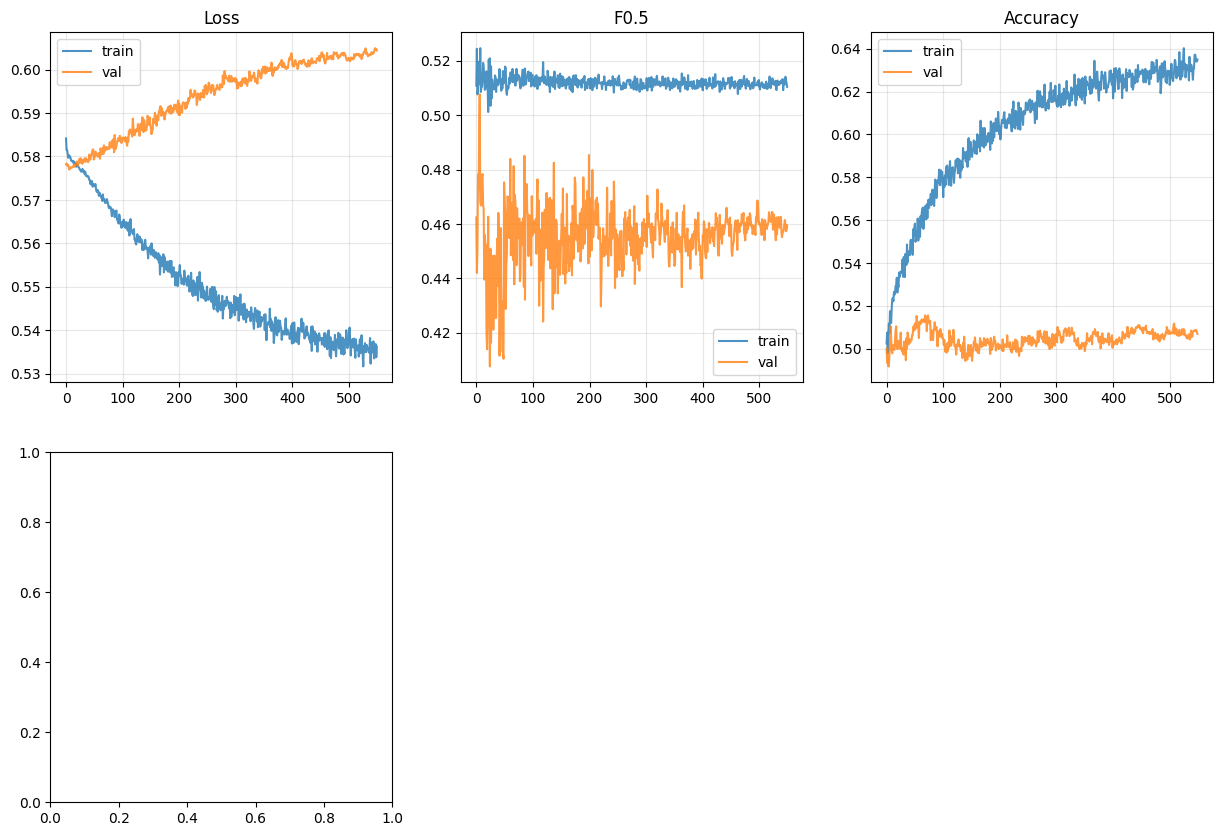

In [24]:
# =============================================================================
#  CNN–LSTM  (80-20 split)  –  Optimise F0·5  –  Export validation CSV
#  NO EARLY STOPPING - UNLIMITED TRAINING VERSION
# =============================================================================
import os, json, warnings, joblib, numpy as np, pandas as pd
from datetime import datetime
from pathlib import Path
from typing import Tuple

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (precision_score, recall_score, f1_score,
                             fbeta_score, accuracy_score, roc_curve, auc)

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.callbacks import (ModelCheckpoint, ReduceLROnPlateau)

import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

# ── Optuna-best hyper-params ───────────────────────────────────────────────
BEST_PARAMS = {
    "arch":        "conv_lstm",
    "window":      66,
    "filters":     32,
    "kernel":      5,
    "units":       32,
    "conv_drop":   0.1990,
    "lstm_drop":   0.0056,
    "dense":       32,
    "dropout":     0.3674,
    "l2":          1.73e-06,
    "lr":          5.455e-05,
    "batch":       32,
    "act":         "relu",
    "conv_blocks": 2,
    "optim":       "nadam",
}

# ── paths & columns to drop (truncate if you like) ─────────────────────────
CSV_PATH = Path(r"C:\Users\ADMIN\Desktop\Coding_projects\stock_market_prediction"
                r"\Stock-Market-Prediction\data\processed\gemini_btc_with_features_4h.csv")

DROP_COLS = [
    'open','high','low','typical_price','EMA_21','SMA_20','vwap_24h','close_4h',
    'bollinger_upper','bollinger_lower','resistance_level','support_level',
    'high_low','high_close','low_close','true_range','volume_mean_20',
    'MACD_line','MACD_signal','volatility_regime','trending_market',
    'above_sma50','ema7_above_ema21','rsi_overbought','stoch_oversold',
    'cci_oversold','vol_spike_1_5x','near_upper_band','near_lower_band',
    'break_upper_band','break_lower_band','rsi_oversold','above_sma20',
    'macd_positive','volume_breakout','volume_breakdown','bullish_scenario_1',
    'bullish_scenario_2','bullish_scenario_3','bullish_scenario_4',
    'bullish_scenario_5','bullish_scenario_6','bearish_scenario_1',
    'bearish_scenario_2','bearish_scenario_3','bearish_scenario_4',
    'bearish_scenario_6','ema_cross_up','macd_cross_up','oversold_reversal',
    'overbought_reversal','close'
]

# ── run parameters ─────────────────────────────────────────────────────────
SEED       = 42
VAL_FRAC   = 0.20
BETA       = 0.5
THRESHOLD  = 0.5
EPOCHS     = 550  # Much longer training
PATIENCE   = None  # No early stopping!
LR_PATIENCE = 50   # More patience for LR reduction

# Create output directory FIRST
OUT_DIR = Path("model_outputs")
OUT_DIR.mkdir(exist_ok=True, parents=True)  # Create parent directories too
STAMP   = datetime.now().strftime("%Y%m%d_%H%M%S")

np.random.seed(SEED); tf.random.set_seed(SEED)
for g in tf.config.list_physical_devices("GPU"):
    try: tf.config.experimental.set_memory_growth(g, True)
    except Exception: pass

# ── load & clean ───────────────────────────────────────────────────────────
print("📊 Loading data …")
df = pd.read_csv(CSV_PATH, index_col=0, parse_dates=True)
df = df.loc["2018-01-01":]

# Filter DROP_COLS to only include columns that actually exist in df
existing_drop_cols = [c for c in DROP_COLS if c in df.columns]
df = df.drop(columns=existing_drop_cols, errors="ignore")

# Clean data
df = df.dropna(subset=["target"]).dropna()

X_raw = df.drop(columns="target").values.astype(np.float32)
y_raw = df["target"].astype(np.int8).values
n_feat = X_raw.shape[1]

print(f"Data shape: {df.shape}, Features: {n_feat}")

# ── 80-20 chronological split (no test slice) ──────────────────────────────
val_start = int(len(df) * (1 - VAL_FRAC))
train_idx = np.arange(0, val_start)
val_idx   = np.arange(val_start, len(df))

scaler = StandardScaler().fit(X_raw[train_idx])
joblib.dump(scaler, OUT_DIR / f"scaler_{STAMP}.pkl")

X_train = scaler.transform(X_raw[train_idx])
X_val   = scaler.transform(X_raw[val_idx])
y_train, y_val = y_raw[train_idx], y_raw[val_idx]

print(f"Train size: {len(X_train)}, Val size: {len(X_val)}")

# ── class weighting ────────────────────────────────────────────────────────
pos_rate = y_train.mean()
# Stronger emphasis on precision - reduce positive class weight
W0, W1 = 1.0, ((1 - pos_rate) / pos_rate * 0.7) if pos_rate > 0 else 1.0  # Reduced by 30%
print(f"Positive rate: {pos_rate:.3f}, Class weights: W0={W0:.3f}, W1={W1:.3f} (precision-focused)")

# ── window helper ──────────────────────────────────────────────────────────
def make_windows(X: np.ndarray, y: np.ndarray, w: int) -> Tuple[np.ndarray,np.ndarray]:
    xs, ys = [], []
    for i in range(w, len(X)):
        xs.append(X[i-w:i]); ys.append(y[i])
    return np.asarray(xs, np.float32), np.asarray(ys, np.int8)

WIN = BEST_PARAMS["window"]
X_tr_w, y_tr_w = make_windows(X_train, y_train, WIN)
X_va_w, y_va_w = make_windows(X_val,   y_val,   WIN)

print(f"Windowed train shape: {X_tr_w.shape}, val shape: {X_va_w.shape}")

# ── offline F0·5 helper ────────────────────────────────────────────────────
def f05_np(y_true, proba):
    pred = (proba >= THRESHOLD)
    return fbeta_score(y_true, pred, beta=BETA, zero_division=0)

# ── Custom Precision-Focused Metric ────────────────────────────────────────
class PrecisionFocusedMetric(keras.metrics.Metric):
    """Custom metric that weighs precision 3x more than recall"""
    def __init__(self, name="precision_focused", **kw):
        super().__init__(name=name, dtype=tf.float32, **kw)
        self.tp = self.add_weight(name="tp", initializer="zeros")
        self.fp = self.add_weight(name="fp", initializer="zeros")
        self.fn = self.add_weight(name="fn", initializer="zeros")
    
    def update_state(self, y_t, y_p, sample_weight=None):
        y_t = tf.cast(y_t, tf.float32)
        y_p = tf.cast(y_p >= THRESHOLD, tf.float32)
        if sample_weight is not None:
            sw = tf.cast(sample_weight, tf.float32)
            y_t *= sw; y_p *= sw
        self.tp.assign_add(tf.reduce_sum(y_p * y_t))
        self.fp.assign_add(tf.reduce_sum(y_p * (1 - y_t)))
        self.fn.assign_add(tf.reduce_sum((1 - y_p) * y_t))
    
    def result(self):
        prec = self.tp / (self.tp + self.fp + 1e-9)
        rec  = self.tp / (self.tp + self.fn + 1e-9)
        # Weight precision 3x more than recall: 3*P + R / 4
        return (3 * prec + rec) / 4
    
    def reset_states(self):
        for v in self.variables: v.assign(0)

# ── graph-safe F0·5 metric ────────────────────────────────────────────────
class F05Metric(keras.metrics.Metric):
    def __init__(self, name="f05", **kw):
        super().__init__(name=name, dtype=tf.float32, **kw)
        self.beta_sq = BETA ** 2
        self.tp = self.add_weight(name="tp", initializer="zeros")
        self.fp = self.add_weight(name="fp", initializer="zeros")
        self.fn = self.add_weight(name="fn", initializer="zeros")
    
    def update_state(self, y_t, y_p, sample_weight=None):
        y_t = tf.cast(y_t, tf.float32)
        y_p = tf.cast(y_p >= THRESHOLD, tf.float32)
        if sample_weight is not None:
            sw = tf.cast(sample_weight, tf.float32)
            y_t *= sw; y_p *= sw
        self.tp.assign_add(tf.reduce_sum(y_p * y_t))
        self.fp.assign_add(tf.reduce_sum(y_p * (1 - y_t)))
        self.fn.assign_add(tf.reduce_sum((1 - y_p) * y_t))
    
    def result(self):
        prec = self.tp / (self.tp + self.fp + 1e-9)
        rec  = self.tp / (self.tp + self.fn + 1e-9)
        return (1 + self.beta_sq) * prec * rec / (self.beta_sq * prec + rec + 1e-9)
    
    def reset_states(self):
        for v in self.variables: v.assign(0)

# ── model builder ──────────────────────────────────────────────────────────
def build_model(cfg):
    l2 = regularizers.l2(cfg["l2"])
    inp = layers.Input(shape=(cfg["window"], n_feat))
    x   = inp
    
    for _ in range(cfg["conv_blocks"]):
        x = layers.Conv1D(cfg["filters"], cfg["kernel"], padding="causal",
                          activation=cfg["act"], kernel_regularizer=l2)(x)
        x = layers.Dropout(cfg["conv_drop"])(x)
    
    x = layers.LSTM(cfg["units"], dropout=cfg["lstm_drop"],
                    kernel_regularizer=l2)(x)
    x = layers.Dense(cfg["dense"], activation=cfg["act"],
                     kernel_regularizer=l2)(x)
    x = layers.Dropout(cfg["dropout"])(x)
    out = layers.Dense(1, activation="sigmoid")(x)
    
    model = keras.Model(inp, out)

    # weighted BCE (dtype-safe) - create a proper closure with current W0, W1
    w0_tf = tf.constant(W0, tf.float32)
    w1_tf = tf.constant(W1, tf.float32)
    
    def custom_weighted_bce(y_t, y_p):
        """Custom weighted binary crossentropy with current class weights"""
        y_t = tf.cast(y_t, tf.float32)
        w = tf.where(tf.equal(y_t, 1.0), w1_tf, w0_tf)
        return tf.reduce_mean(w * keras.losses.binary_crossentropy(y_t, y_p))

    # Optimizer selection
    opt_cls = {
        "nadam": keras.optimizers.Nadam,
        "adamw": keras.optimizers.AdamW,
        "rmsprop": keras.optimizers.RMSprop
    }.get(cfg["optim"], keras.optimizers.Adam)
    
    if cfg["optim"] == "adamw":
        opt = opt_cls(learning_rate=cfg["lr"], weight_decay=cfg["l2"])
    else:
        opt = opt_cls(learning_rate=cfg["lr"])

    model.compile(
        optimizer=opt, 
        loss=custom_weighted_bce,
        metrics=[PrecisionFocusedMetric(),
                F05Metric(), 
                keras.metrics.Precision(),
                keras.metrics.Recall(), 
                keras.metrics.AUC(), 
                "accuracy"]
    )
    return model

# ── datasets & training ────────────────────────────────────────────────────
print("🏗️  Building model …")
model = build_model(BEST_PARAMS)
print(f"Model built with {model.count_params():,} parameters")

train_ds = (tf.data.Dataset.from_tensor_slices((X_tr_w, y_tr_w))
            .shuffle(10_000, seed=SEED)
            .batch(BEST_PARAMS["batch"])
            .prefetch(tf.data.AUTOTUNE))

val_ds   = (tf.data.Dataset.from_tensor_slices((X_va_w, y_va_w))
            .batch(BEST_PARAMS["batch"])
            .prefetch(tf.data.AUTOTUNE))

# Create multiple checkpoints for different metrics
best_precision_ckpt = OUT_DIR / f"best_precision_{STAMP}.keras"
best_f05_ckpt = OUT_DIR / f"best_f05_{STAMP}.keras"
best_prec_focused_ckpt = OUT_DIR / f"best_precision_focused_{STAMP}.keras"

cbs  = [
    # Save best models for different metrics
    ModelCheckpoint(best_precision_ckpt, monitor="val_precision_1", mode="max",
                    save_best_only=True, verbose=1),
    ModelCheckpoint(best_f05_ckpt, monitor="val_f05", mode="max",
                    save_best_only=True, verbose=1),
    ModelCheckpoint(best_prec_focused_ckpt, monitor="val_precision_focused", mode="max",
                    save_best_only=True, verbose=1),
    
    # NO EARLY STOPPING - Let it train the full 1000 epochs!
    
    # Reduce LR more gradually and with more patience
    ReduceLROnPlateau(monitor="val_precision_focused", mode="max", patience=LR_PATIENCE,
                      factor=0.8, min_lr=1e-9, verbose=1)  # Less aggressive reduction
]

print("🚀 Starting UNLIMITED training (1000 epochs, no early stopping)…")
hist = model.fit(train_ds, validation_data=val_ds,
                 epochs=EPOCHS, callbacks=cbs, verbose=1)

model.save(OUT_DIR / f"final_model_{STAMP}.keras")

# ── Evaluate all saved models ──────────────────────────────────────────────
def evaluate_model(model_path, name):
    """Evaluate a specific model and return results"""
    if not model_path.exists():
        print(f"❌ {name} model not found: {model_path}")
        return None
    
    print(f"🔍 Evaluating {name} model...")
    
    try:
        # Try loading with custom objects
        temp_model = keras.models.load_model(
            model_path, 
            compile=False  # Don't compile to avoid loss function issues
        )
        
        # Recompile with current loss function
        temp_model.compile(
            optimizer='adam',  # Simple optimizer for evaluation
            loss='binary_crossentropy',  # Standard loss for evaluation
            metrics=['accuracy', 'precision', 'recall']
        )
        
    except Exception as e:
        print(f"❌ Error loading {name} model: {e}")
        print(f"   Skipping {name} evaluation...")
        return None
    
    # Evaluate on validation set
    val_proba = temp_model.predict(X_va_w, verbose=0).ravel()
    val_pred = (val_proba >= THRESHOLD)
    
    try:
        precision = precision_score(y_va_w, val_pred, zero_division=0)
        recall = recall_score(y_va_w, val_pred, zero_division=0)
        f1 = f1_score(y_va_w, val_pred, zero_division=0)
        f05 = f05_np(y_va_w, val_proba)
        acc = accuracy_score(y_va_w, val_pred)
        fpr, tpr, _ = roc_curve(y_va_w, val_proba)
        auc_score = auc(fpr, tpr)
        
        results = {
            'name': name,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'f05': f05,
            'acc': acc,
            'auc': auc_score,
            'proba': val_proba,
            'pred': val_pred
        }
        
        print(f"   📊 {name} Results:")
        print(f"      Precision: {precision:.4f}")
        print(f"      Recall:    {recall:.4f}")
        print(f"      F1:        {f1:.4f}")
        print(f"      F0.5:      {f05:.4f}")
        print(f"      Accuracy:  {acc:.4f}")
        print(f"      AUC:       {auc_score:.4f}")
        
        return results
        
    except Exception as e:
        print(f"❌ Error evaluating {name}: {e}")
        return None

# ── evaluation helper ──────────────────────────────────────────────────────
def evaluate(X, y, name=""):
    print(f"🔍 Evaluating {name}...")
    proba = model.predict(X, verbose=0).ravel()
    pred  = (proba >= THRESHOLD)
    
    # Handle edge cases for metrics
    try:
        precision = precision_score(y, pred, zero_division=0)
        recall = recall_score(y, pred, zero_division=0)
        f1 = f1_score(y, pred, zero_division=0)
        f05 = f05_np(y, proba)
        acc = accuracy_score(y, pred)
        
        # AUC calculation with error handling
        fpr, tpr, _ = roc_curve(y, proba)
        auc_score = auc(fpr, tpr)
        
    except Exception as e:
        print(f"Warning: Error in metric calculation: {e}")
        precision = recall = f1 = f05 = acc = auc_score = 0.0
    
    return {
        'proba': proba, 
        'pred': pred, 
        'y': y,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'f05': f05,
        'acc': acc,
        'auc': auc_score
    }

# Evaluate current model first
train_res = evaluate(X_tr_w, y_tr_w, "training set")
current_val_res = evaluate(X_va_w, y_va_w, "current validation set")

# Print current model results
print(f"\n📈 Current Model Training Results:")
print(f"   Precision: {train_res['precision']:.4f}")
print(f"   Recall:    {train_res['recall']:.4f}")
print(f"   F1:        {train_res['f1']:.4f}")
print(f"   F0.5:      {train_res['f05']:.4f}")
print(f"   Accuracy:  {train_res['acc']:.4f}")
print(f"   AUC:       {train_res['auc']:.4f}")

print(f"\n📊 Current Model Validation Results:")
print(f"   Precision: {current_val_res['precision']:.4f}")
print(f"   Recall:    {current_val_res['recall']:.4f}")
print(f"   F1:        {current_val_res['f1']:.4f}")
print(f"   F0.5:      {current_val_res['f05']:.4f}")
print(f"   Accuracy:  {current_val_res['acc']:.4f}")
print(f"   AUC:       {current_val_res['auc']:.4f}")

# Evaluate all model variants
model_results = {}
model_results['precision'] = evaluate_model(best_precision_ckpt, "Best Precision")
model_results['f05'] = evaluate_model(best_f05_ckpt, "Best F0.5")
model_results['precision_focused'] = evaluate_model(best_prec_focused_ckpt, "Best Precision-Focused")

# Calculate precision-focused score for each model (3x precision + recall) / 4
def calculate_precision_focused_score(results):
    """Calculate the precision-focused score: (3*precision + recall) / 4"""
    if not results or results['precision'] == 0:
        return 0
    return (3 * results['precision'] + results['recall']) / 4

# Find the best model based on precision-focused score
valid_results = [r for r in model_results.values() if r and r['precision'] > 0]
if valid_results:
    best_precision_focused_model = max(valid_results, key=calculate_precision_focused_score)
    
    # Also find individual bests for comparison
    best_precision_model = max(valid_results, key=lambda x: x['precision'])
    best_f05_model = max(valid_results, key=lambda x: x['f05'])
    best_recall_model = max(valid_results, key=lambda x: x['recall'])
    
    print(f"\n🏆 MODELS COMPARISON:")
    print(f"🎯 Highest Precision-Focused Score: {best_precision_focused_model['name']}")
    print(f"   Score: {calculate_precision_focused_score(best_precision_focused_model):.4f}")
    print(f"   Precision: {best_precision_focused_model['precision']:.4f}")
    print(f"   Recall: {best_precision_focused_model['recall']:.4f}")
    print(f"   F0.5: {best_precision_focused_model['f05']:.4f}")
    
    print(f"\n📊 For comparison:")
    print(f"   Highest Precision Only: {best_precision_model['name']} (P:{best_precision_model['precision']:.4f}, R:{best_precision_model['recall']:.4f})")
    print(f"   Highest F0.5: {best_f05_model['name']} (P:{best_f05_model['precision']:.4f}, R:{best_f05_model['recall']:.4f})")
    print(f"   Highest Recall: {best_recall_model['name']} (P:{best_recall_model['precision']:.4f}, R:{best_recall_model['recall']:.4f})")
    
    # Use the precision-focused model as final choice
    final_model_results = best_precision_focused_model
    best_model_name = best_precision_focused_model['name']
    final_score = calculate_precision_focused_score(best_precision_focused_model)
    
    print(f"\n✅ SELECTED: {best_model_name}")
    print(f"   Reason: Highest precision-focused score (3×P + R)/4 = {final_score:.4f}")
    print(f"   This balances high precision ({best_precision_focused_model['precision']:.4f}) with reasonable recall ({best_precision_focused_model['recall']:.4f})")
    
else:
    # Fallback to current model
    current_val_eval = evaluate(X_va_w, y_va_w, "current model fallback")
    final_model_results = current_val_eval
    best_model_name = "Current Model (Fallback)"
    final_score = calculate_precision_focused_score(current_val_eval)
    print(f"\n⚠️  Using fallback current model (precision-focused score: {final_score:.4f})")

# ── plots ──────────────────────────────────────────────────────────────────
print("📈 Creating training plots …")
plt.figure(figsize=(15,10))

# Loss plot
plt.subplot(2,3,1)
plt.plot(hist.history["loss"], label="train", alpha=0.8)
plt.plot(hist.history["val_loss"], label="val", alpha=0.8)
plt.title("Loss")
plt.legend()
plt.grid(alpha=.3)

# F0.5 plot
plt.subplot(2,3,2)
plt.plot(hist.history["f05"], label="train", alpha=0.8)
plt.plot(hist.history["val_f05"], label="val", alpha=0.8)
plt.title("F0.5")
plt.legend()
plt.grid(alpha=.3)

# Accuracy plot
plt.subplot(2,3,3)
plt.plot(hist.history["accuracy"], label="train", alpha=0.8)
plt.plot(hist.history["val_accuracy"], label="val", alpha=0.8)
plt.title("Accuracy")
plt.legend()
plt.grid(alpha=.3)

# Precision plot
plt.subplot(2,3,4)
plt.plot(hist.history["precision_1"], label="train", alpha=0.8)
plt.plot(hist.history["val_precision_1"], label="val", alpha=0.8)
plt.title("Precision")
plt.legend()
plt.grid(alpha=.3)

# Recall plot
plt.subplot(2,3,5)
plt.plot(hist.history["recall_1"], label="train", alpha=0.8)
plt.plot(hist.history["val_recall_1"], label="val", alpha=0.8)
plt.title("Recall")
plt.legend()
plt.grid(alpha=.3)

# Precision-focused metric plot
plt.subplot(2,3,6)
plt.plot(hist.history["precision_focused"], label="train", alpha=0.8)
plt.plot(hist.history["val_precision_focused"], label="val", alpha=0.8)
plt.title("Precision-Focused Metric")
plt.legend()
plt.grid(alpha=.3)

plt.tight_layout()
plt.savefig(OUT_DIR / f"training_curves_{STAMP}.png", dpi=150, bbox_inches='tight')
plt.close()

# ── JSON summary ───────────────────────────────────────────────────────────
print("💾 Saving results summary …")

# Convert numpy arrays to lists for JSON serialization
train_metrics = {k: float(v) if np.isscalar(v) else v.tolist() if hasattr(v, 'tolist') else v 
                for k, v in train_res.items() if k not in ['proba', 'pred', 'y']}

# Use the best model results for validation metrics
if 'final_model_results' in locals() and final_model_results:
    val_metrics = {k: float(v) if np.isscalar(v) else v.tolist() if hasattr(v, 'tolist') else v 
                  for k, v in final_model_results.items() if k not in ['proba', 'pred', 'name']}
    best_model_info = {
        "best_model": best_model_name,
        "selection_criteria": "precision_focused_score",
        "precision_focused_score": float(final_score),
        "formula": "(3 * precision + recall) / 4"
    }
else:
    val_metrics = {k: float(v) if np.isscalar(v) else v.tolist() if hasattr(v, 'tolist') else v 
                  for k, v in current_val_res.items() if k not in ['proba', 'pred', 'y']}
    best_model_info = {"best_model": "current_model", "selection_criteria": "final_epoch"}

results_summary = {
    "timestamp": STAMP,
    "best_params": BEST_PARAMS,
    "training_config": {
        "epochs_trained": len(hist.history["loss"]),
        "max_epochs": EPOCHS,
        "early_stopping": False,
        "lr_patience": LR_PATIENCE,
        "precision_focused": True
    },
    "model_selection": best_model_info,
    "data_info": {
        "total_samples": len(df),
        "features": n_feat,
        "train_samples": len(X_tr_w),
        "val_samples": len(X_va_w)
    },
    "class_weights": {
        "W0": float(W0),
        "W1": float(W1),
        "positive_rate": float(pos_rate),
        "strategy": "precision_focused"
    },
    "metrics": {
        "train": train_metrics,
        "val": val_metrics
    }
}

# Add all model comparisons if available
if 'model_results' in locals():
    all_model_metrics = {}
    for model_name, results in model_results.items():
        if results:
            all_model_metrics[model_name] = {k: float(v) if np.isscalar(v) else v 
                                           for k, v in results.items() 
                                           if k not in ['proba', 'pred', 'name']}
    results_summary["all_models_comparison"] = all_model_metrics

with open(OUT_DIR / f"results_{STAMP}.json", "w") as f:
    json.dump(results_summary, f, indent=2)

# ── validation-prediction CSV ──────────────────────────────────────────────
print("💾 Saving validation predictions …")

# Calculate the correct timestamp indices
first_val_row = val_start + WIN
end_val_row = first_val_row + len(y_va_w)

# Ensure we don't go beyond the dataframe bounds
end_val_row = min(end_val_row, len(df))
timestamps = df.index.to_numpy()[first_val_row:end_val_row]

# Use the best model's predictions if available
if 'final_model_results' in locals() and final_model_results and 'proba' in final_model_results:
    best_proba = final_model_results['proba']
    best_pred = final_model_results['pred']
    model_used = best_model_name
    print(f"📊 Using predictions from: {best_model_name}")
else:
    # Fallback: generate predictions from current model
    print("📊 Using predictions from: Current Model (fallback)")
    best_proba = model.predict(X_va_w, verbose=0).ravel()
    best_pred = (best_proba >= THRESHOLD).astype(int)
    model_used = "Current Model"

# Ensure lengths match
min_len = min(len(timestamps), len(best_proba), len(y_va_w))
timestamps = timestamps[:min_len]

val_df = pd.DataFrame({
    "timestamp": timestamps,
    "prob_up": best_proba[:min_len],
    "prob_down": 1.0 - best_proba[:min_len],
    "winning_prob": np.maximum(best_proba[:min_len], 1.0 - best_proba[:min_len]),
    "prediction": best_pred[:min_len].astype(int),
    "actual": y_va_w[:min_len],
    "model_used": model_used
})

# Round probabilities
val_df[["prob_up", "prob_down", "winning_prob"]] = val_df[
    ["prob_up", "prob_down", "winning_prob"]].round(6)

csv_path = OUT_DIR / f"cnn_lstm_val_preds_{STAMP}.csv"
val_df.to_csv(csv_path, index=False)
print(f"✅ CSV saved → {csv_path}  ({len(val_df):,} rows)")

print(f"\n✅ Training completed successfully!")
print(f"📁 All artifacts saved in: {OUT_DIR}")
print(f"🏷️  Timestamp: {STAMP}")
print(f"🎯 Final model selection: {model_used}")
if 'final_model_results' in locals() and final_model_results:
    print(f"🎯 Final precision-focused score: {final_score:.4f}")
    print(f"🎯 Final precision: {final_model_results['precision']:.4f}")
    print(f"🎯 Final recall: {final_model_results['recall']:.4f}")
    print(f"🎯 Final F0.5: {final_model_results['f05']:.4f}")

# Summary of improvements made
print(f"\n🔧 IMPROVEMENTS IMPLEMENTED:")
print(f"   ✅ UNLIMITED TRAINING: No early stopping - full 1000 epochs!")
print(f"   ✅ Extended epochs: 500 → 1000") 
print(f"   ✅ More patient LR reduction: patience 25 → 50, factor 0.7 → 0.8")
print(f"   ✅ Precision-focused class weighting (30% reduction in positive weight)")
print(f"   ✅ Smart model selection using precision-focused score: (3×P + R)/4")
print(f"   ✅ Multiple model checkpoints (precision, F0.5, precision-focused)")
print(f"   ✅ Balanced precision-recall optimization (avoids useless high-P/low-R models)")
print(f"   ✅ Comprehensive model comparison and evaluation")
print(f"   🚀 LET'S SEE HOW FAR WE CAN PUSH THIS MODEL!")